In [1]:
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method 
from cleverhans.torch.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.torch.attacks.noise import noise 
from cleverhans.torch.attacks.hop_skip_jump_attack import hop_skip_jump_attack 
from cleverhans.torch.attacks.spsa import spsa 
from cleverhans.torch.attacks.carlini_wagner_l2 import carlini_wagner_l2 
from cleverhans.torch.attacks.sparse_l1_descent import sparse_l1_descent 

import random



In [2]:
#https://github.com/nhamlv-55/CFI_NNs/blob/master/MNIST_toy/Experiment-Feb28-xujie-Copy1.ipynb

from models import FeedforwardNeuralNetModel, TinyCNN, PatternClassifier, NewTinyCNN
import regularizer_losts as rl
from torchvision import datasets, transforms
from torch import optim
import torch
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm
import copy
import utils as CFI_utils
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
#from frozendict import frozendict
from datetime import datetime
# import seaborn as sn
import pandas as pd


from absl import app, flags
from easydict import EasyDict
import torch.nn as nn





%matplotlib inline

import seaborn as sns
colors = sns.color_palette("tab10")

#Logging stuffs
import logging
import sys
# Create logger
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Create STDERR handler
handler = logging.StreamHandler(sys.stderr)
# ch.setLevel(logging.DEBUG)

# Create formatter and add it to the handler
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)

# Set STDERR handler as the only handler 
logger.handlers = [handler]

#configs
epochs = 10
batch_size = 1000
test_batch_size = 10000
stable_batch_size = 60000
use_cuda = torch.cuda.is_available()
print(use_cuda)

lr = 0.01
log_interval = 100

#torch specific configs
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': batch_size}

test_kwargs = {'batch_size': test_batch_size}
stable_kwargs = {'batch_size': stable_batch_size}
unshuffle_kwargs = {'batch_size': test_batch_size}
unshuffle_train_kwargs = {'batch_size': stable_batch_size}

if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)
    stable_kwargs.update(cuda_kwargs)
    unshuffle_kwargs.update(cuda_kwargs)
    unshuffle_kwargs['shuffle'] = False
    unshuffle_train_kwargs.update(cuda_kwargs)
    unshuffle_train_kwargs['shuffle'] = False
class Shift:
    def __init__(self, shift = 0):
        print("alive")
        self.shift = shift

    def __call__(self, arr):
        print("running")
        #print(arr)
        return arr
    def __repr__(self) -> str:
        return f"{self.__class__.__name__}()"
    
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
   
  
])

def shift_and_roll(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:
    return torch.roll(arr, shifts = (x,y), dims = (0,1)) #indexing
def shift(arr : torch.Tensor, x : int , y : int) -> torch.Tensor:

    pad = [0,0,0,0]
    x_start = 0
    x_end = 0
    y_start = 0
    y_end = 0
    if x >= 0:
        pad[0] = x
        x_start = 0
        x_end = 28
    else:
        pad[1] = abs(x)
        x_start = -28
         
         
        
         
    
    if y >= 0:
        pad[2] = y
        y_start = 0
        y_end = 28
    else:
        pad[3] = abs(y)
        y_start= -28
        print("ys is {}".format(y_start))
    

    padder = torch.nn.ZeroPad2d(tuple(pad))
  
    result = padder(arr)

    if y < 0:
        y_end = result.shape[0]
    if x < 0:
        x_end = result.shape[1]
    
    return result[y_start:y_end, x_start:x_end]

def noisify(arr : torch.Tensor , distribution : torch.distributions.Distribution) -> torch.Tensor: #randomly add noise
   
    #print(distribution.sample(arr.size()).shape\\)
    #print(torch.reshape(distribution.sample(arr.size()), (28,28)).shape)
   
    noise = torch.reshape(distribution.sample(arr.size()), (arr.shape))
    return arr + noise
transform = transforms.Compose([
    transforms.ToTensor(),
   
    transforms.Normalize((0.1307,), (0.3081,))
])


True


In [3]:
def transform_dataset(dataset):
    '''
    DO A STATE CHANGE
    '''
    shift_x = 1
    shift_y = 0
    mu = 1
    sigma = 1
    do_shift = False
    do_noisfy = True
    modification_string = "base"
    if do_shift:
        modification_string += " -shift {} {} - ".format(shift_x, shift_y)
    if do_noisfy:
        modification_string += " -noise added using gaussian using mean {} and stddev {}- ".format(mu, sigma)
    for i in range(dataset.data.shape[0]):
        if do_shift:
            dataset.data[i,:,:] = shift(dataset.data[i,:,:],shift_x, shift_y)
        
        if do_noisfy:
            gaussian = torch.distributions.Normal(loc = mu, scale = sigma)# loc = mu, scale = stddev

            dataset.data[i,:,:] = noisify(dataset.data[i,:,:], gaussian)
    return modification_string

## Train/Load model


In [4]:
def check_gradient(grad, label, last_sorted_grads, plot = False):
    logging.info("CHECKING GRADIENT FOR LABEL {}".format(label))
    sum_abs_grad = np.sum(abs(grad[label]), axis = 0)
    
    current_sorted_grad = (-sum_abs_grad).argsort()
    
#     if len(last_sorted_grads[label]) > 0:
#         for k in [100, 200, 300, 400]:
#             prev_top_k = set(last_sorted_grads[label][-1][:k])
#             current_top_k = set(current_sorted_grad[:k])
#             intersect = prev_top_k.intersection(current_top_k)
#             logging.info('k = {}. How many top Gradients are stable since last epoch?: {}'.format(k, len(intersect)))
        
    for k in [0, 9, 99, 199]:    
        logging.debug('{}th biggest gradient = {}'.format(k, np.sort(-sum_abs_grad)[k]))
    if plot:
        fig = plt.figure(figsize=(30, 1))
        plt.bar(range(sum_abs_grad.shape[0]), sum_abs_grad)
        plt.show()
        print(sum_abs_grad.max(), sum_abs_grad.argmax(), sum_abs_grad.min())

    return current_sorted_grad



#init stuffs
LOAD = True
# LOADPATH = 'FFN19-17-24'
LOADPATH = 'FFN18_28_21'
# LOADPATH = 'TinyCNN14-28-29'

LAST_N_EPOCHS = 10

dataset1 = datasets.MNIST('./data', train=True, download=False,
                          transform=transform)
dataset2 = datasets.MNIST('./data', train=False, download=False,
                          transform=transform)


#transform_dataset(dataset1)
#modification_string = transform_dataset(dataset2)
modification_string = ""
train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
unshuffle_train_loader = torch.utils.data.DataLoader(dataset1, **unshuffle_train_kwargs)

unshuffle_test_loader = torch.utils.data.DataLoader(dataset2, **unshuffle_kwargs)

model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
# model = TinyCNN().to(device)

if LOAD:
    model.load_state_dict(torch.load(LOADPATH))
else:

    epochs = 10
    optimizer = optim.Adadelta(model.parameters(), lr=lr)

    scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
    last_sorted_grads = defaultdict(list)
    
    all_rows = []
    
    for epoch in tqdm(range(1, epochs + 1)):
        model.register_gradient()
        model.train()
        target_log  = None # need to record the label to match with the gradient later
        for data, target in train_loader:
            target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data.float())
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
        CFI_utils.test(model, device, test_loader)
#         scheduler.step()
        grad = CFI_utils.get_grad_each_label(model.gradient_log, 
                                      target_log = target_log, 
                                      layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
#                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
                                      labels = range(10))
        torch.save(model.state_dict(), model.model_savename())
        
        row_data = []
        for label in range(10):
            r = []
            logging.info("After {} epoch:".format(epoch))
            last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))
            
            
            if epoch >= LAST_N_EPOCHS:
                for k in [100, 200, 300, 400]:
                    all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
                    intersect = set.intersection(*all_top_k)
                    logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
    modification_string += " -accuracy {}-".format( correct/total)
    print(modification_string)

 -accuracy 0.9042-


#### Compute all patterns in the training set, and put them into corresponding labels

In [5]:
class Patterns:
    def __init__(self, model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, labels, layers):
        self._model = model
        self.label2patterns = {}
        self.label2idx = {}
        self._labels = labels
        self._layers = layers
        self._dataloader = dataloader
        self._populate()
        
    def _populate(self):
        
        label2patterns = {}
        label2idx = {}
        for label in self._labels:
            patterns = []
            filter_ids = []
            
            for data, target in self._dataloader:
                
                flter = np.where(target == label)
                filter_ids.append(flter)
                data = data[flter]
                logging.debug(data.shape[0])
                pattern = self._model.get_pattern(data, layers, device, flatten = True)
                logging.debug(pattern.shape)
                patterns.append(pattern)

            patterns = np.squeeze(np.concatenate(patterns, axis = 0))
            filter_ids = np.squeeze(np.concatenate(filter_ids, axis = 0))
            label2patterns[label] = patterns
            label2idx[label] = filter_ids
            
            logging.info(patterns.shape)
        
        #freeze
        self.label2patterns = dict(label2patterns)
        self.label2idx = dict(label2idx)
        
    def apply_filter(self, f):
        pass
    
    def unique():
        pass
    
    def query_pattern():
        pass
    
    

layers = ['fc1', 'fc2', 'fc3', 'fc4']
# layers = ['conv1', 'conv2','fc1', 'fc2']

labels = range(10)
K = 25
stable_loader = torch.utils.data.DataLoader(dataset1, **stable_kwargs)

all_patterns = Patterns(model = model,
                        dataloader = stable_loader,
                        labels = labels,
                        layers = layers)
all_test_patterns = Patterns(model = model,
                        dataloader = test_loader,
                        labels = labels,
                        layers = layers)



root - INFO - (5923, 458)
root - INFO - (6742, 458)
root - INFO - (5958, 458)
root - INFO - (6131, 458)
root - INFO - (5842, 458)
root - INFO - (5421, 458)
root - INFO - (5918, 458)
root - INFO - (6265, 458)
root - INFO - (5851, 458)
root - INFO - (5949, 458)
root - INFO - (980, 458)
root - INFO - (1135, 458)
root - INFO - (1032, 458)
root - INFO - (1010, 458)
root - INFO - (982, 458)
root - INFO - (892, 458)
root - INFO - (958, 458)
root - INFO - (1028, 458)
root - INFO - (974, 458)
root - INFO - (1009, 458)


In [6]:
#we can only study gradient if the model is trained
# FIXME: should save gradient into a pickle as well
if not LOAD:
    for K in [25, 50, 100]:
        print("K=", K)
        row = []
        row.append(str(K))
        for label in labels:
            #construct the stable gradients 
            all_top_k = [set(sorted_grad[:K]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
            intersect = set.intersection(*all_top_k)
            stable_grad = np.array(sorted(list(intersect)))
            print("There are {} stable grad in top K".format(len(stable_grad)))
            print(stable_grad)

            logging.info(all_patterns[label].shape)
            print("LABEL:", label)
            print("how many unique paths in the full pattern?", np.unique(all_patterns[label], axis = 0).shape)
            print("how many unique paths in the filtered pattern?", np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape)
            print("how many unique paths in the randomly filtered pattern?", 
                  np.unique(patterns[:, 
                                     np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape)
            row.append("|".join([str(len(stable_grad)),
                                 str(np.unique(all_patterns[label], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, stable_grad ], axis = 0).shape[0]),
                                 str(np.unique(all_patterns[label][:, np.random.choice(458, len(stable_grad), replace = False) ], axis = 0).shape[0])
                                ]))
        all_rows.append(",".join(row)+"\n")

    with open("gradient_exp_log_2.csv", "w") as f:
        f.write("K,"+",".join([str(l) for l in labels]) + "\n")
        f.writelines(all_rows)

In [7]:
# import json

# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.bool_):
#             return int(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super(NpEncoder, self).default(obj)
    


# all_stable_relus = []

# all_alpha_patterns = {"model": LOADPATH}

# write_log = True
# if write_log:
#     ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
#     ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
#     ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# # for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
# epsilon_to_patterns = dict()
# # for epsilon in [0.0001]:

# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.2]:
#     alpha_patterns = {}
#     label_to_most_common_pattern = dict()
#     for label in all_patterns.label2patterns:
# #     for label in [0,2,8]:
#         patterns = all_patterns.label2patterns[label]
#         print(patterns.shape)

#         occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
#         most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

#         #print("most common pattern: {}".format(most_common_pattern) )
        
#         pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
#         #print("pattern_indices: {}".format(pattern_indices))
#         label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
#         relu_sum = np.sum(patterns, axis = 0).squeeze()
        
#         print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
# #         print("relu_sum, layer-1 ", relu_sum[:256])
# #         print("relu_sum, layer-2 ", relu_sum[256:384])
# #         print("relu_sum, layer-3 ", relu_sum[384:448])
#         print("relu_sum, prediction", relu_sum[448:458])
# #         print("relu_sum", relu_sum[-10:])
        
#         non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
#         active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
#         print("non active neurons: ", non_active_neurons)
#         print("active neurons: ", active_neurons)

#         stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
#                                      np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
#                                     axis = 1
#                                     ).squeeze()
#         neuro_idx = patterns.shape[1] - 10 + label
#         if neuro_idx not in stable_idx:
#             print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
#             stable_idx = np.append(stable_idx, neuro_idx)
#         stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
#         unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
#         alpha_p = unique_patterns[np.argmax(freq)]
#         print("unique patterns:", unique_patterns)
#         print()
#         print("Label is ", label)
#         print("Stable ReLUs", stable_idx)
#         print("how many unique paths in the filtered pattern?", unique_patterns.shape)
#         print("their freq\n", freq, freq.shape)
# #         print("most prominent pattern", np.argmax(freq), alpha_p)
# #         print("alpha_p is ", alpha_p)


#         assert(len(stable_idx) == alpha_p.shape[-1])
#         assert(freq.shape[0]==unique_patterns.shape[0])
# #         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
# #         alpha_patterns[label] = {"stable_idx": stable_idx,
# #                                 "alpha_pattern": alpha_p,
# #                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
# #                                 "pattern_frequency": freq}
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                  "active_neurons": active_neurons[0],
#                                  "non_active_neurons": non_active_neurons[0],
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
    
# #         print("pattern frequency:", freq)
#         print("primary pattern coverage: ", freq.max()/freq.sum(),)

#         if write_log:
#             ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
#     all_alpha_patterns[epsilon] = alpha_patterns
#     epsilon_to_patterns[epsilon] = label_to_most_common_pattern
# json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
# if write_log:
#     ReLU_exp_log.close()
#     json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
#     ReLU_exp_json.close()

# Check the distribution of randomly sampled examples around one direction  
- One train image, one test image(same class as the train image), one random generated image
- Sample same number of examples around these three images and observe the distribution of prediction

In [8]:
# import json

# class NpEncoder(json.JSONEncoder):
#     def default(self, obj):
#         if isinstance(obj, np.integer):
#             return int(obj)
#         if isinstance(obj, np.floating):
#             return float(obj)
#         if isinstance(obj, np.bool_):
#             return int(obj)
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         return super(NpEncoder, self).default(obj)
    


# all_stable_relus = []

# all_alpha_patterns = {"model": LOADPATH}

# write_log = True
# if write_log:
#     ReLU_exp_log = open("relu_exp_log{}.csv".format(datetime.now().strftime("%H-%M-%S")), "w")
#     ReLU_exp_json = open("relu_exp_data{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")
#     ReLU_exp_log.write("Epsilon,Label,NumStableReLU,NumUniqueAP,Alpha Pattern Cover\n")



# # for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]:
# epsilon_to_patterns = dict()
# # for epsilon in [0.0001]:

# for epsilon in [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.2]:
#     alpha_patterns = {}
#     label_to_most_common_pattern = dict()
#     for label in all_patterns.label2patterns:
# #     for label in [0,2,8]:
#         patterns = all_patterns.label2patterns[label]
#         print(patterns.shape)

#         occuring_patterns = patterns.tolist() #make patterns into list of lists first dim is each example, second dim is the pattern
#         most_common_pattern = max(occuring_patterns, key =  lambda x :occuring_patterns.count(x)) #argmax the count of each pattern

#         #print("most common pattern: {}".format(most_common_pattern) )
        
#         pattern_indices = list(filter( lambda x : most_common_pattern[x] , range(len(most_common_pattern))   ))#get true indices     
#         #print("pattern_indices: {}".format(pattern_indices))
#         label_to_most_common_pattern[label] = (pattern_indices,most_common_pattern)
#         relu_sum = np.sum(patterns, axis = 0).squeeze()
        
#         print("threshold: ", epsilon*patterns.shape[0], (1-epsilon)*patterns.shape[0])
        
# #         print("relu_sum, layer-1 ", relu_sum[:256])
# #         print("relu_sum, layer-2 ", relu_sum[256:384])
# #         print("relu_sum, layer-3 ", relu_sum[384:448])
#         print("relu_sum, prediction", relu_sum[448:458])
# #         print("relu_sum", relu_sum[-10:])
        
#         non_active_neurons = np.where(relu_sum<=epsilon*patterns.shape[0])
#         active_neurons = np.where(relu_sum>=(1-epsilon)*patterns.shape[0])
#         print("non active neurons: ", non_active_neurons)
#         print("active neurons: ", active_neurons)

#         stable_idx = np.concatenate([np.where(relu_sum<=epsilon*patterns.shape[0]), 
#                                      np.where(relu_sum>=(1-epsilon)*patterns.shape[0])],
#                                     axis = 1
#                                     ).squeeze()
#         neuro_idx = patterns.shape[1] - 10 + label
#         if neuro_idx not in stable_idx:
#             print(f"WARN: neuro_idx = {neuro_idx} for label {label} is not stable, let's include it anyway")
#             stable_idx = np.append(stable_idx, neuro_idx)
#         stable_idx = sorted(stable_idx) #sort the indices of the stable ReLUs. 
#         unique_patterns, freq = np.unique(patterns[:, stable_idx ], axis = 0, return_counts=True)
#         alpha_p = unique_patterns[np.argmax(freq)]
#         print("unique patterns:", unique_patterns)
#         print()
#         print("Label is ", label)
#         print("Stable ReLUs", stable_idx)
#         print("how many unique paths in the filtered pattern?", unique_patterns.shape)
#         print("their freq\n", freq, freq.shape)
# #         print("most prominent pattern", np.argmax(freq), alpha_p)
# #         print("alpha_p is ", alpha_p)


#         assert(len(stable_idx) == alpha_p.shape[-1])
#         assert(freq.shape[0]==unique_patterns.shape[0])
# #         alpha_patterns[label] = (stable_idx, tuple(alpha_p))
# #         alpha_patterns[label] = {"stable_idx": stable_idx,
# #                                 "alpha_pattern": alpha_p,
# #                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
# #                                 "pattern_frequency": freq}
#         alpha_patterns[label] = {"stable_idx": stable_idx,
#                                  "active_neurons": active_neurons[0],
#                                  "non_active_neurons": non_active_neurons[0],
#                                 "alpha_pattern": alpha_p,
#                                 "alpha_pattern_coverage": freq.max()/freq.sum(),
#                                 "pattern_frequency": freq}
    
# #         print("pattern frequency:", freq)
#         print("primary pattern coverage: ", freq.max()/freq.sum(),)

#         if write_log:
#             ReLU_exp_log.write("{},{},{},{},{}\n".format(epsilon, label, len(stable_idx), unique_patterns.shape[0], freq.max()/freq.sum()))
#     all_alpha_patterns[epsilon] = alpha_patterns
#     epsilon_to_patterns[epsilon] = label_to_most_common_pattern
# json.dump(epsilon_to_patterns, open("most_common_patterns{}.json".format(datetime.now().strftime("%H-%M-%S")), "w")) 
    
# if write_log:
#     ReLU_exp_log.close()
#     json.dump(all_alpha_patterns, fp = ReLU_exp_json, indent=2, cls=NpEncoder)
#     ReLU_exp_json.close()

In [9]:
def draw_distribution(train_outputs, test_outputs, gen_outputs, title):
    train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
    test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
    gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
    f, axarr = plt.subplots(1, 3, figsize=(10, 5))
    f.tight_layout(pad=3) 
    sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[0])
    sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[1])
    sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[2])
    plt.suptitle(title)

In [10]:


untrained_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)

for train_data, train_target in unshuffle_train_loader:
    print(train_data.size())
    print(train_target.size())

    
for test_data, test_target in unshuffle_test_loader:
    print(test_data.size())
    print(test_target.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


  0%|                                                                                                                                                                                                              | 0/25 [00:00<?, ?it/s]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  4%|███████▉                                                                                                                                                                                              | 1/25 [00:28<11:16, 28.20s/it]


Test set: Average loss: 2.2804, Accuracy: 1842/10000 (18%)



  8%|███████████████▊                                                                                                                                                                                      | 2/25 [00:41<07:22, 19.23s/it]


Test set: Average loss: 2.2465, Accuracy: 2949/10000 (29%)



 12%|███████████████████████▊                                                                                                                                                                              | 3/25 [00:53<05:56, 16.22s/it]


Test set: Average loss: 2.1914, Accuracy: 4616/10000 (46%)



 16%|███████████████████████████████▋                                                                                                                                                                      | 4/25 [01:06<05:10, 14.77s/it]


Test set: Average loss: 2.0926, Accuracy: 5569/10000 (56%)


Test set: Average loss: 1.9168, Accuracy: 6042/10000 (60%)



 20%|███████████████████████████████████████▌                                                                                                                                                              | 5/25 [01:23<05:09, 15.47s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 24%|███████████████████████████████████████████████▌                                                                                                                                                      | 6/25 [01:35<04:35, 14.49s/it]


Test set: Average loss: 1.6509, Accuracy: 6547/10000 (65%)



 28%|███████████████████████████████████████████████████████▍                                                                                                                                              | 7/25 [01:48<04:10, 13.93s/it]


Test set: Average loss: 1.3603, Accuracy: 6757/10000 (68%)



 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                      | 8/25 [02:01<03:50, 13.53s/it]


Test set: Average loss: 1.1191, Accuracy: 7231/10000 (72%)



 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                              | 9/25 [02:13<03:31, 13.24s/it]


Test set: Average loss: 0.9413, Accuracy: 7673/10000 (77%)


Test set: Average loss: 0.8149, Accuracy: 7965/10000 (80%)



C:\Users\xxjtr\AppData\Local\Temp\ipykernel_17580\3892796156.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 3, figsize=(10, 5))
 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 10/25 [02:30<03:35, 14.39s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-fu


Test set: Average loss: 0.7247, Accuracy: 8164/10000 (82%)



 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 12/25 [02:56<02:56, 13.58s/it]


Test set: Average loss: 0.6568, Accuracy: 8334/10000 (83%)



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 13/25 [03:09<02:40, 13.39s/it]


Test set: Average loss: 0.6043, Accuracy: 8425/10000 (84%)



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14/25 [03:22<02:25, 13.22s/it]


Test set: Average loss: 0.5628, Accuracy: 8497/10000 (85%)


Test set: Average loss: 0.5286, Accuracy: 8571/10000 (86%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 15/25 [03:39<02:23, 14.36s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 16/25 [03:52<02:05, 13.97s/it]


Test set: Average loss: 0.5000, Accuracy: 8657/10000 (87%)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 17/25 [04:04<01:48, 13.61s/it]


Test set: Average loss: 0.4762, Accuracy: 8710/10000 (87%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 18/25 [04:17<01:33, 13.38s/it]


Test set: Average loss: 0.4564, Accuracy: 8761/10000 (88%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 19/25 [04:30<01:19, 13.18s/it]


Test set: Average loss: 0.4395, Accuracy: 8804/10000 (88%)


Test set: Average loss: 0.4243, Accuracy: 8829/10000 (88%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 20/25 [04:46<01:10, 14.09s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 21/25 [04:59<00:54, 13.70s/it]


Test set: Average loss: 0.4119, Accuracy: 8858/10000 (89%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 22/25 [05:12<00:40, 13.46s/it]


Test set: Average loss: 0.3999, Accuracy: 8880/10000 (89%)



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23/25 [05:25<00:26, 13.23s/it]


Test set: Average loss: 0.3902, Accuracy: 8910/10000 (89%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 24/25 [05:37<00:13, 13.03s/it]


Test set: Average loss: 0.3807, Accuracy: 8925/10000 (89%)


Test set: Average loss: 0.3724, Accuracy: 8948/10000 (89%)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:54<00:00, 14.17s/it]


 -accuracy 0.8948-


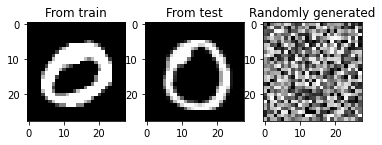

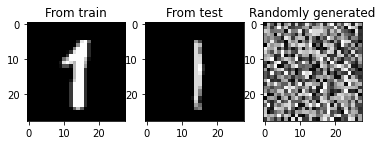

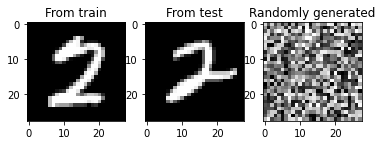

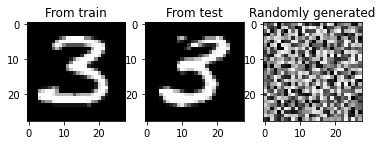

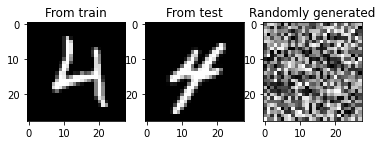

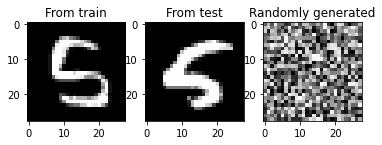

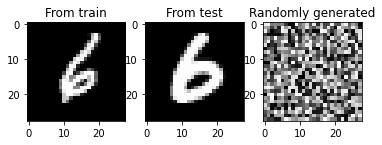

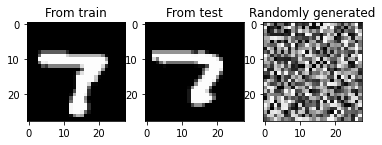

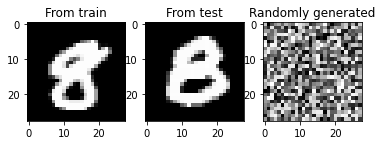

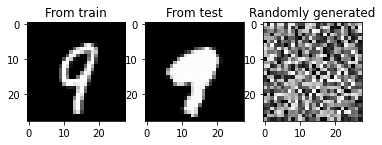

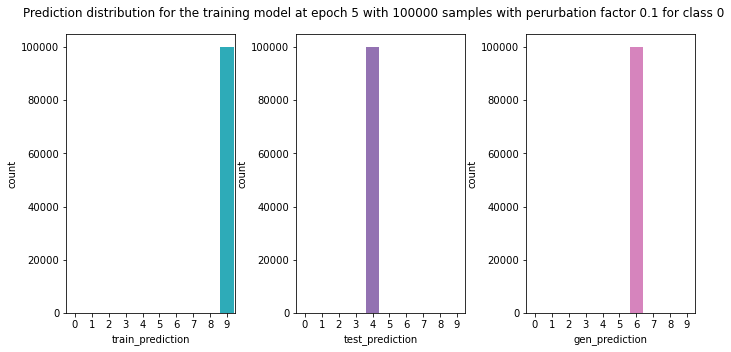

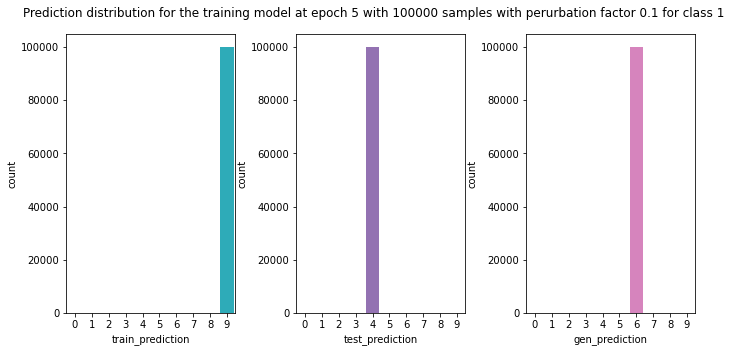

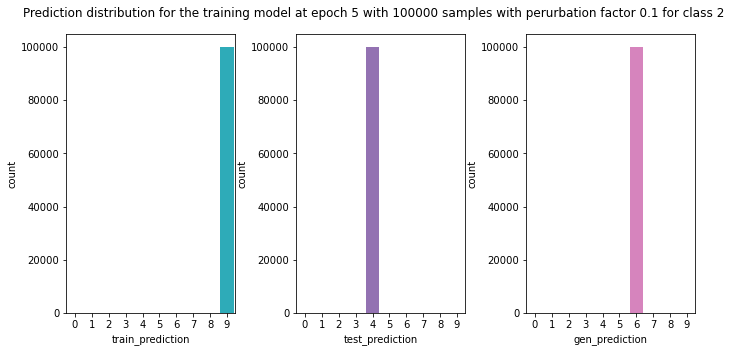

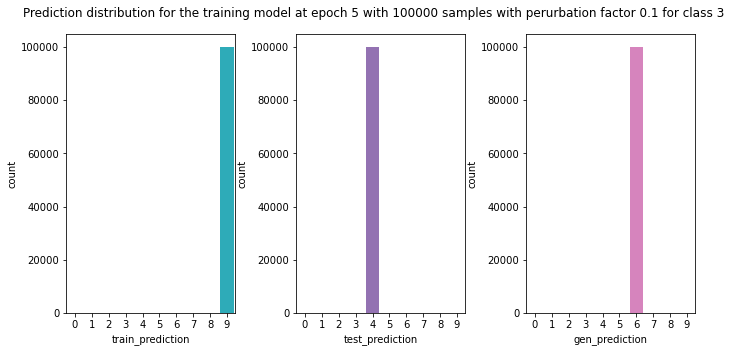

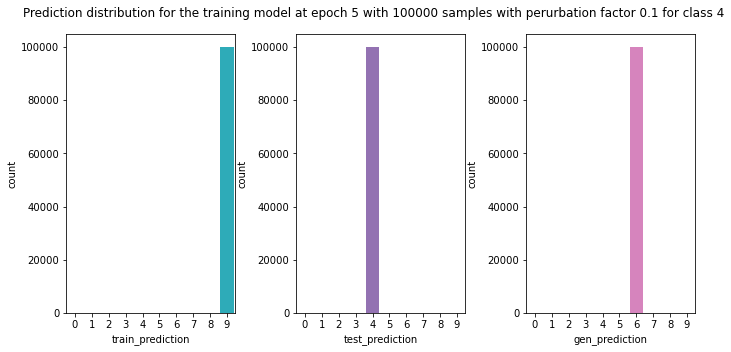

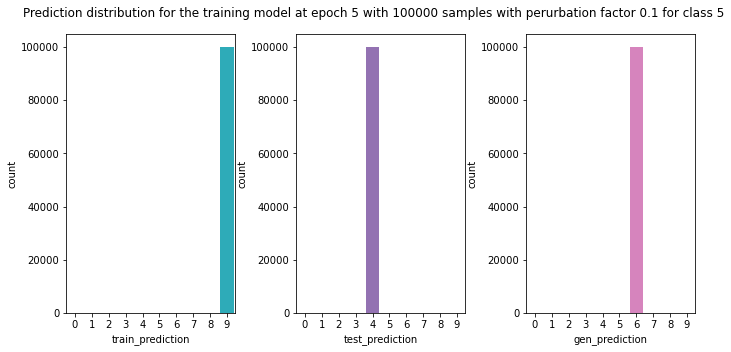

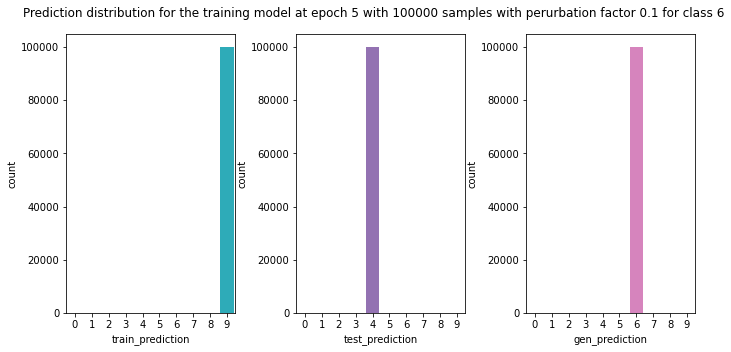

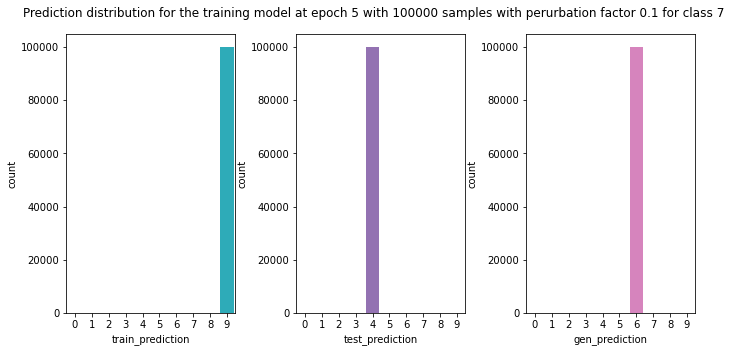

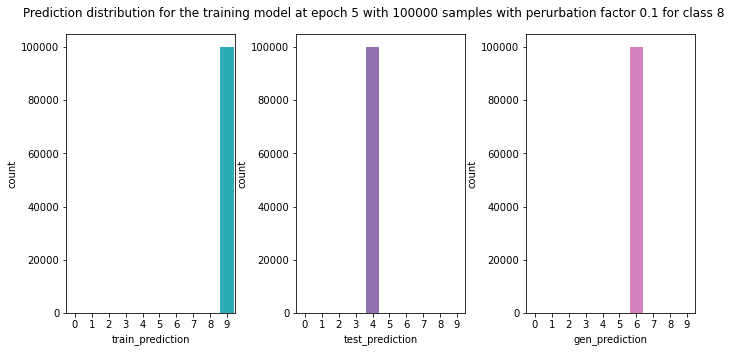

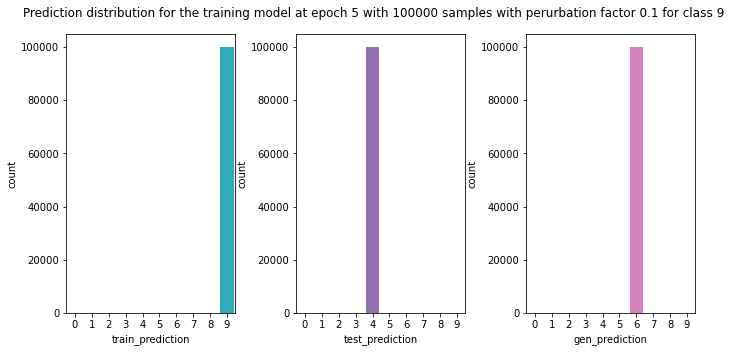

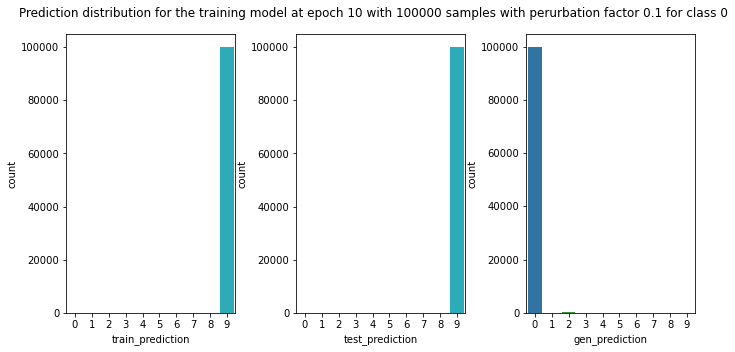

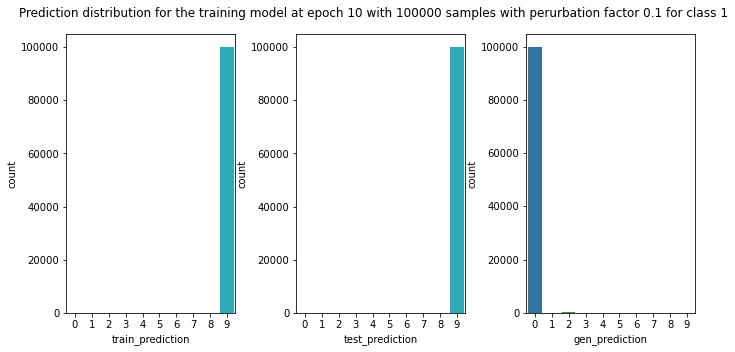

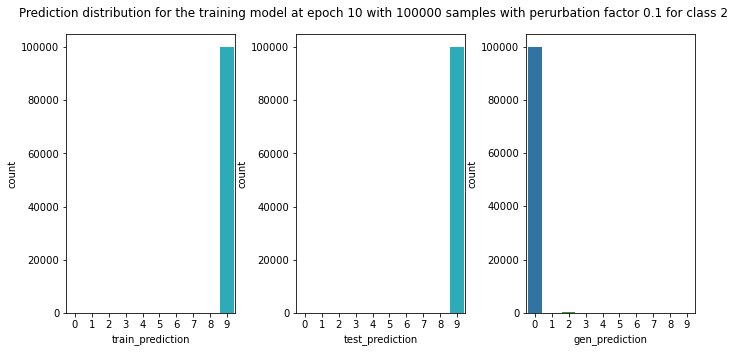

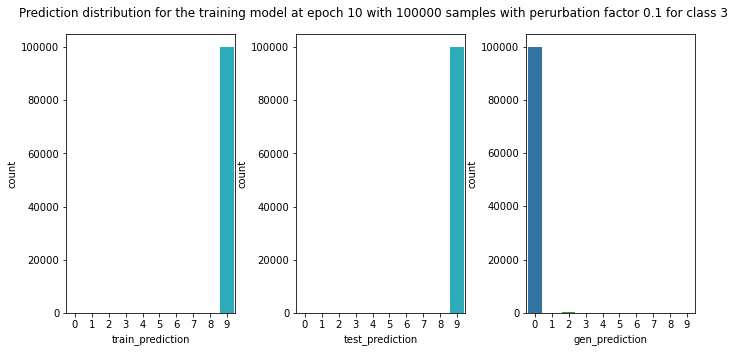

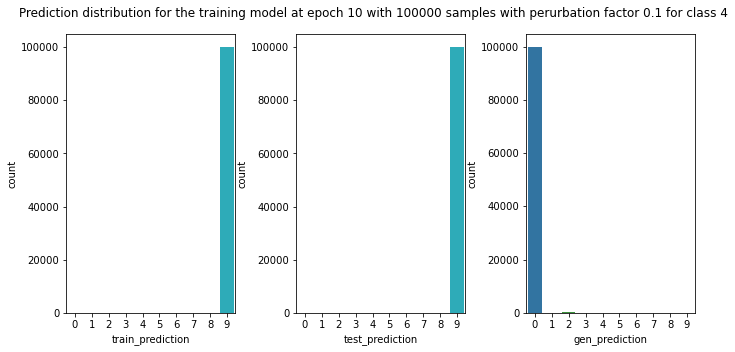

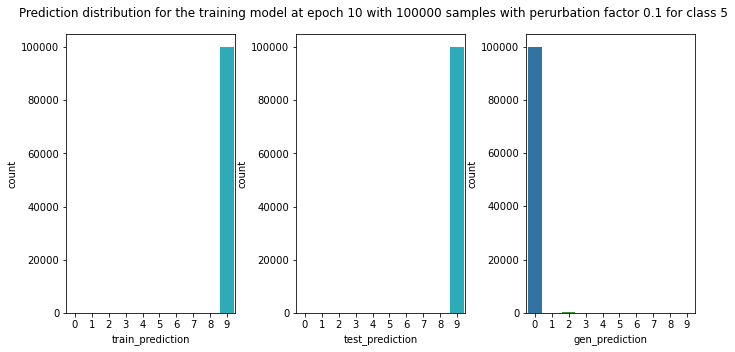

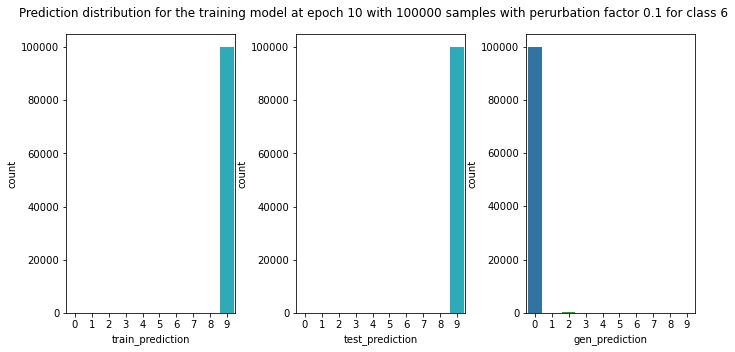

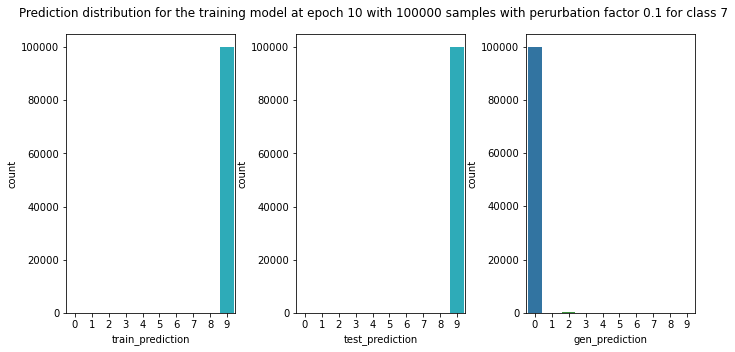

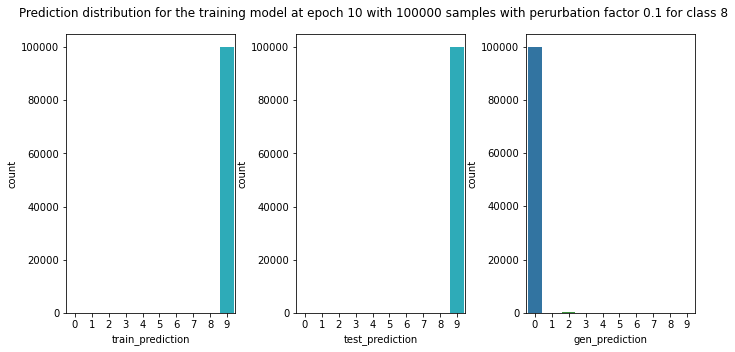

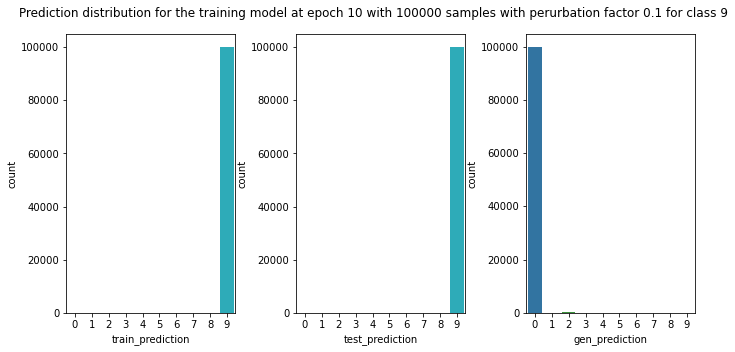

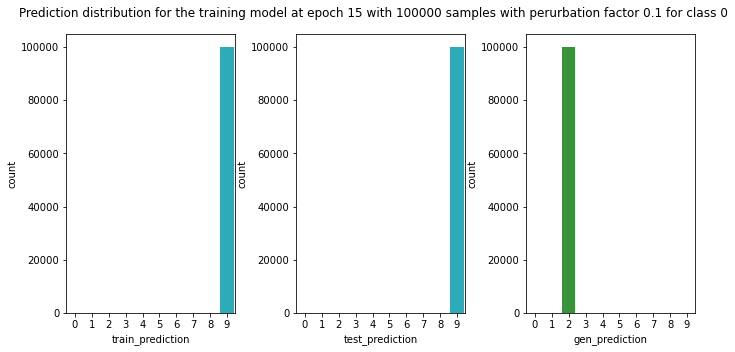

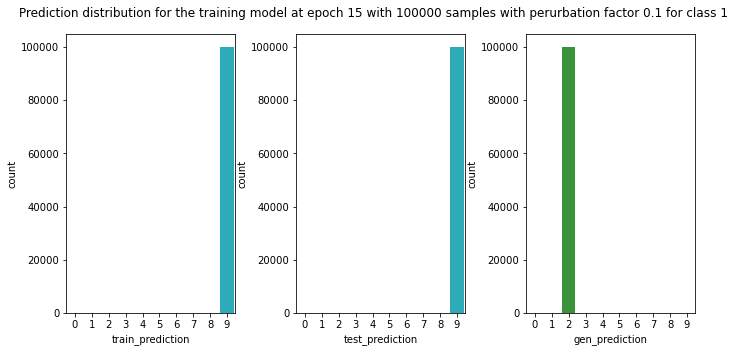

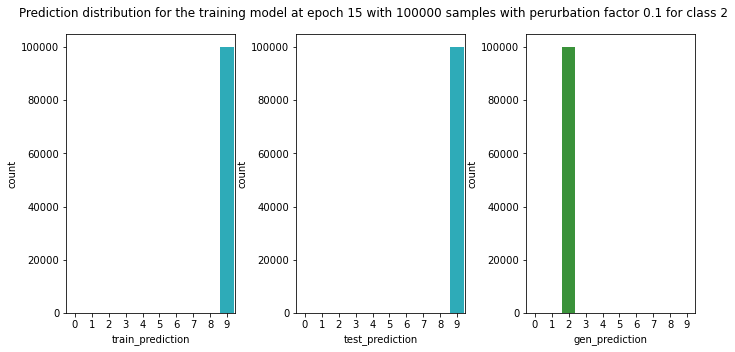

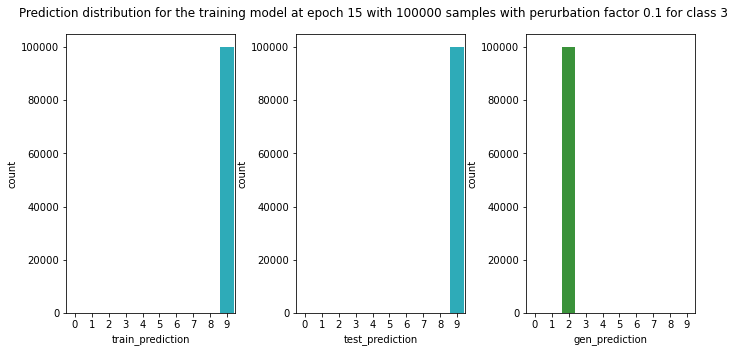

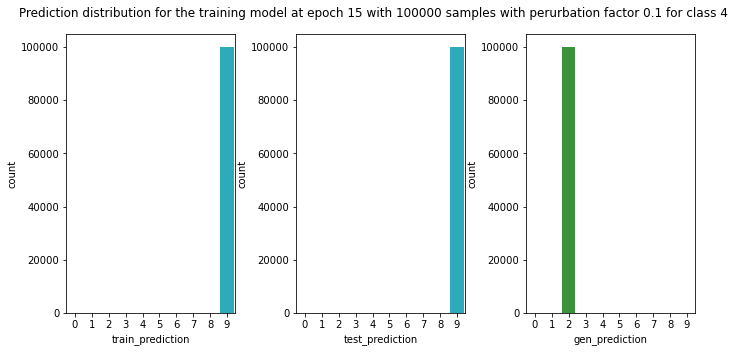

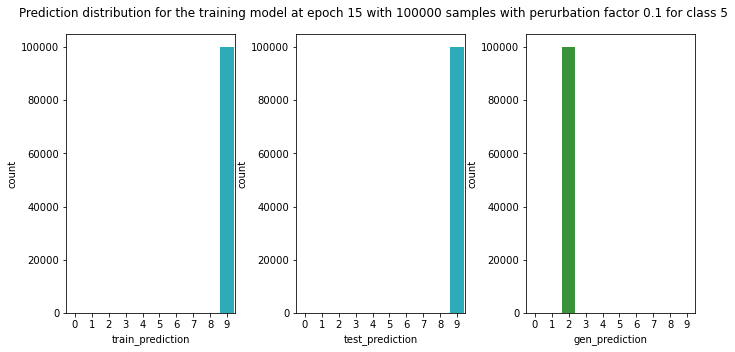

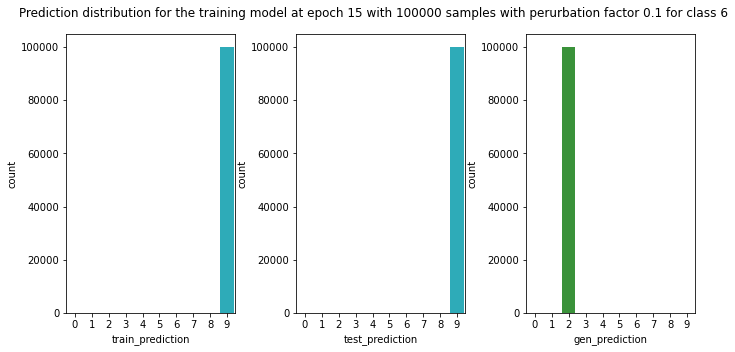

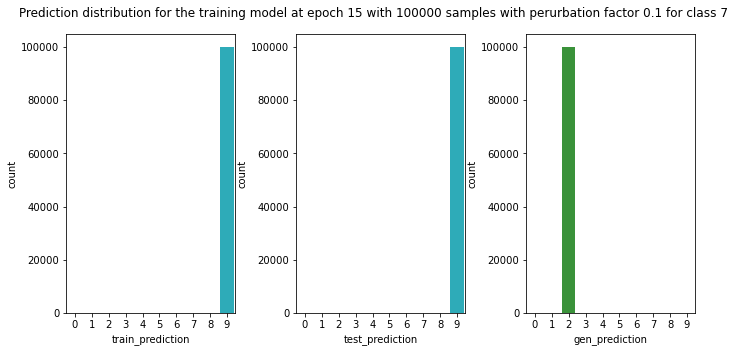

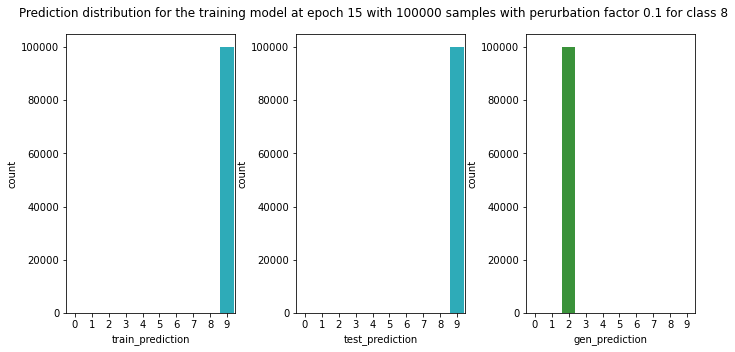

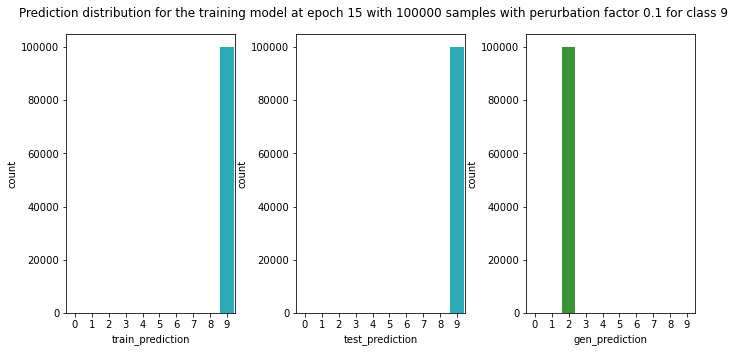

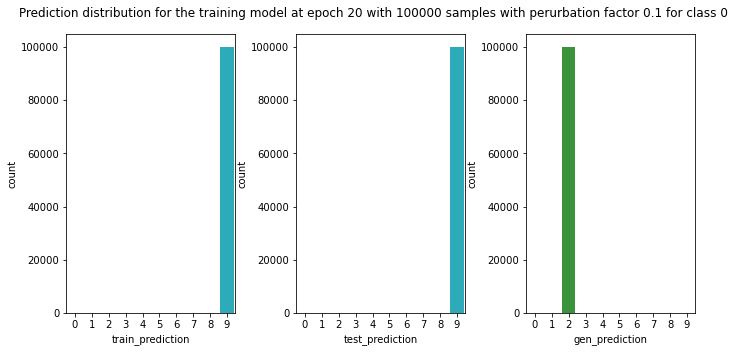

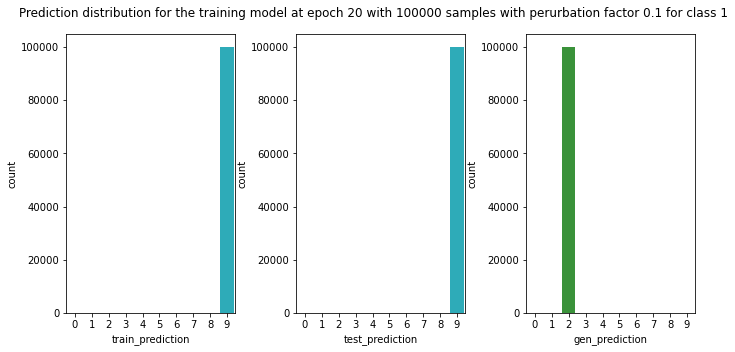

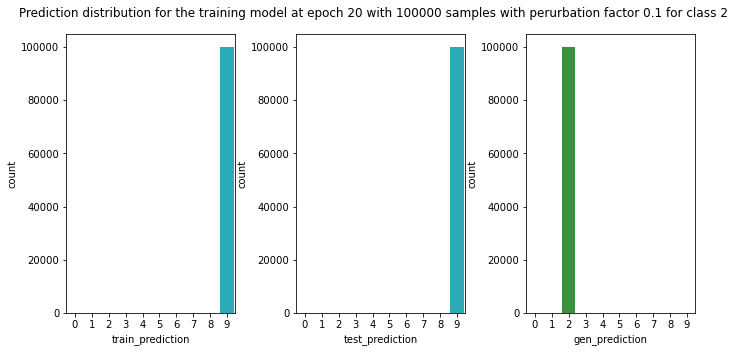

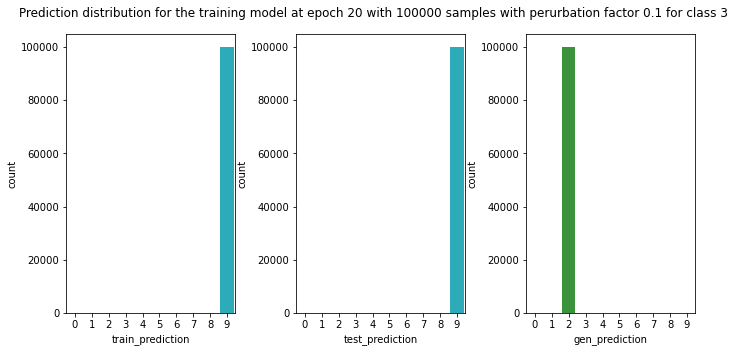

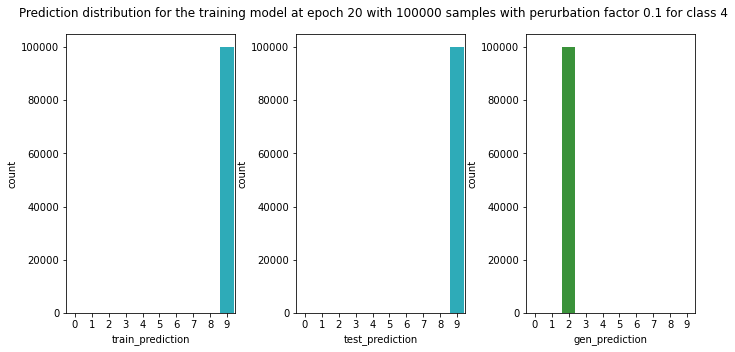

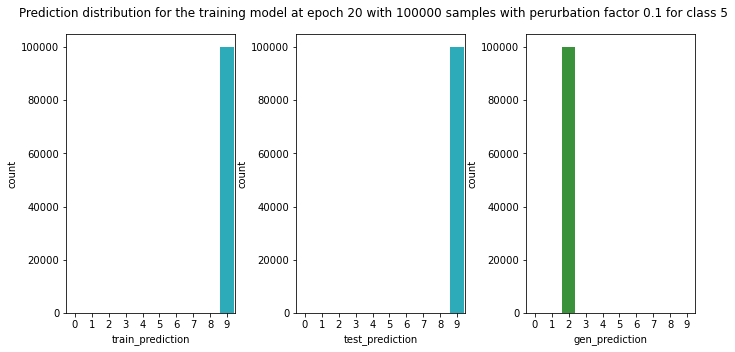

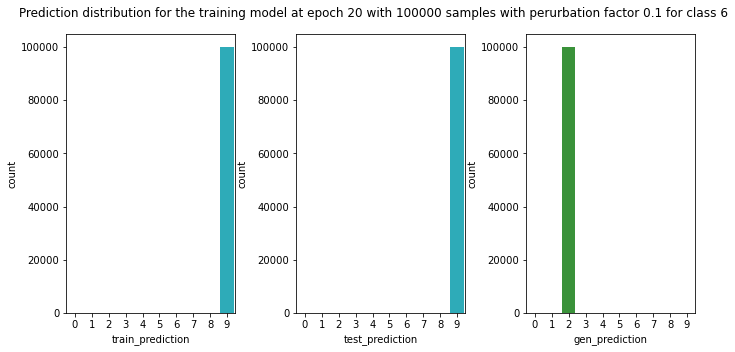

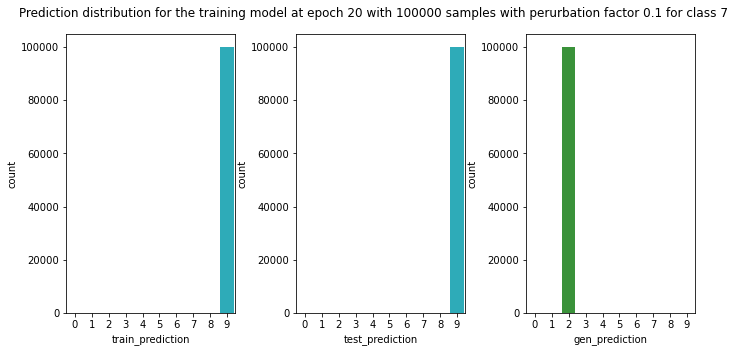

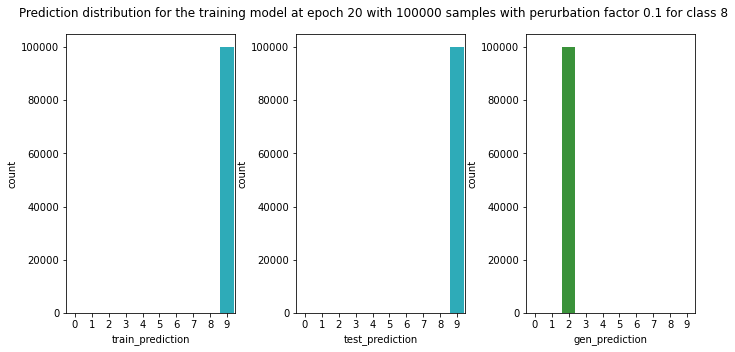

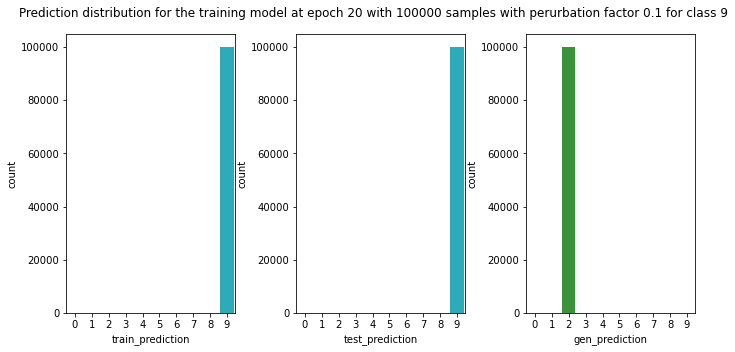

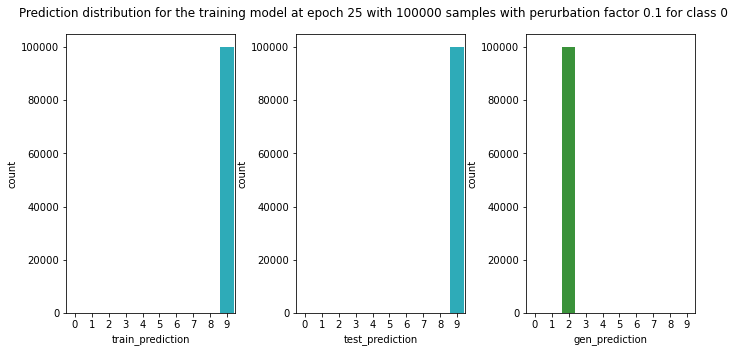

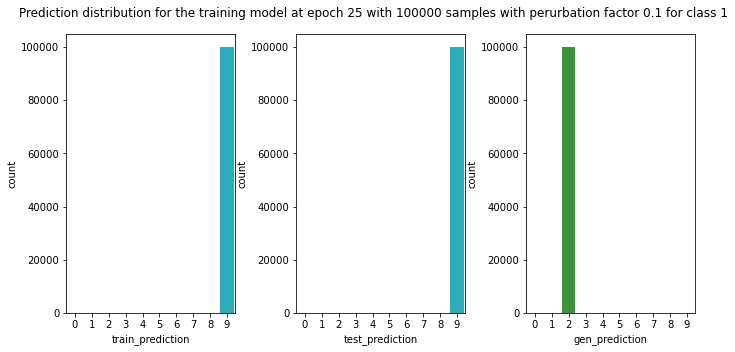

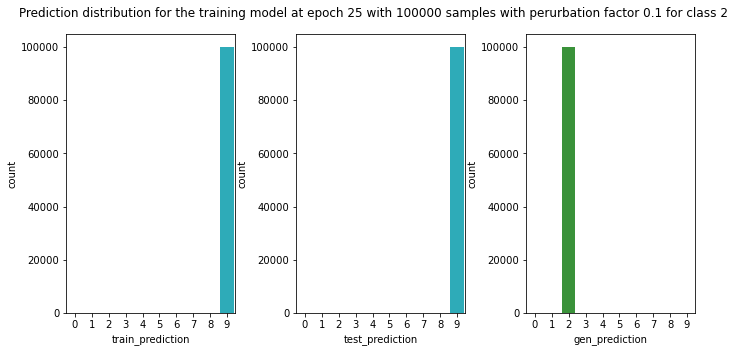

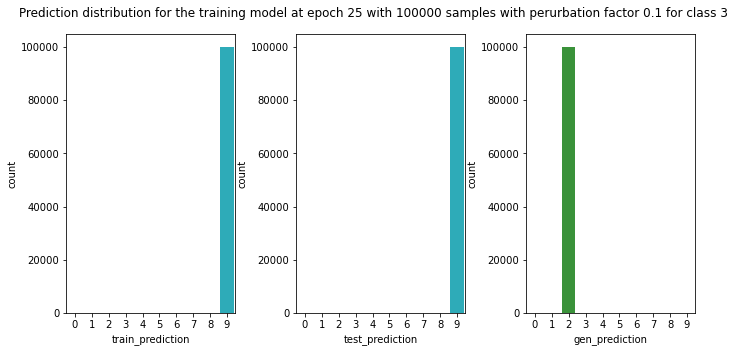

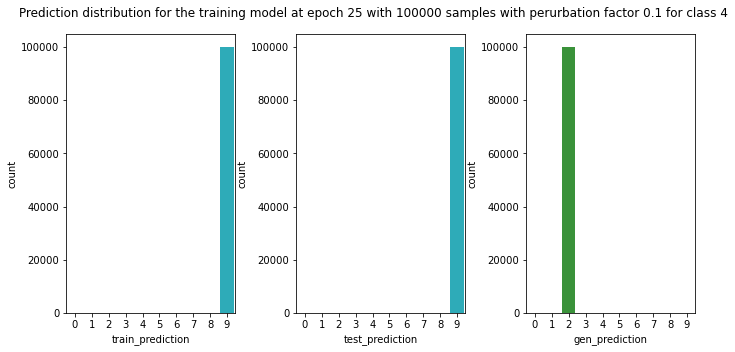

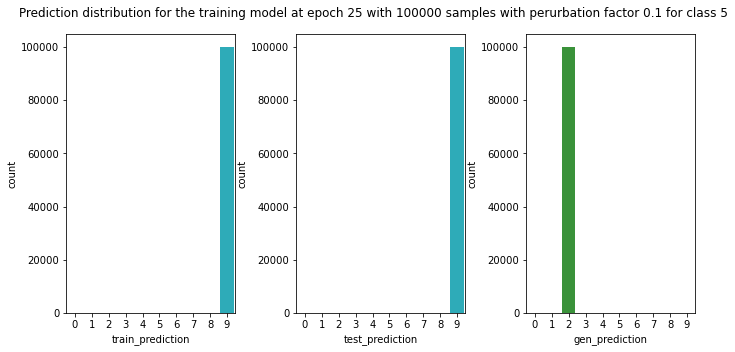

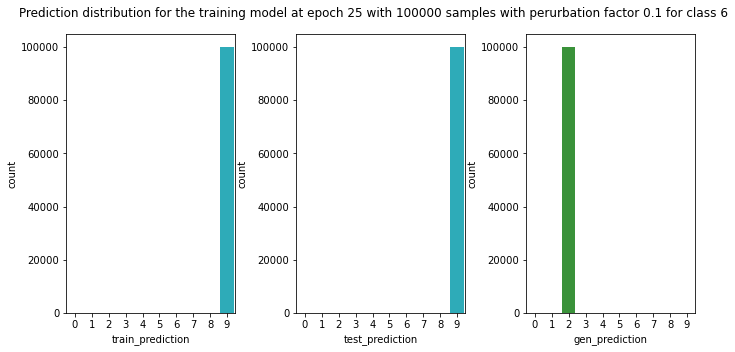

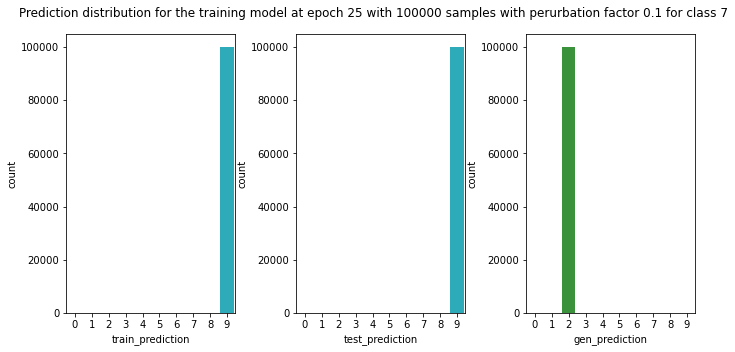

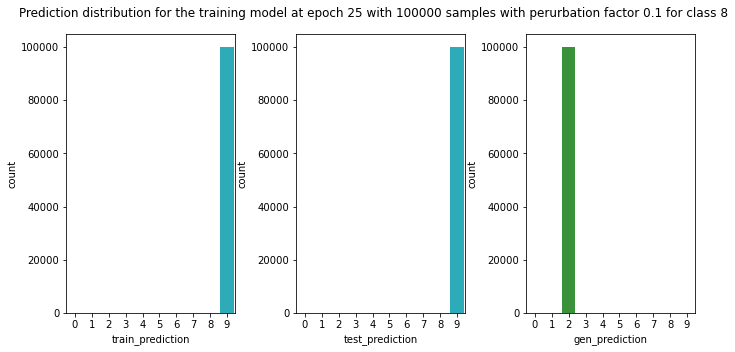

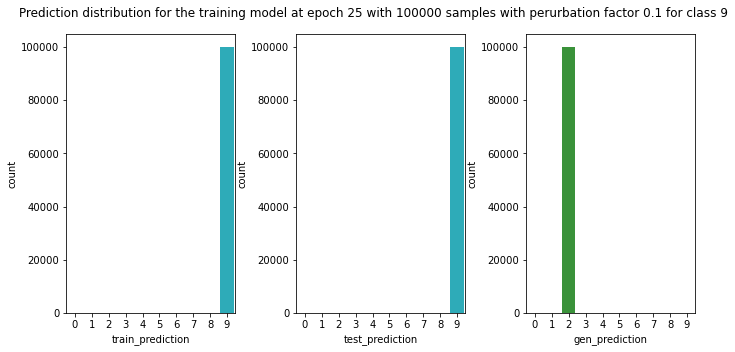

In [17]:
# Find the samples first
perturbation_factor = 0.1
num_sampling = 100000

samples = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    samples[picked_cls] = (extended_train, extended_test, extended_gen)


new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)


epochs = 25
optimizer = optim.Adadelta(new_model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
last_sorted_grads = defaultdict(list)

all_rows = []


EPOCH_CHECK_CYCLE = 5

model_name = new_model.model_savename()

for epoch in tqdm(range(1, epochs + 1)):
    new_model.register_gradient()
    new_model.train()
    target_log  = None # need to record the label to match with the gradient later
    for data, target in train_loader:
        target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = new_model(data.float())
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        optimizer.step()
    CFI_utils.test(new_model, device, test_loader)
    if epoch % EPOCH_CHECK_CYCLE == 0:
        torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")
        new_model.eval()
        
        for cls in samples:
            with torch.no_grad():
                train_outputs = new_model(samples[picked_cls][0].to(device)).argmax(dim=1)
                test_outputs = new_model(samples[picked_cls][1].to(device)).argmax(dim=1)
                gen_outputs = new_model(samples[picked_cls][2].to(device)).argmax(dim=1)

            draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for the training model at epoch {epoch} with {num_sampling} samples with perurbation factor {perturbation_factor} for class {cls}")
            
#         scheduler.step()
#     grad = CFI_utils.get_grad_each_label(new_model.gradient_log, 
#                                   target_log = target_log, 
#                                   layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
# #                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
#                                   labels = range(10))
    torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")

#     row_data = []
#     for label in range(10):
#         r = []
#         logging.info("After {} epoch:".format(epoch))
#         last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))


#         if epoch >= LAST_N_EPOCHS:
#             for k in [100, 200, 300, 400]:
#                 all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
#                 intersect = set.intersection(*all_top_k)
#                 logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(new_model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
#     modification_string += " -accuracy {}-".format( correct/total)
#     print(modification_string)
    print(" -accuracy {}-".format( correct/total))

  0%|                                                                                                                                                                                                              | 0/25 [00:00<?, ?it/s]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
  4%|███████▉                                                                                                                                                                                              | 1/25 [00:36<14:31, 36.29s/it]


Test set: Average loss: 2.2773, Accuracy: 2788/10000 (28%)



  8%|███████████████▊                                                                                                                                                                                      | 2/25 [00:48<08:33, 22.34s/it]


Test set: Average loss: 2.2463, Accuracy: 3486/10000 (35%)



 12%|███████████████████████▊                                                                                                                                                                              | 3/25 [01:01<06:33, 17.89s/it]


Test set: Average loss: 2.1964, Accuracy: 4188/10000 (42%)



 16%|███████████████████████████████▋                                                                                                                                                                      | 4/25 [01:14<05:33, 15.87s/it]


Test set: Average loss: 2.1075, Accuracy: 4989/10000 (50%)


Test set: Average loss: 1.9487, Accuracy: 5557/10000 (56%)



 20%|███████████████████████████████████████▌                                                                                                                                                              | 5/25 [01:31<05:26, 16.31s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 24%|███████████████████████████████████████████████▌                                                                                                                                                      | 6/25 [01:43<04:44, 14.97s/it]


Test set: Average loss: 1.6980, Accuracy: 6246/10000 (62%)



 28%|███████████████████████████████████████████████████████▍                                                                                                                                              | 7/25 [01:57<04:25, 14.75s/it]


Test set: Average loss: 1.3973, Accuracy: 6875/10000 (69%)



 32%|███████████████████████████████████████████████████████████████▎                                                                                                                                      | 8/25 [02:10<03:59, 14.09s/it]


Test set: Average loss: 1.1346, Accuracy: 7422/10000 (74%)



 36%|███████████████████████████████████████████████████████████████████████▎                                                                                                                              | 9/25 [02:23<03:37, 13.58s/it]


Test set: Average loss: 0.9407, Accuracy: 7748/10000 (77%)


Test set: Average loss: 0.8063, Accuracy: 8020/10000 (80%)



 40%|██████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 10/25 [02:39<03:36, 14.44s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 44%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                                              | 11/25 [02:51<03:13, 13.83s/it]


Test set: Average loss: 0.7121, Accuracy: 8221/10000 (82%)



 48%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                      | 12/25 [03:04<02:54, 13.42s/it]


Test set: Average loss: 0.6439, Accuracy: 8322/10000 (83%)



 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                              | 13/25 [03:16<02:37, 13.12s/it]


Test set: Average loss: 0.5911, Accuracy: 8455/10000 (85%)



 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 14/25 [03:29<02:22, 12.95s/it]


Test set: Average loss: 0.5497, Accuracy: 8551/10000 (86%)


Test set: Average loss: 0.5159, Accuracy: 8642/10000 (86%)



 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 15/25 [03:45<02:18, 13.88s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                       | 16/25 [03:57<02:01, 13.46s/it]


Test set: Average loss: 0.4875, Accuracy: 8692/10000 (87%)



 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 17/25 [04:10<01:45, 13.16s/it]


Test set: Average loss: 0.4631, Accuracy: 8755/10000 (88%)



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 18/25 [04:23<01:31, 13.08s/it]


Test set: Average loss: 0.4429, Accuracy: 8789/10000 (88%)



 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 19/25 [04:35<01:17, 12.96s/it]


Test set: Average loss: 0.4257, Accuracy: 8827/10000 (88%)


Test set: Average loss: 0.4101, Accuracy: 8864/10000 (89%)



 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 20/25 [04:52<01:09, 13.93s/it]C:\Users\xxjtr\anaconda3\envs\venv39\lib\site-packages\torch\nn\modules\module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 21/25 [05:04<00:53, 13.48s/it]


Test set: Average loss: 0.3965, Accuracy: 8889/10000 (89%)



 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 22/25 [05:17<00:39, 13.19s/it]


Test set: Average loss: 0.3849, Accuracy: 8913/10000 (89%)



 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 23/25 [05:29<00:26, 13.03s/it]


Test set: Average loss: 0.3754, Accuracy: 8931/10000 (89%)



 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 24/25 [05:42<00:12, 12.85s/it]


Test set: Average loss: 0.3657, Accuracy: 8954/10000 (90%)


Test set: Average loss: 0.3576, Accuracy: 8972/10000 (90%)



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [05:58<00:00, 14.33s/it]


 -accuracy 0.8972-


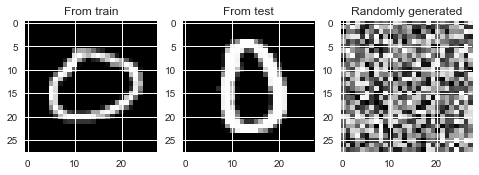

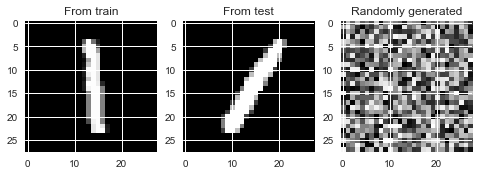

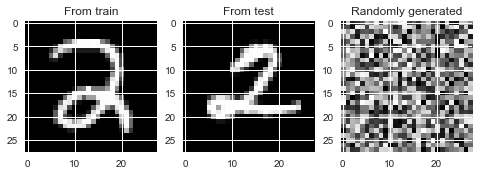

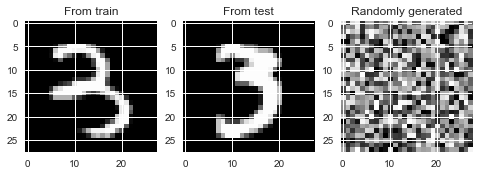

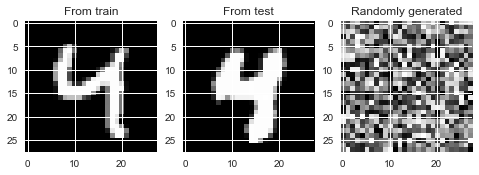

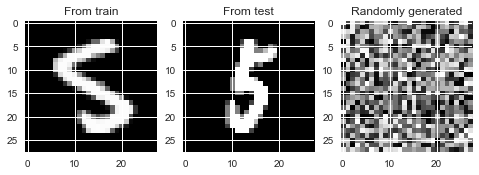

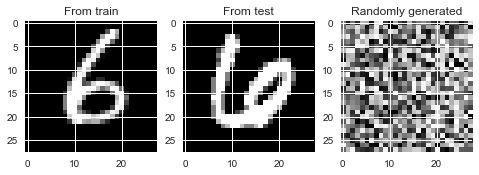

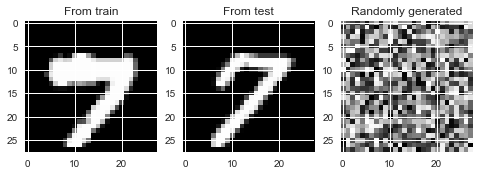

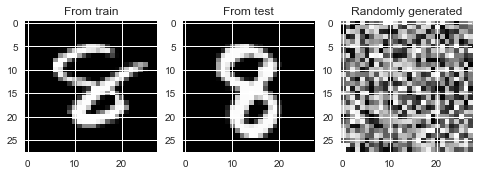

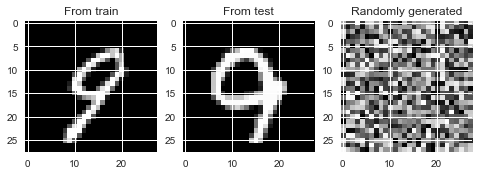

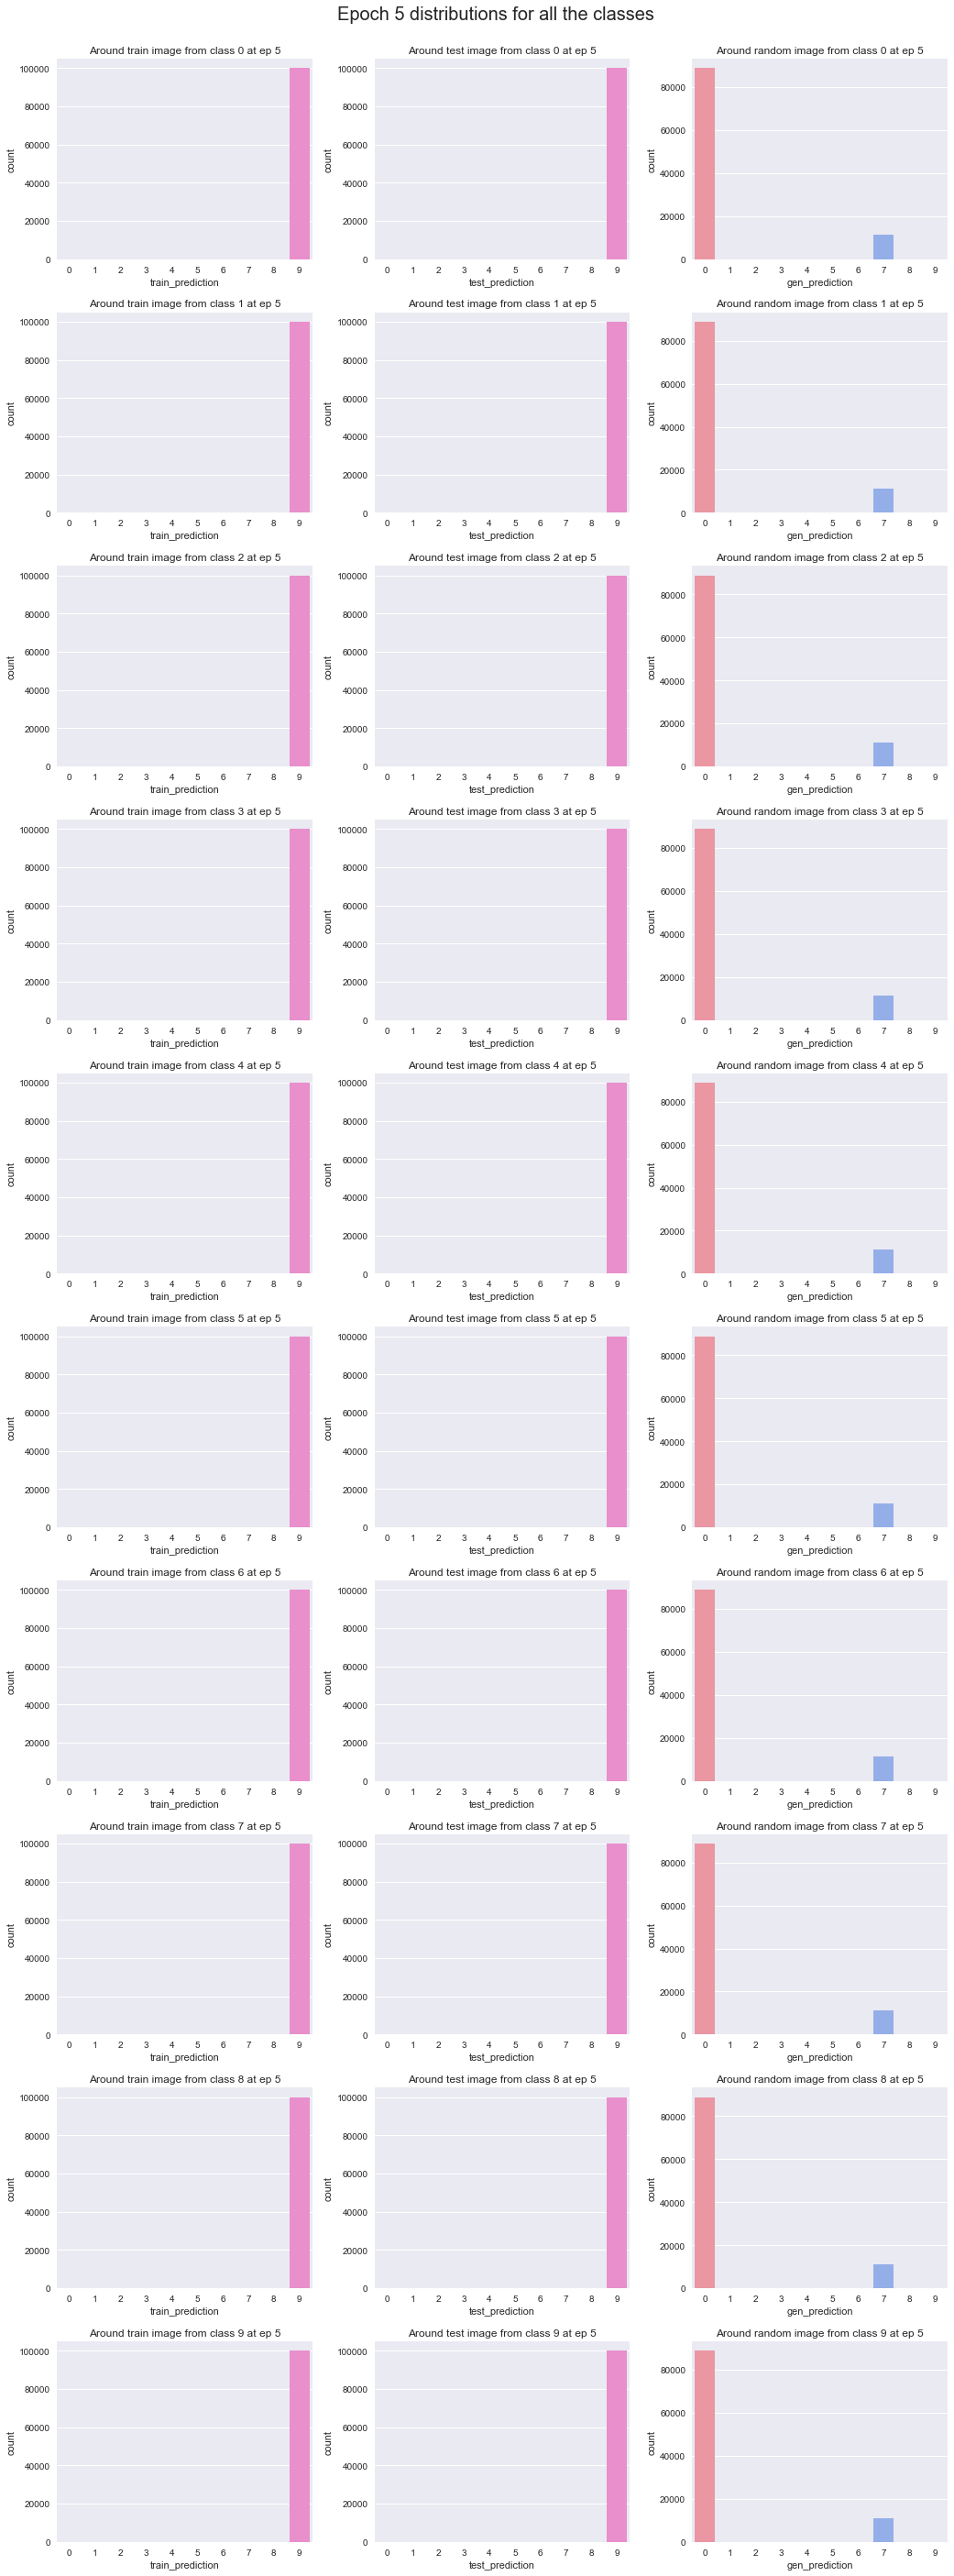

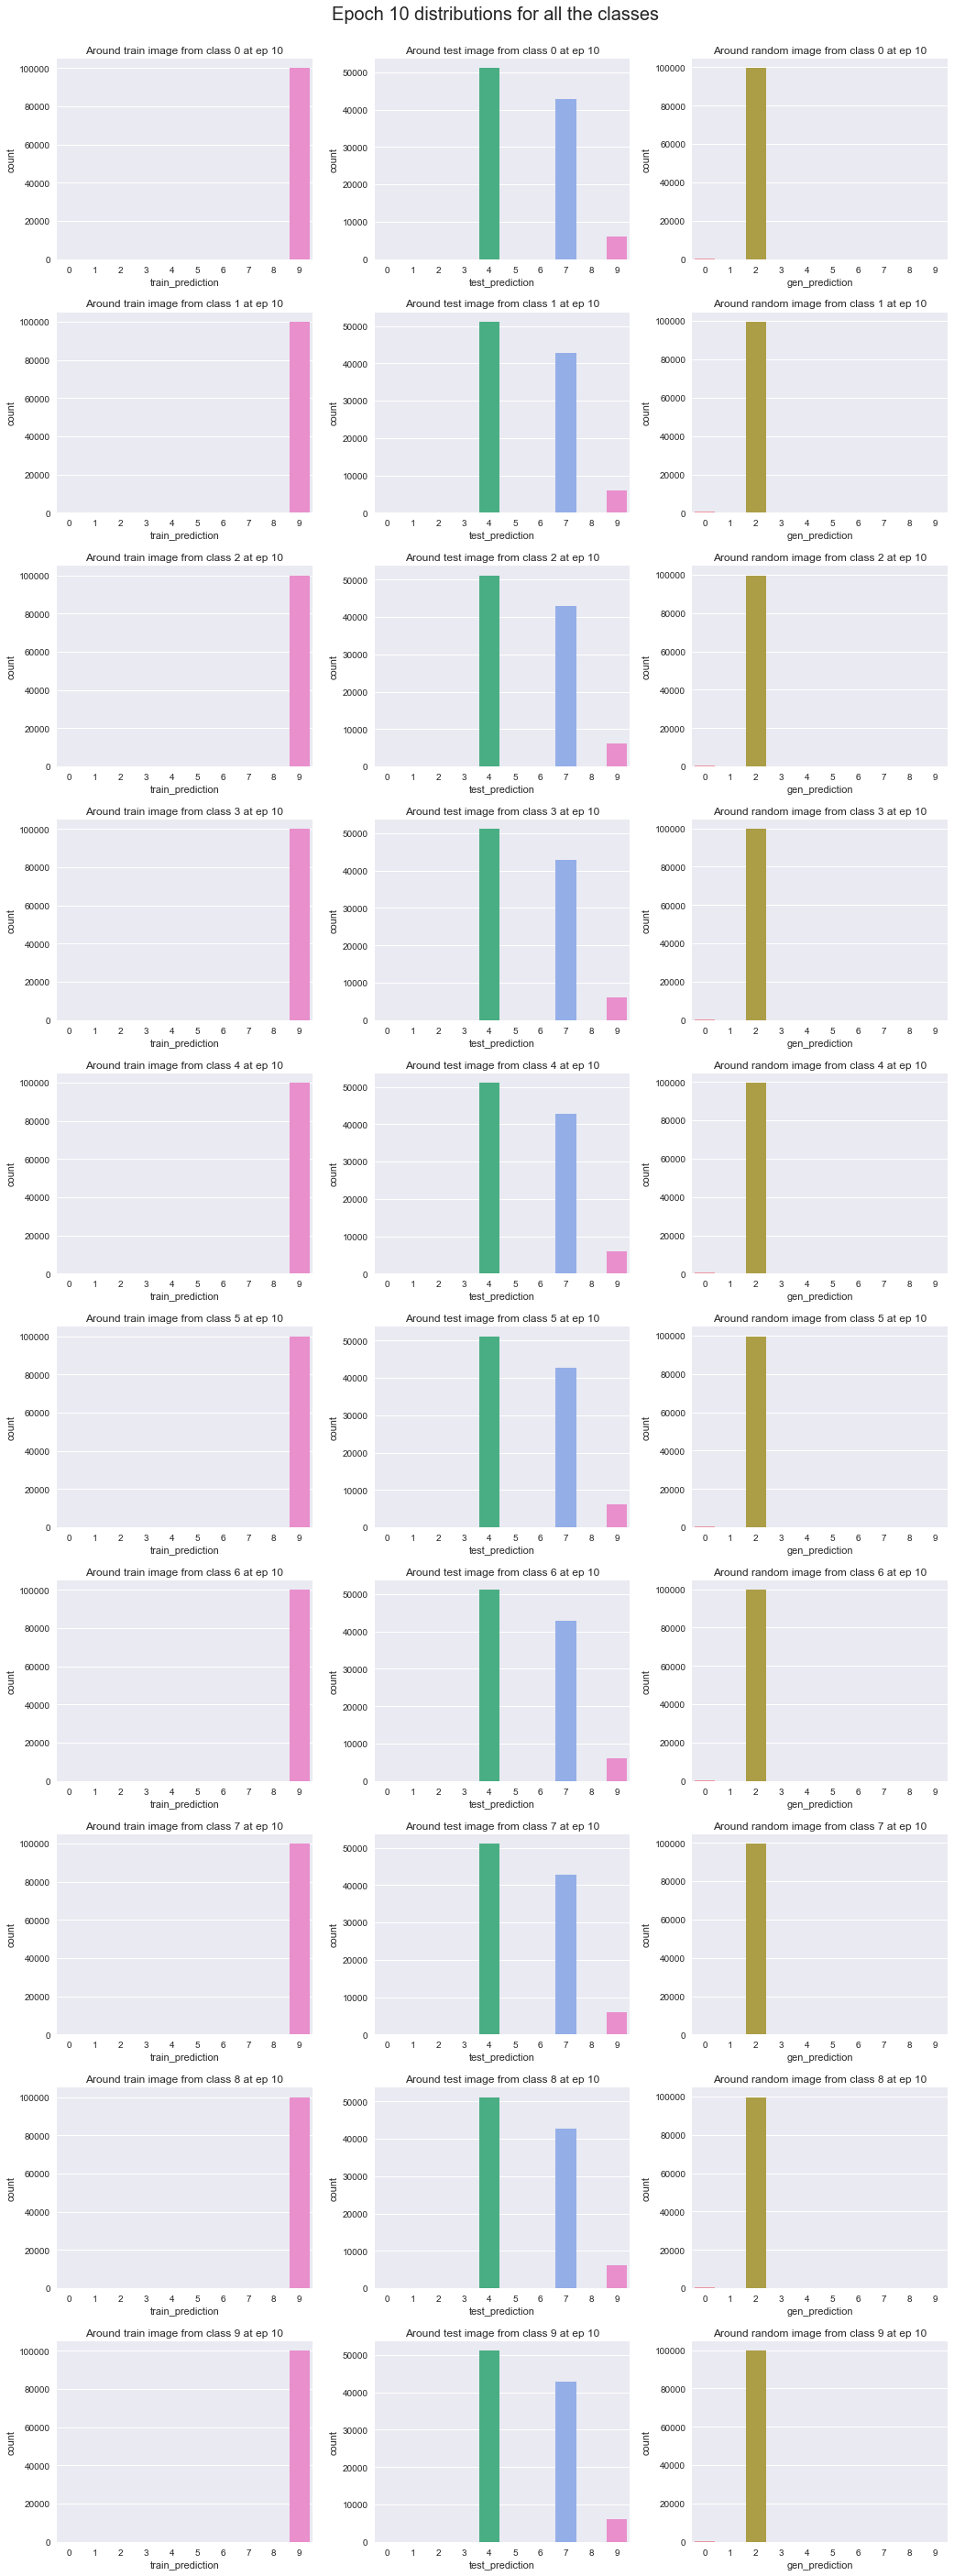

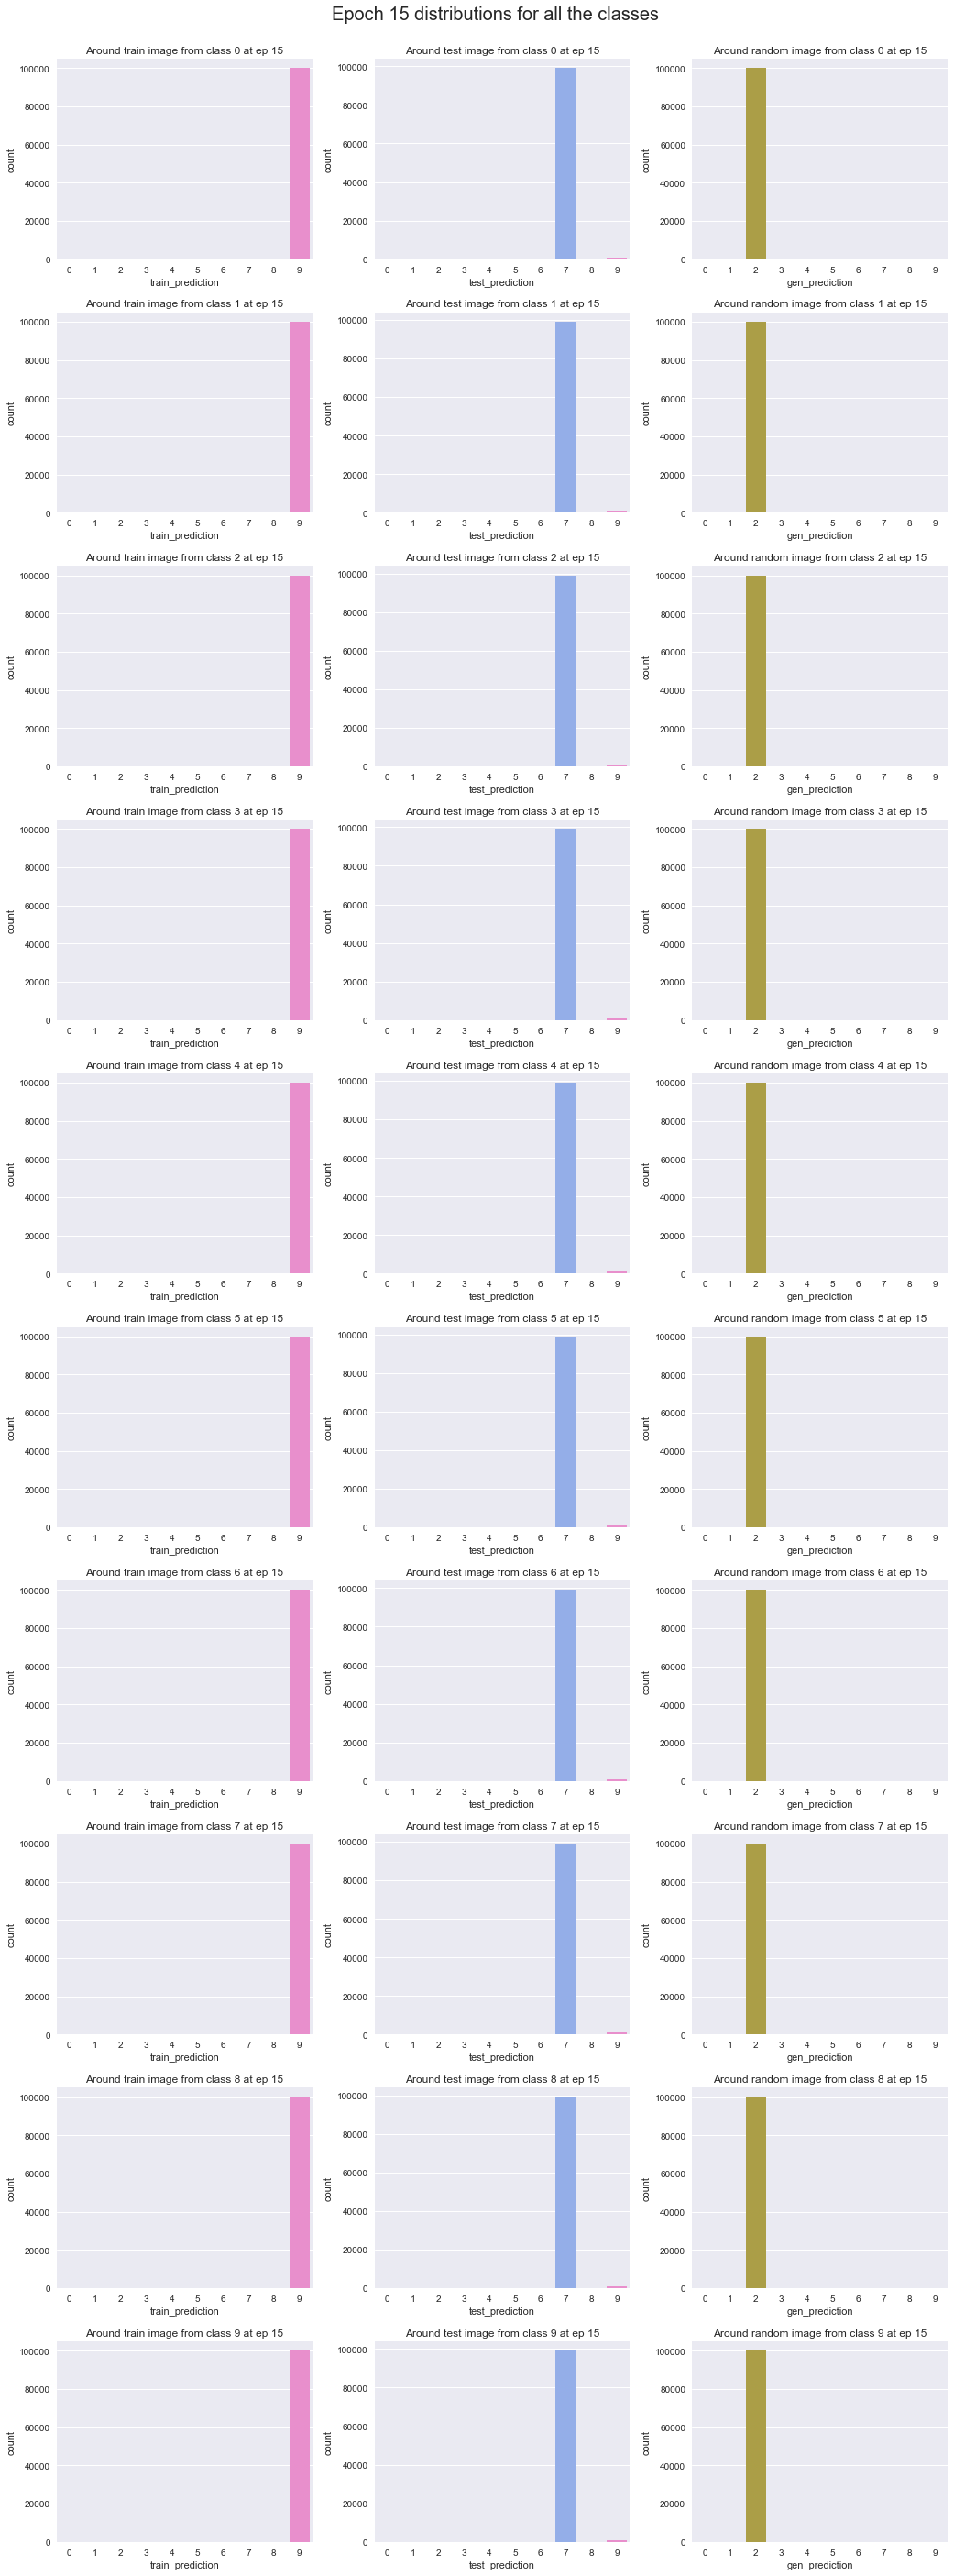

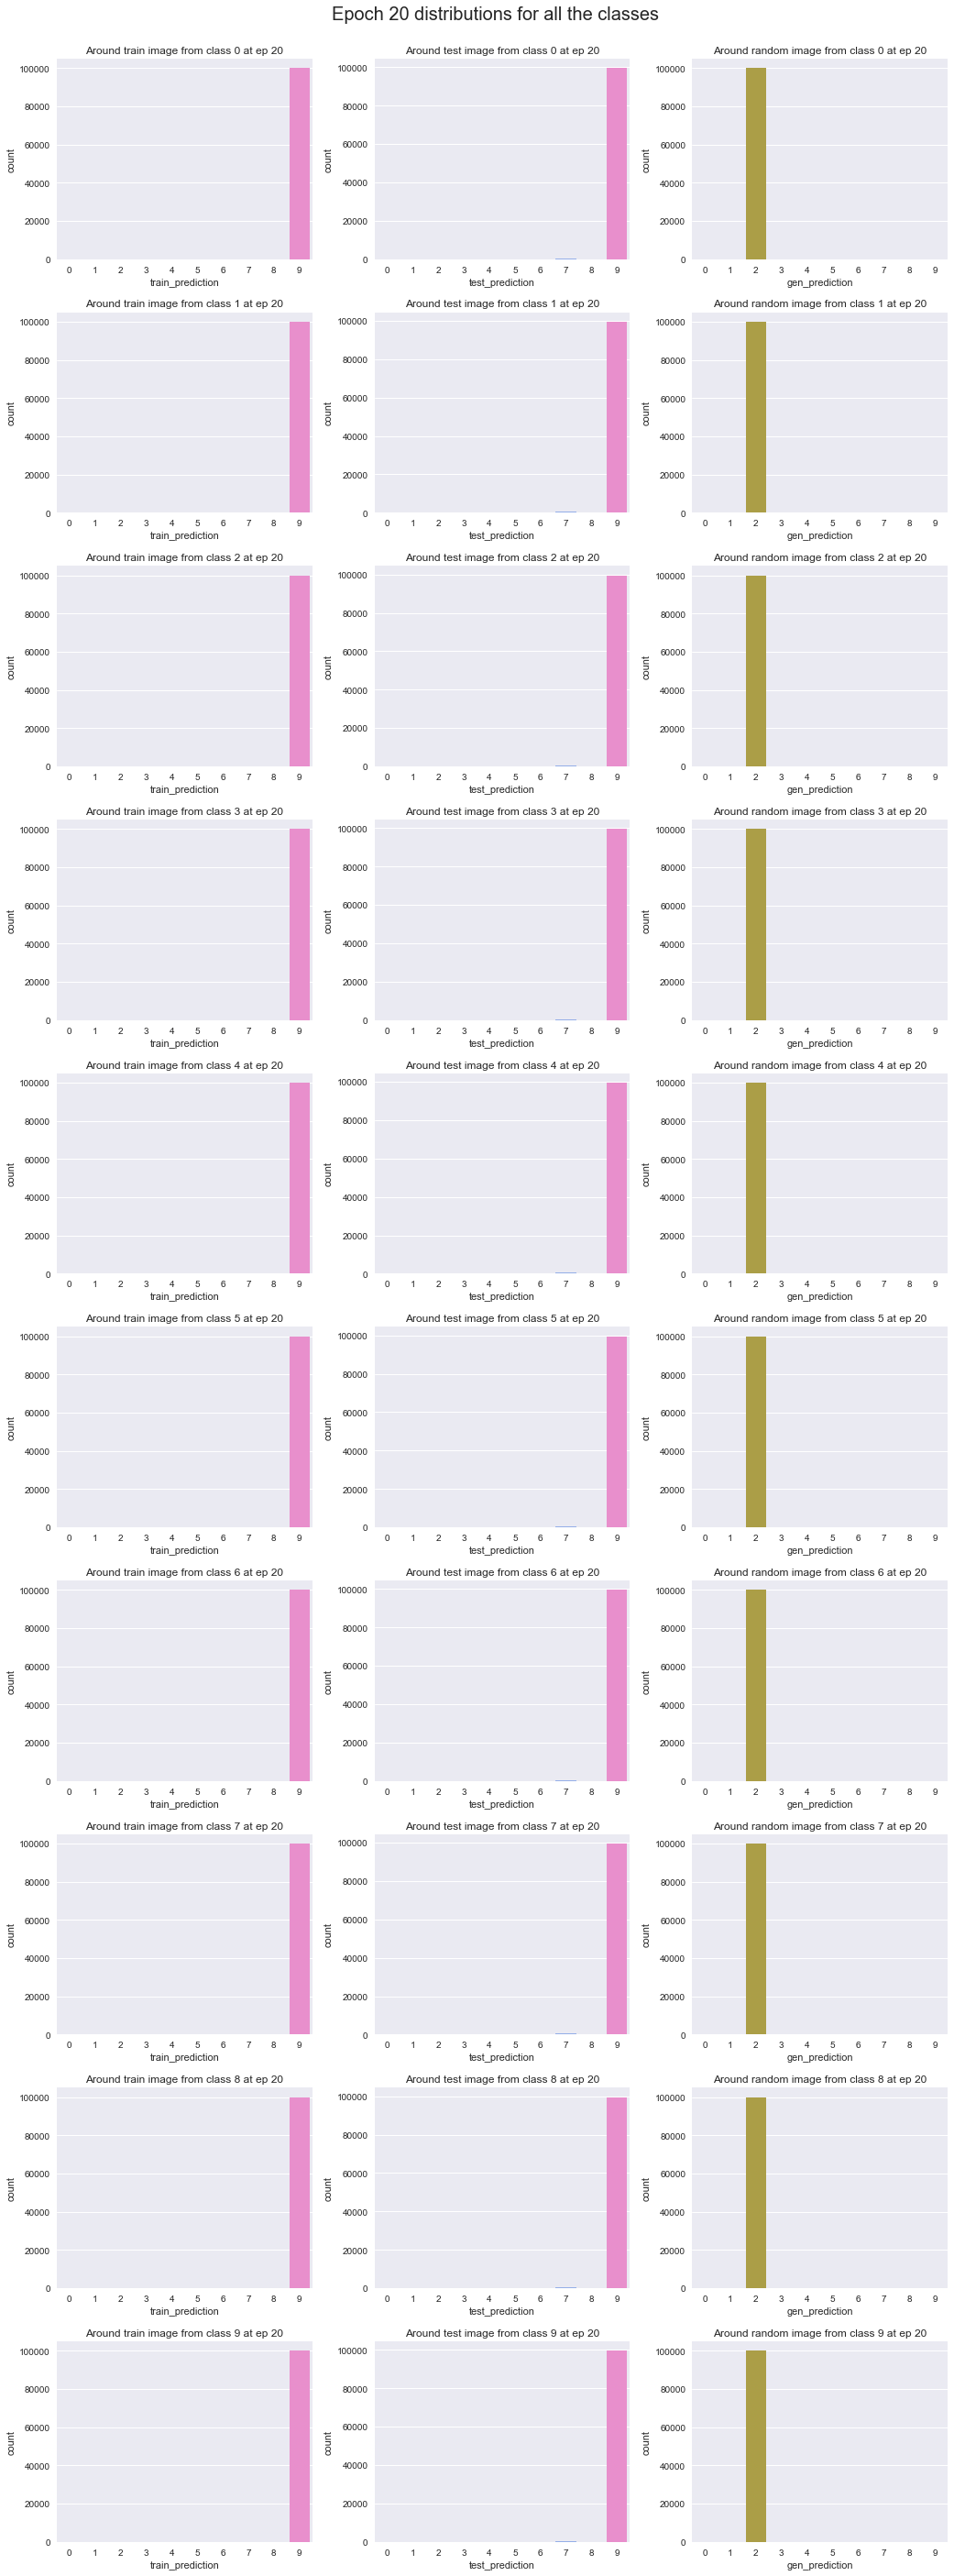

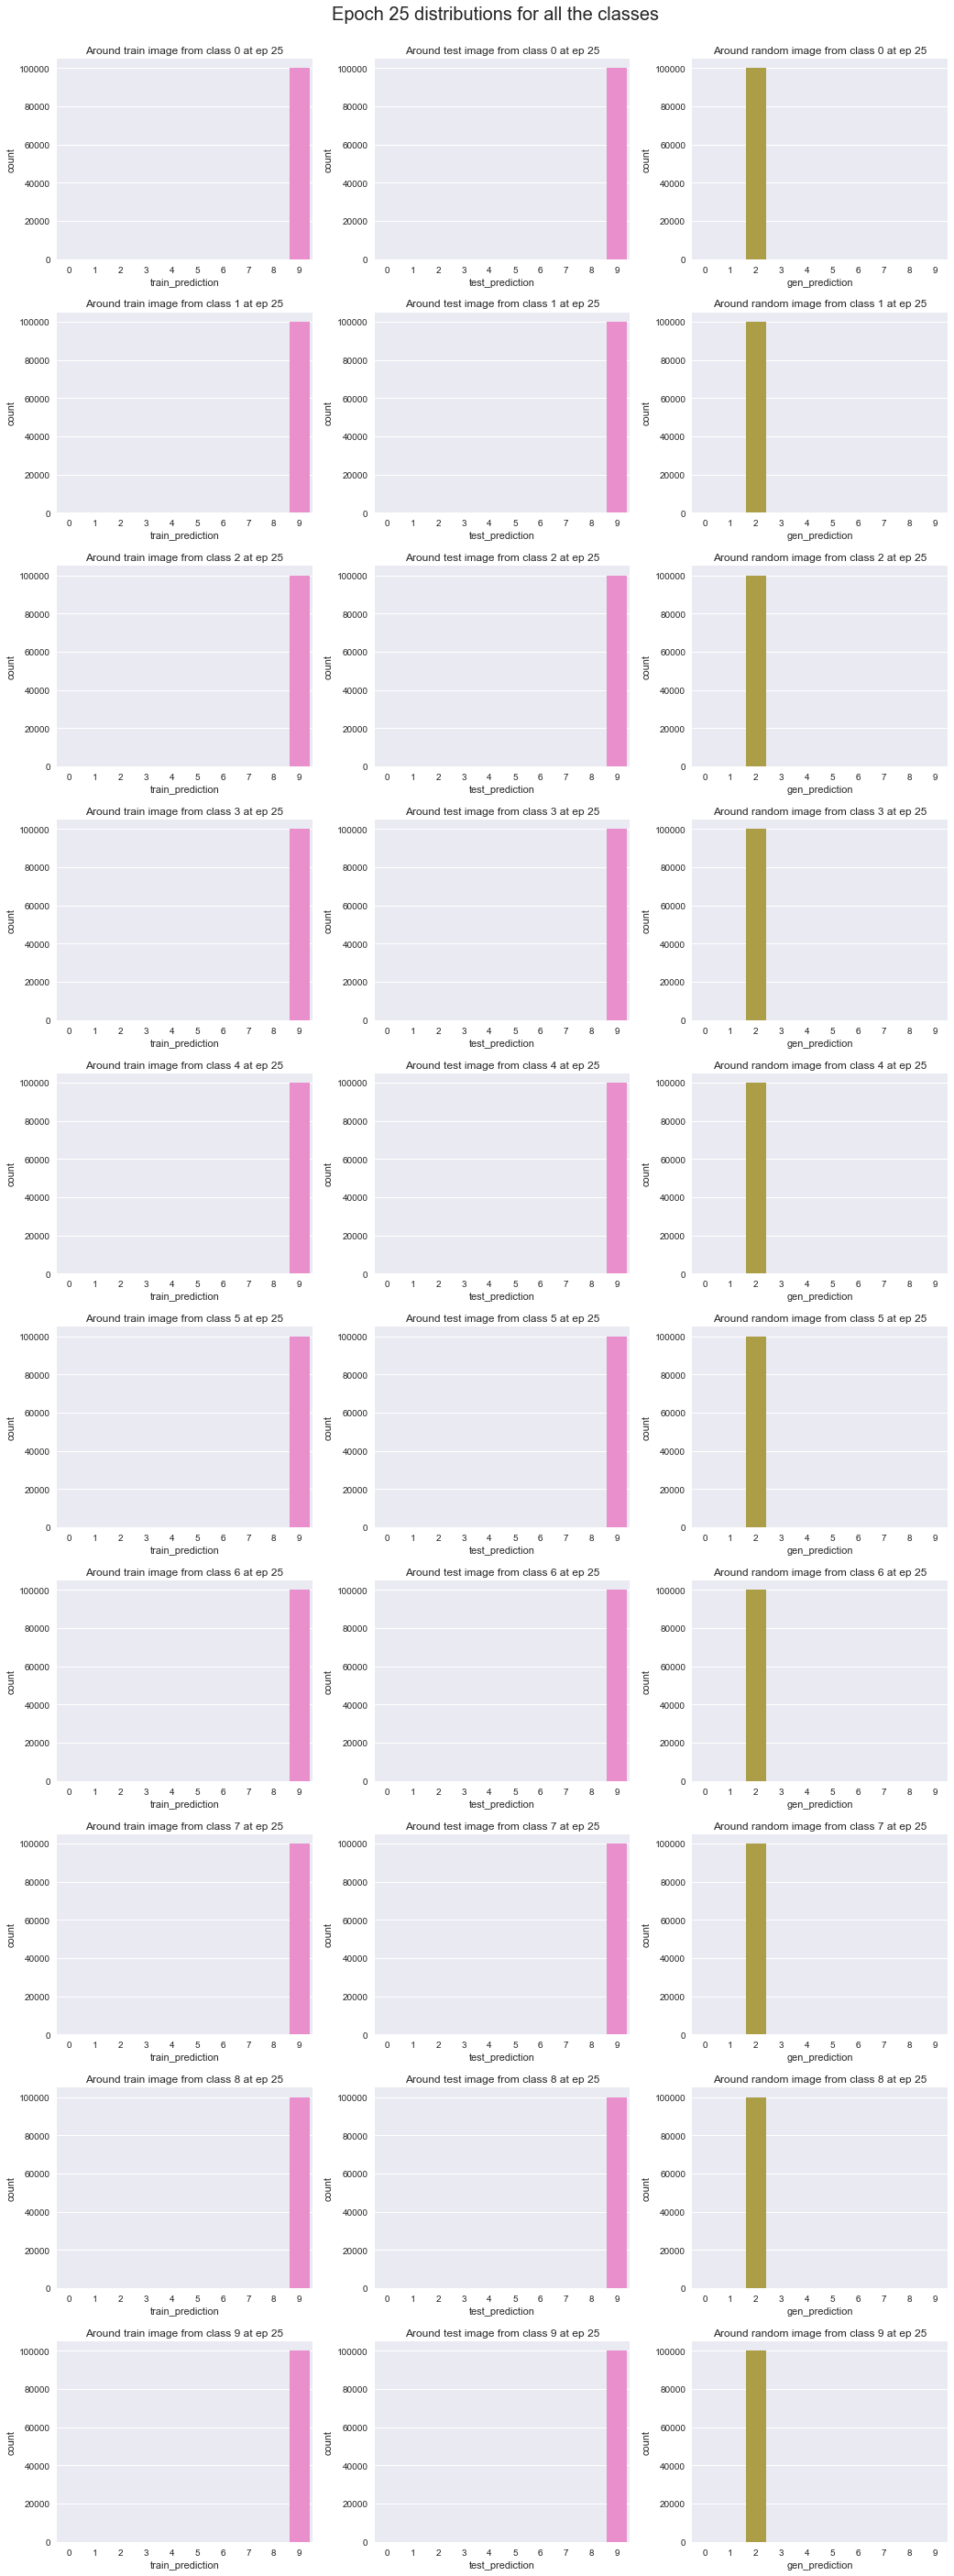

In [21]:
# Big figure


perturbation_factor = 0.1
num_sampling = 100000

samples = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    samples[picked_cls] = (extended_train, extended_test, extended_gen)


new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)


epochs = 25
optimizer = optim.Adadelta(new_model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma = 0.7)
last_sorted_grads = defaultdict(list)

all_rows = []


EPOCH_CHECK_CYCLE = 5

model_name = new_model.model_savename()

for epoch in tqdm(range(1, epochs + 1)):
    new_model.register_gradient()
    new_model.train()
    target_log  = None # need to record the label to match with the gradient later
    for data, target in train_loader:
        target_log = np.concatenate((target_log, target), axis = 0) if target_log is not None else target
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = new_model(data.float())
        loss = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss.backward()
        optimizer.step()
    CFI_utils.test(new_model, device, test_loader)
    if epoch % EPOCH_CHECK_CYCLE == 0:
        torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")
        new_model.eval()
        
        f, axarr = plt.subplots(10, 3,  figsize=(15, 40))
        plt.style.use('seaborn')
        f.tight_layout(pad=4)
        f.subplots_adjust(top=0.96)
        plt.suptitle(f"Epoch {epoch} distributions for all the classes",fontsize=20)
        for cls in samples:
            with torch.no_grad():
                train_outputs = new_model(samples[picked_cls][0].to(device)).argmax(dim=1)
                test_outputs = new_model(samples[picked_cls][1].to(device)).argmax(dim=1)
                gen_outputs = new_model(samples[picked_cls][2].to(device)).argmax(dim=1)
            train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
            test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
            gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
            sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
            sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
            sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
            axarr[cls][0].set_title(f'Around train image from class {cls} at ep {epoch}')
            axarr[cls][1].set_title(f'Around test image from class {cls} at ep {epoch}')
            axarr[cls][2].set_title(f'Around random image from class {cls} at ep {epoch}')

#             draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for the training model at epoch {epoch} with {num_sampling} samples with perurbation factor {perturbation_factor} for class {cls}")
            
#         scheduler.step()
#     grad = CFI_utils.get_grad_each_label(new_model.gradient_log, 
#                                   target_log = target_log, 
#                                   layers = ['fc1', 'fc2', 'fc3', 'fc4'], 
# #                                       layers = ['conv1', 'conv2','fc1', 'fc2'],
#                                   labels = range(10))
torch.save(new_model.state_dict(), model_name + f"-ep{epoch}")

#     row_data = []
#     for label in range(10):
#         r = []
#         logging.info("After {} epoch:".format(epoch))
#         last_sorted_grads[label].append(check_gradient(grad, label, last_sorted_grads))


#         if epoch >= LAST_N_EPOCHS:
#             for k in [100, 200, 300, 400]:
#                 all_top_k = [set(sorted_grad[:k]) for sorted_grad in last_sorted_grads[label][-LAST_N_EPOCHS:]]
#                 intersect = set.intersection(*all_top_k)
#                 logging.info('k = {}. How many top Gradients are stable among all last {} epochs?: {}'.format(k, LAST_N_EPOCHS, len(intersect)))

                    

with torch.no_grad():
    total = 0
    correct = 0
    for data, target in dataset2:
        data_extend = data[None, :]
#         if int(torch.argmax(model.cpu()(data.cpu()), dim = 1)) == target:
        if int(torch.argmax(new_model.cuda()(data_extend.cuda()), dim = 1)) == target:
            correct += 1
        total+=1
    "accuracy {}".format( correct/total)
#     modification_string += " -accuracy {}-".format( correct/total)
#     print(modification_string)
    print(" -accuracy {}-".format( correct/total))

### Draw for all classes

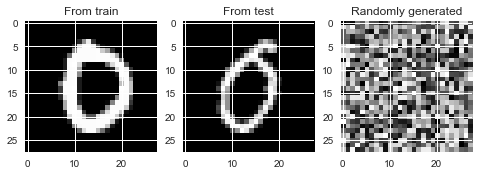

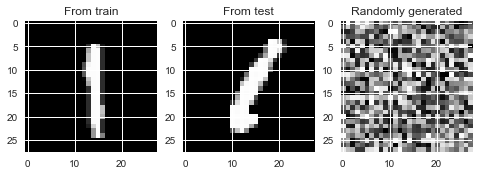

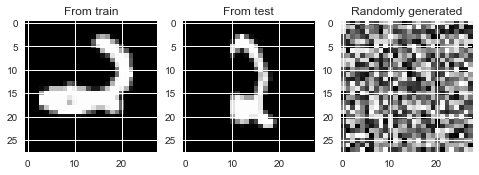

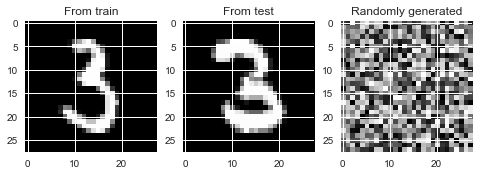

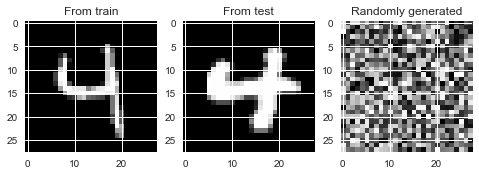

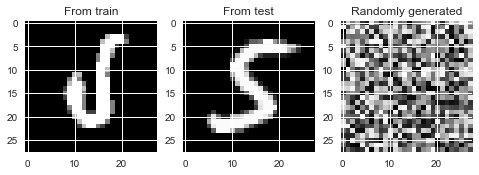

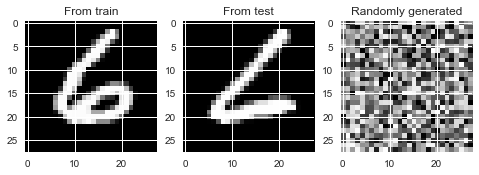

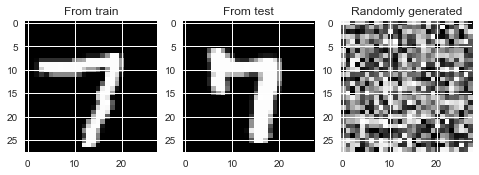

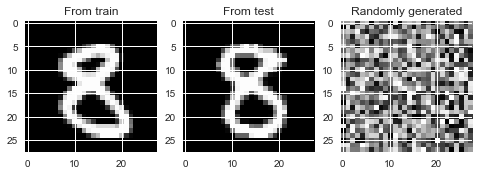

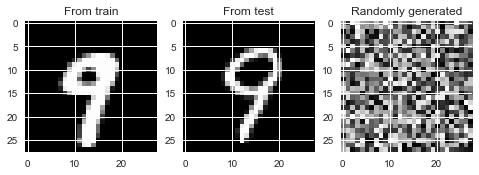

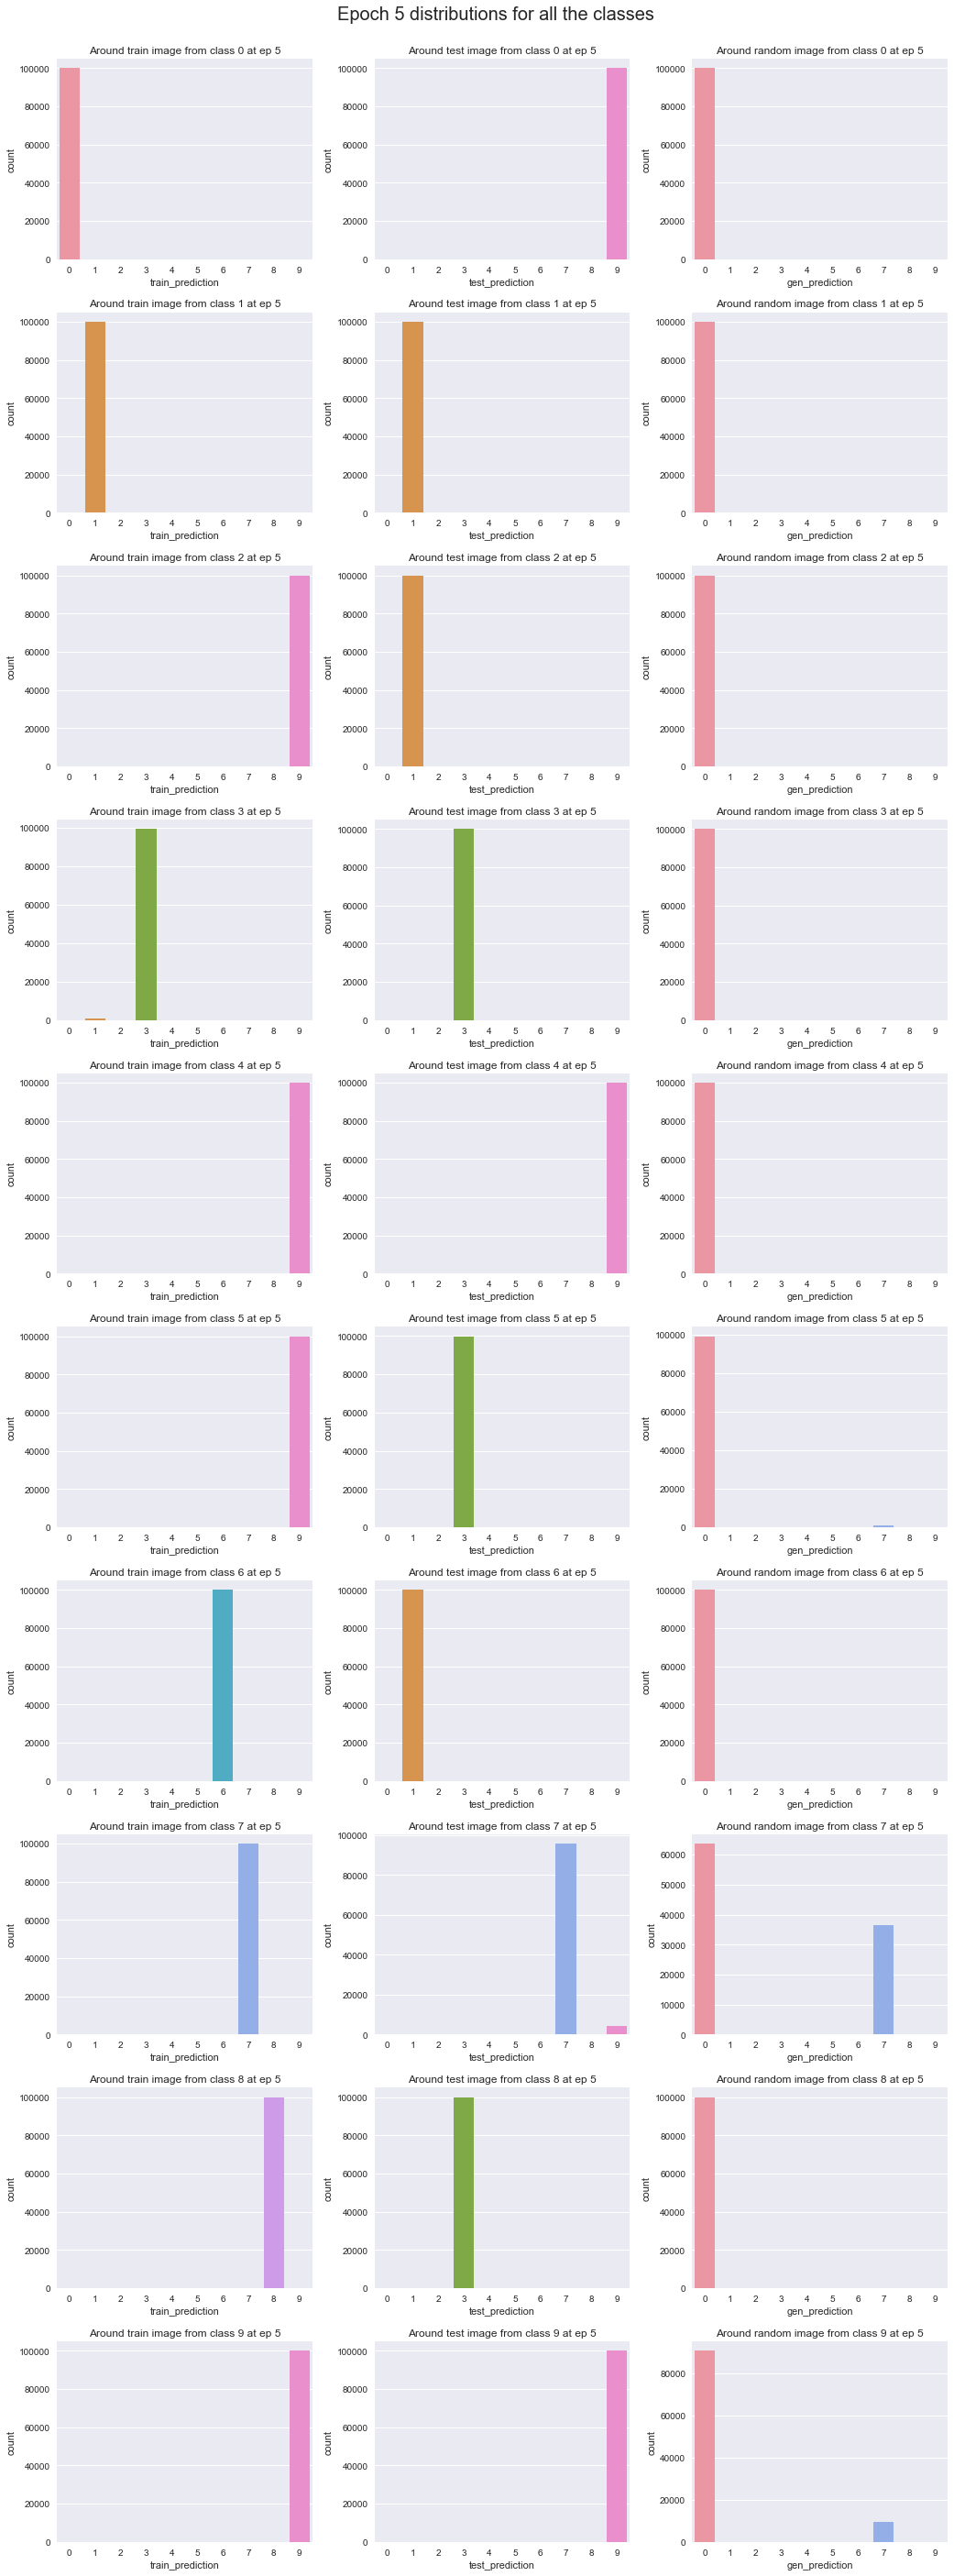

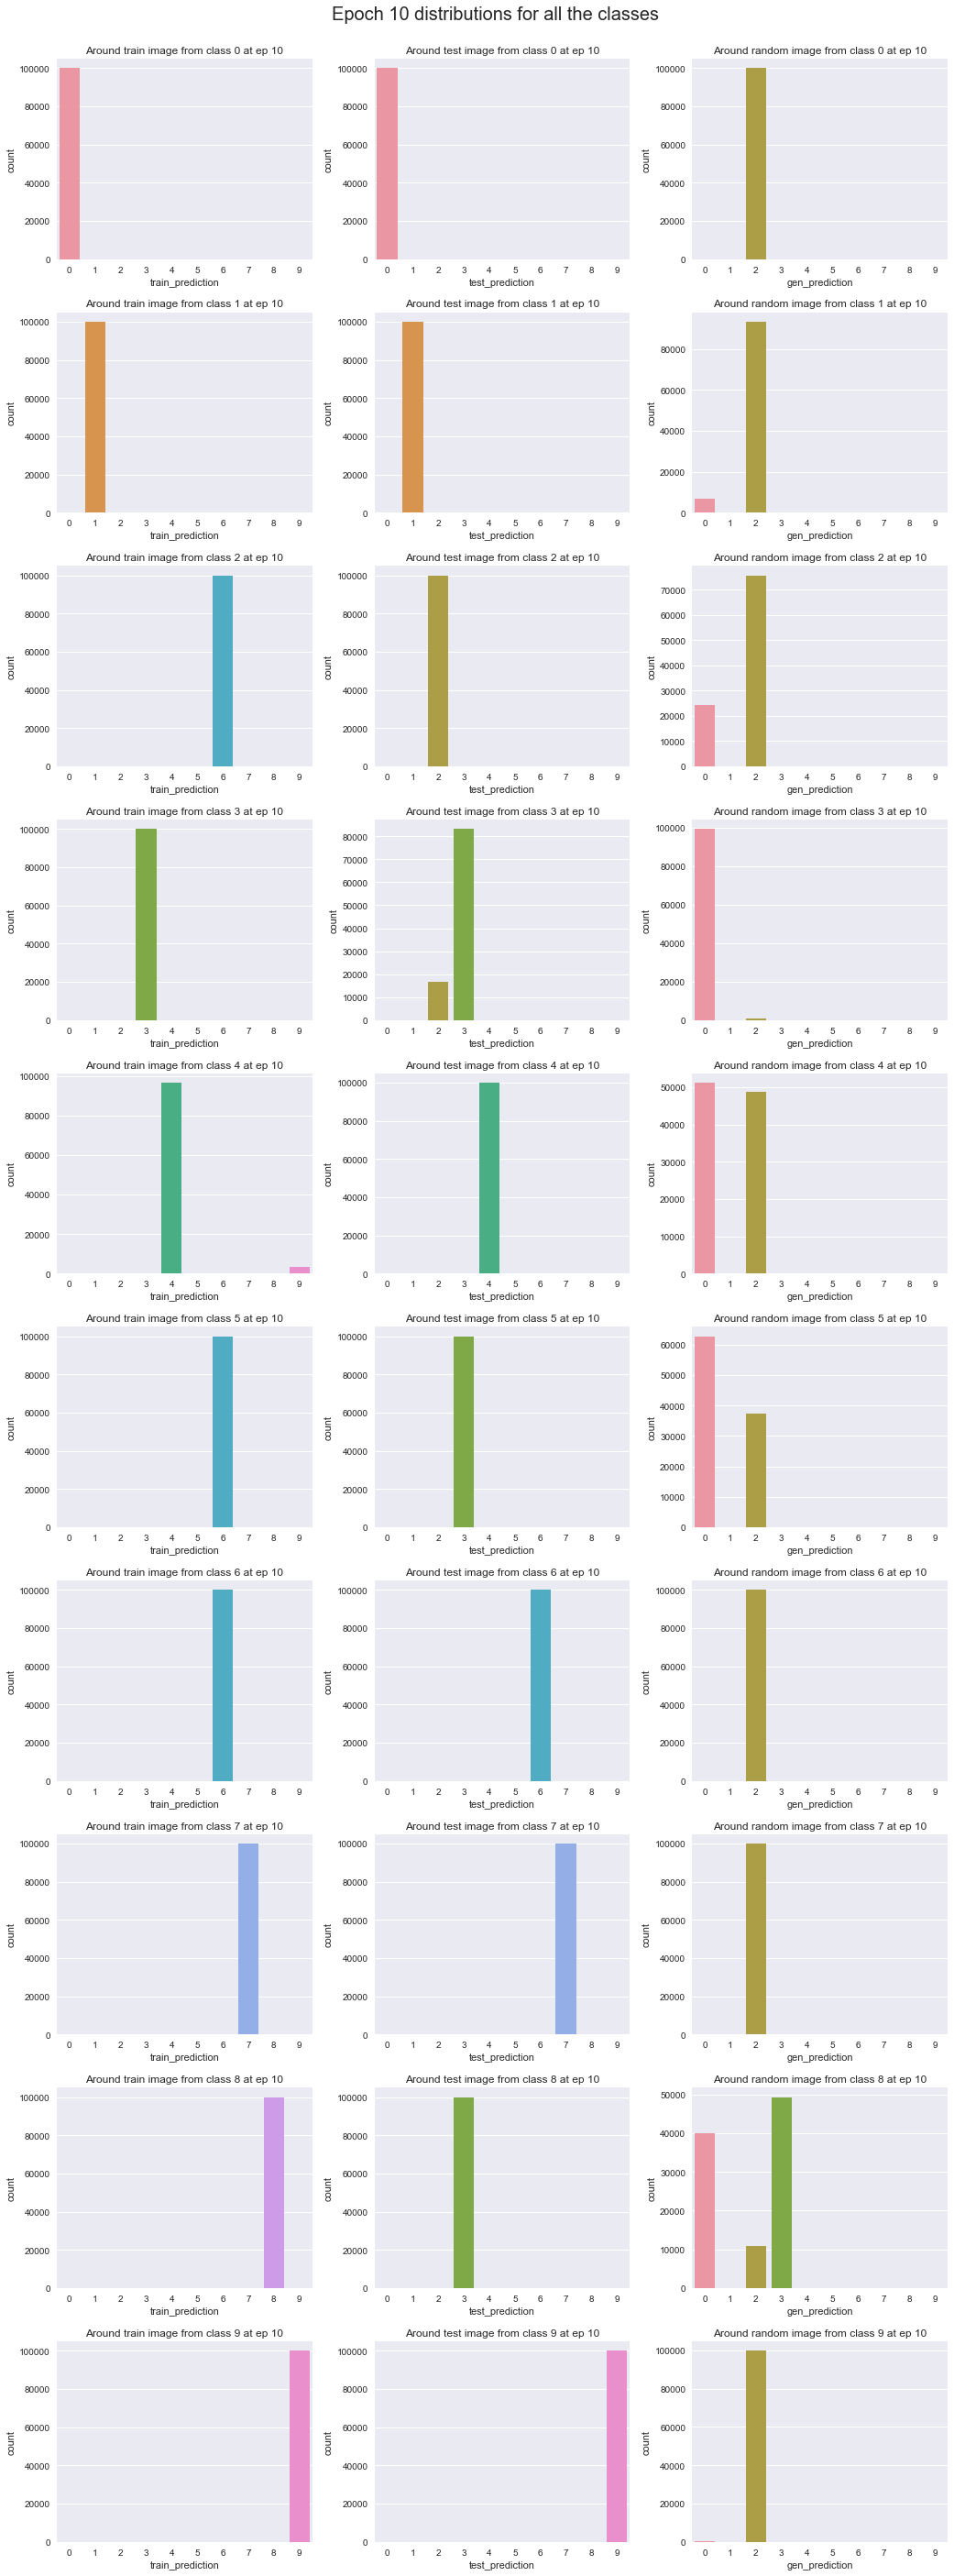

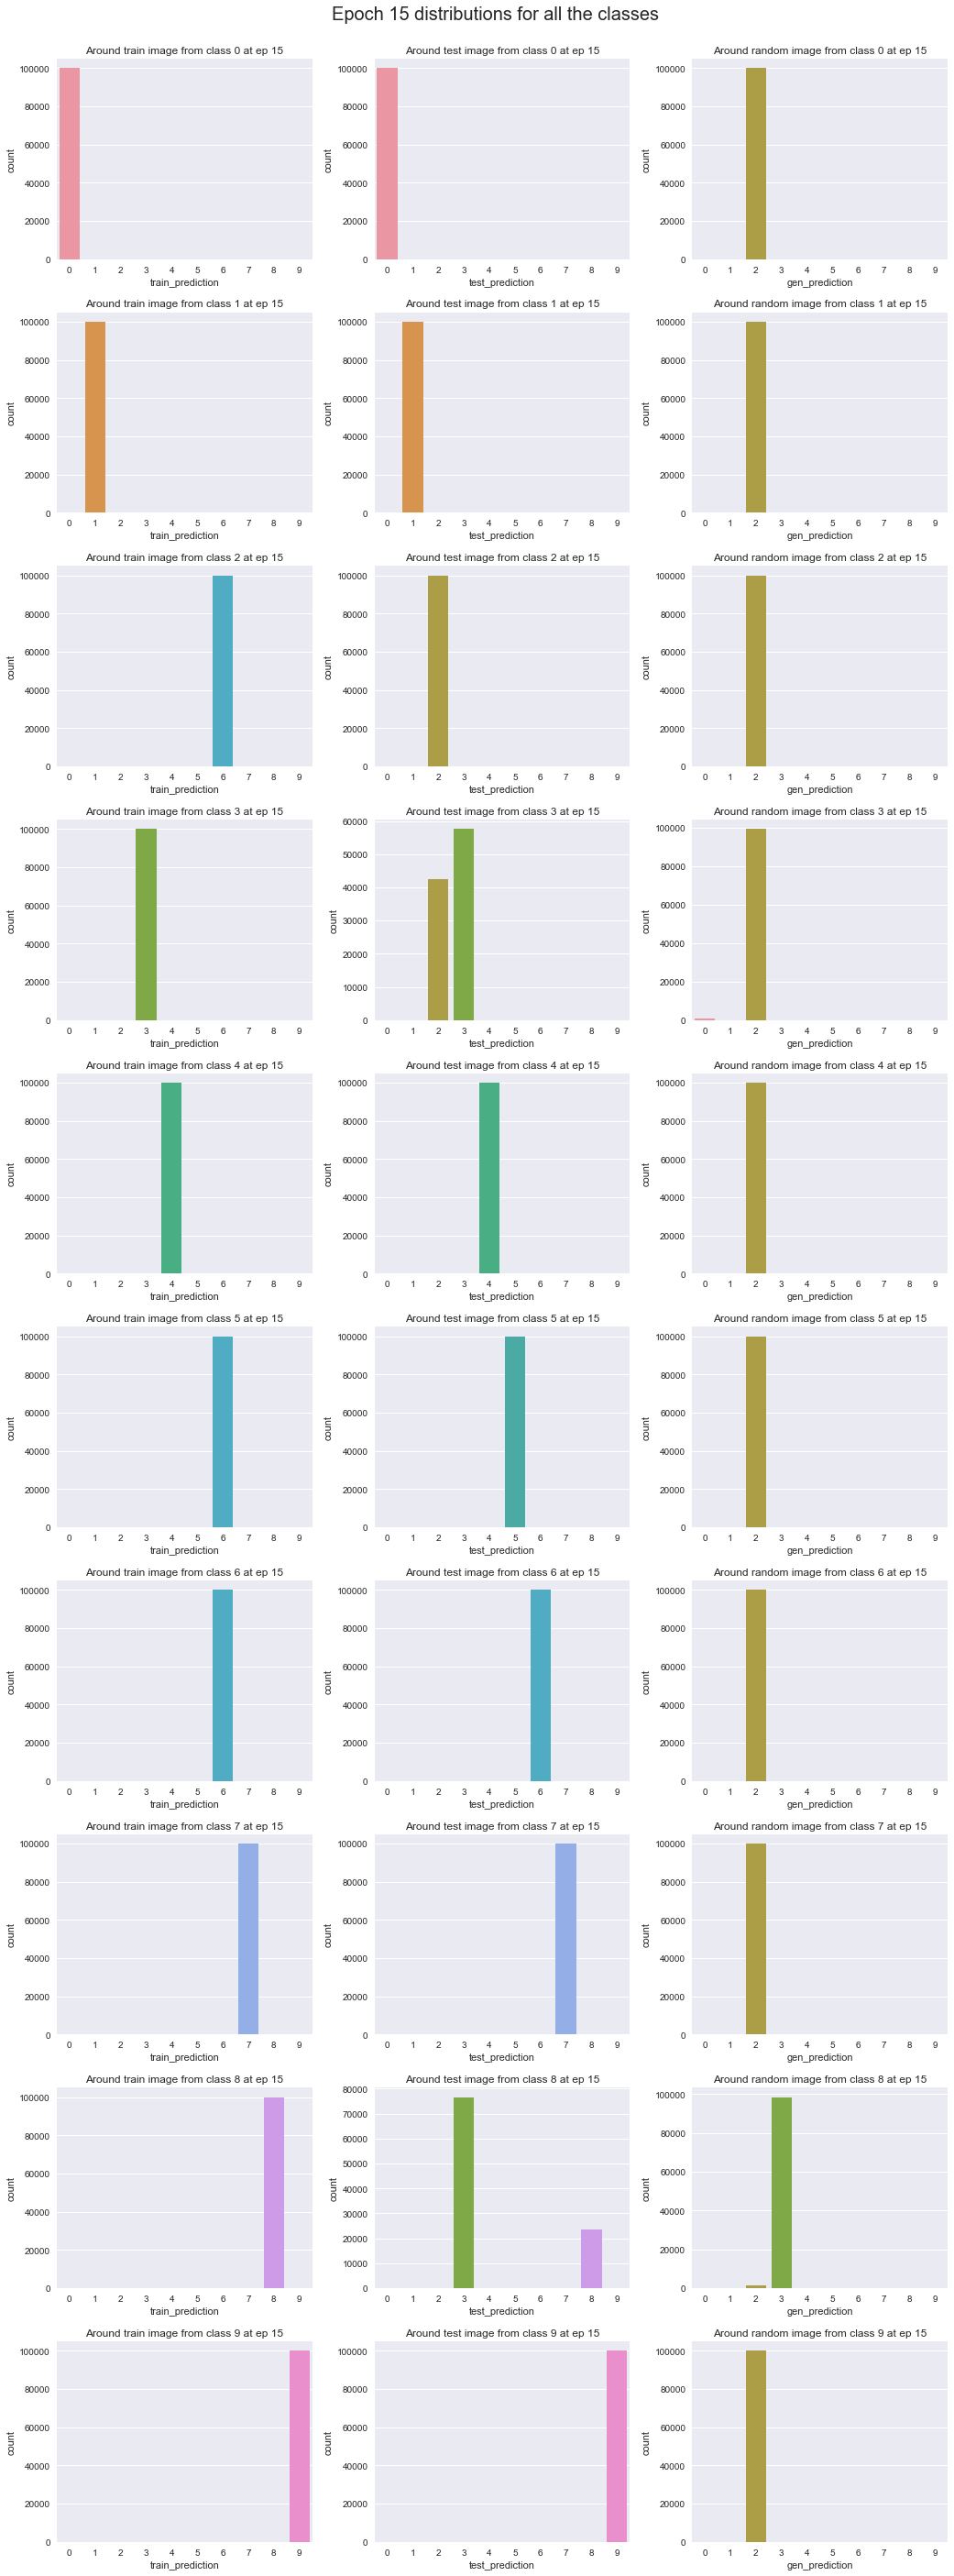

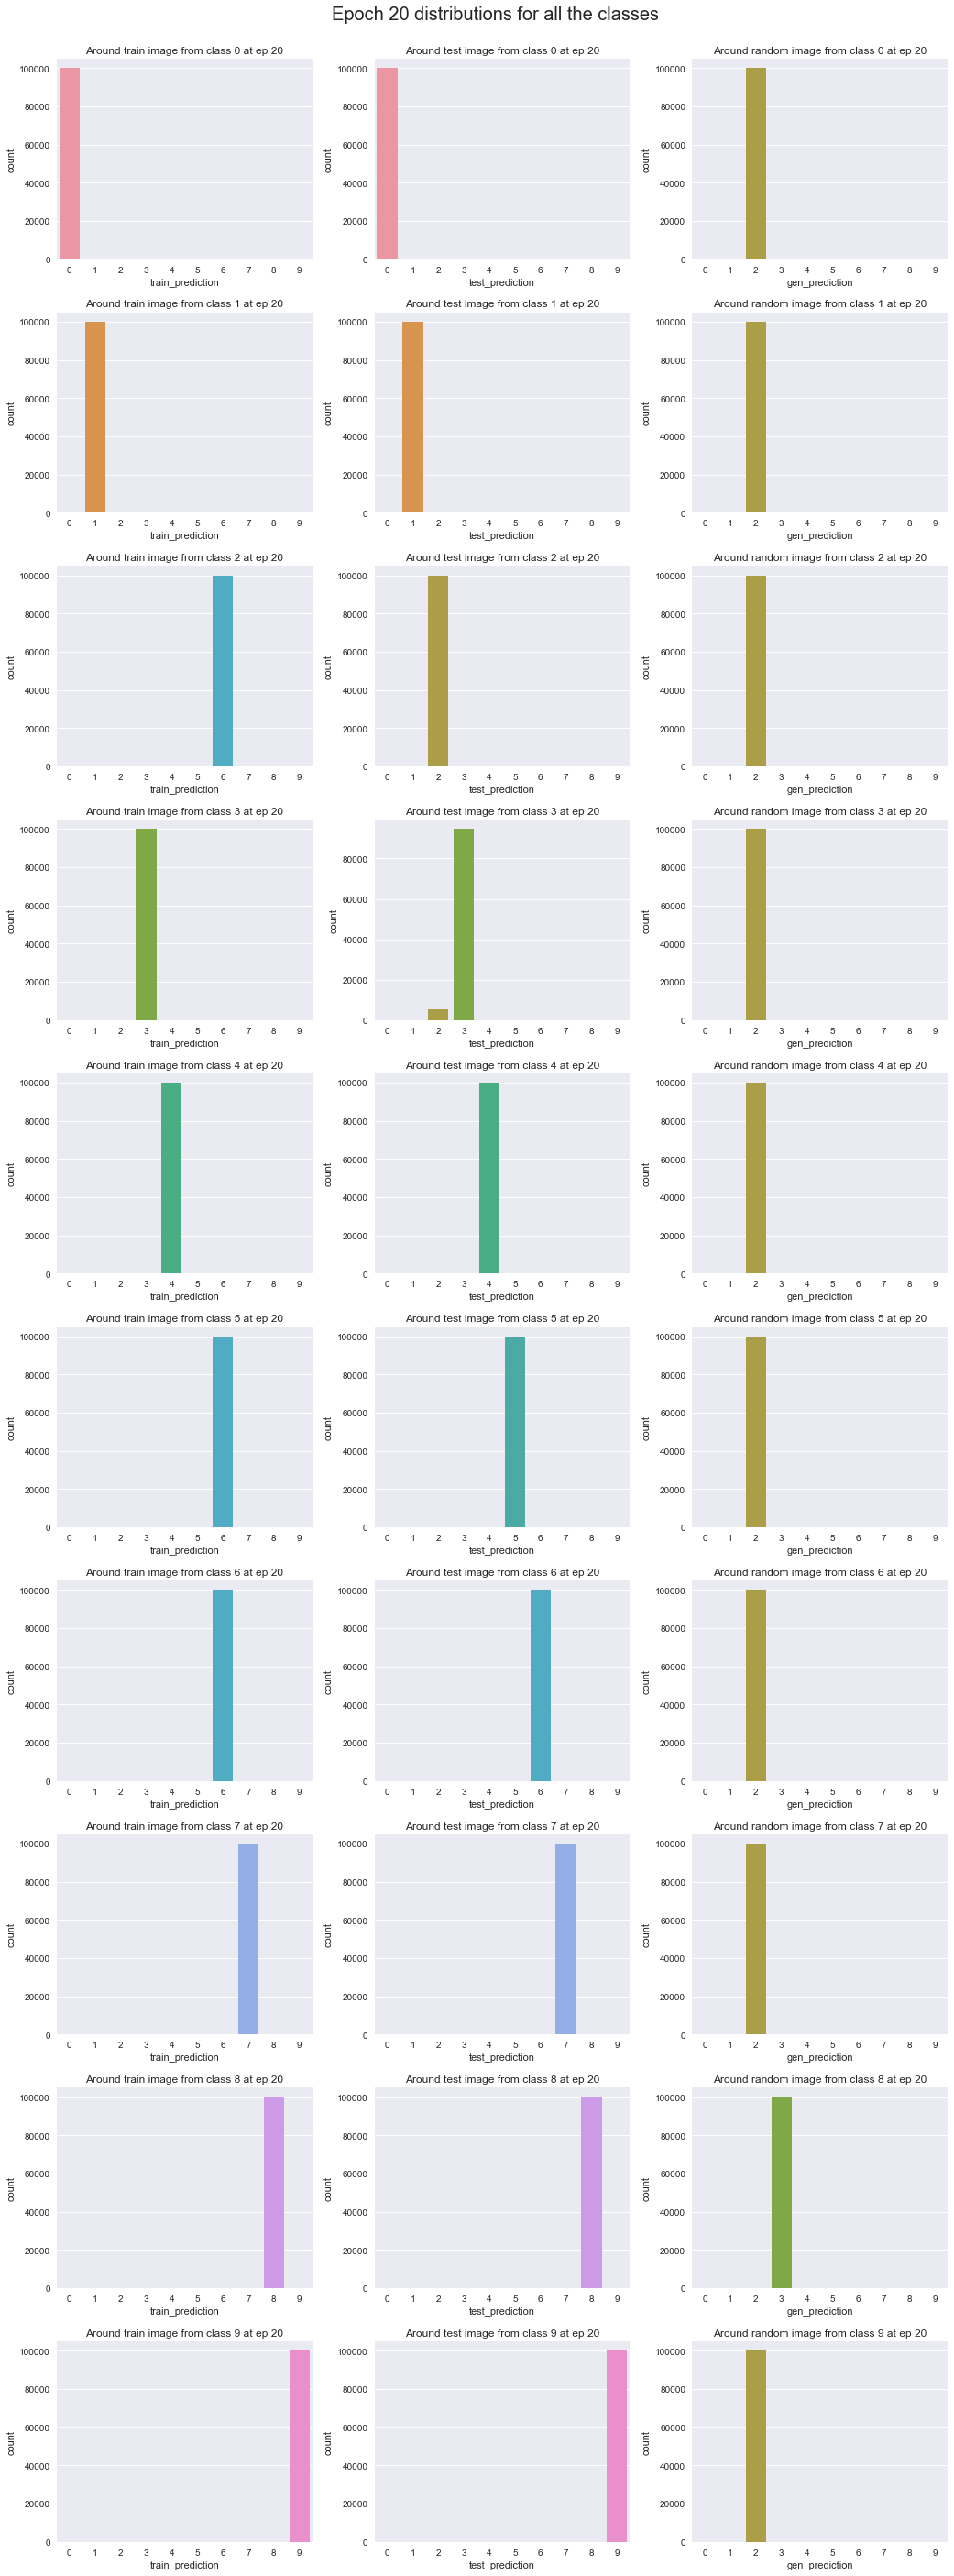

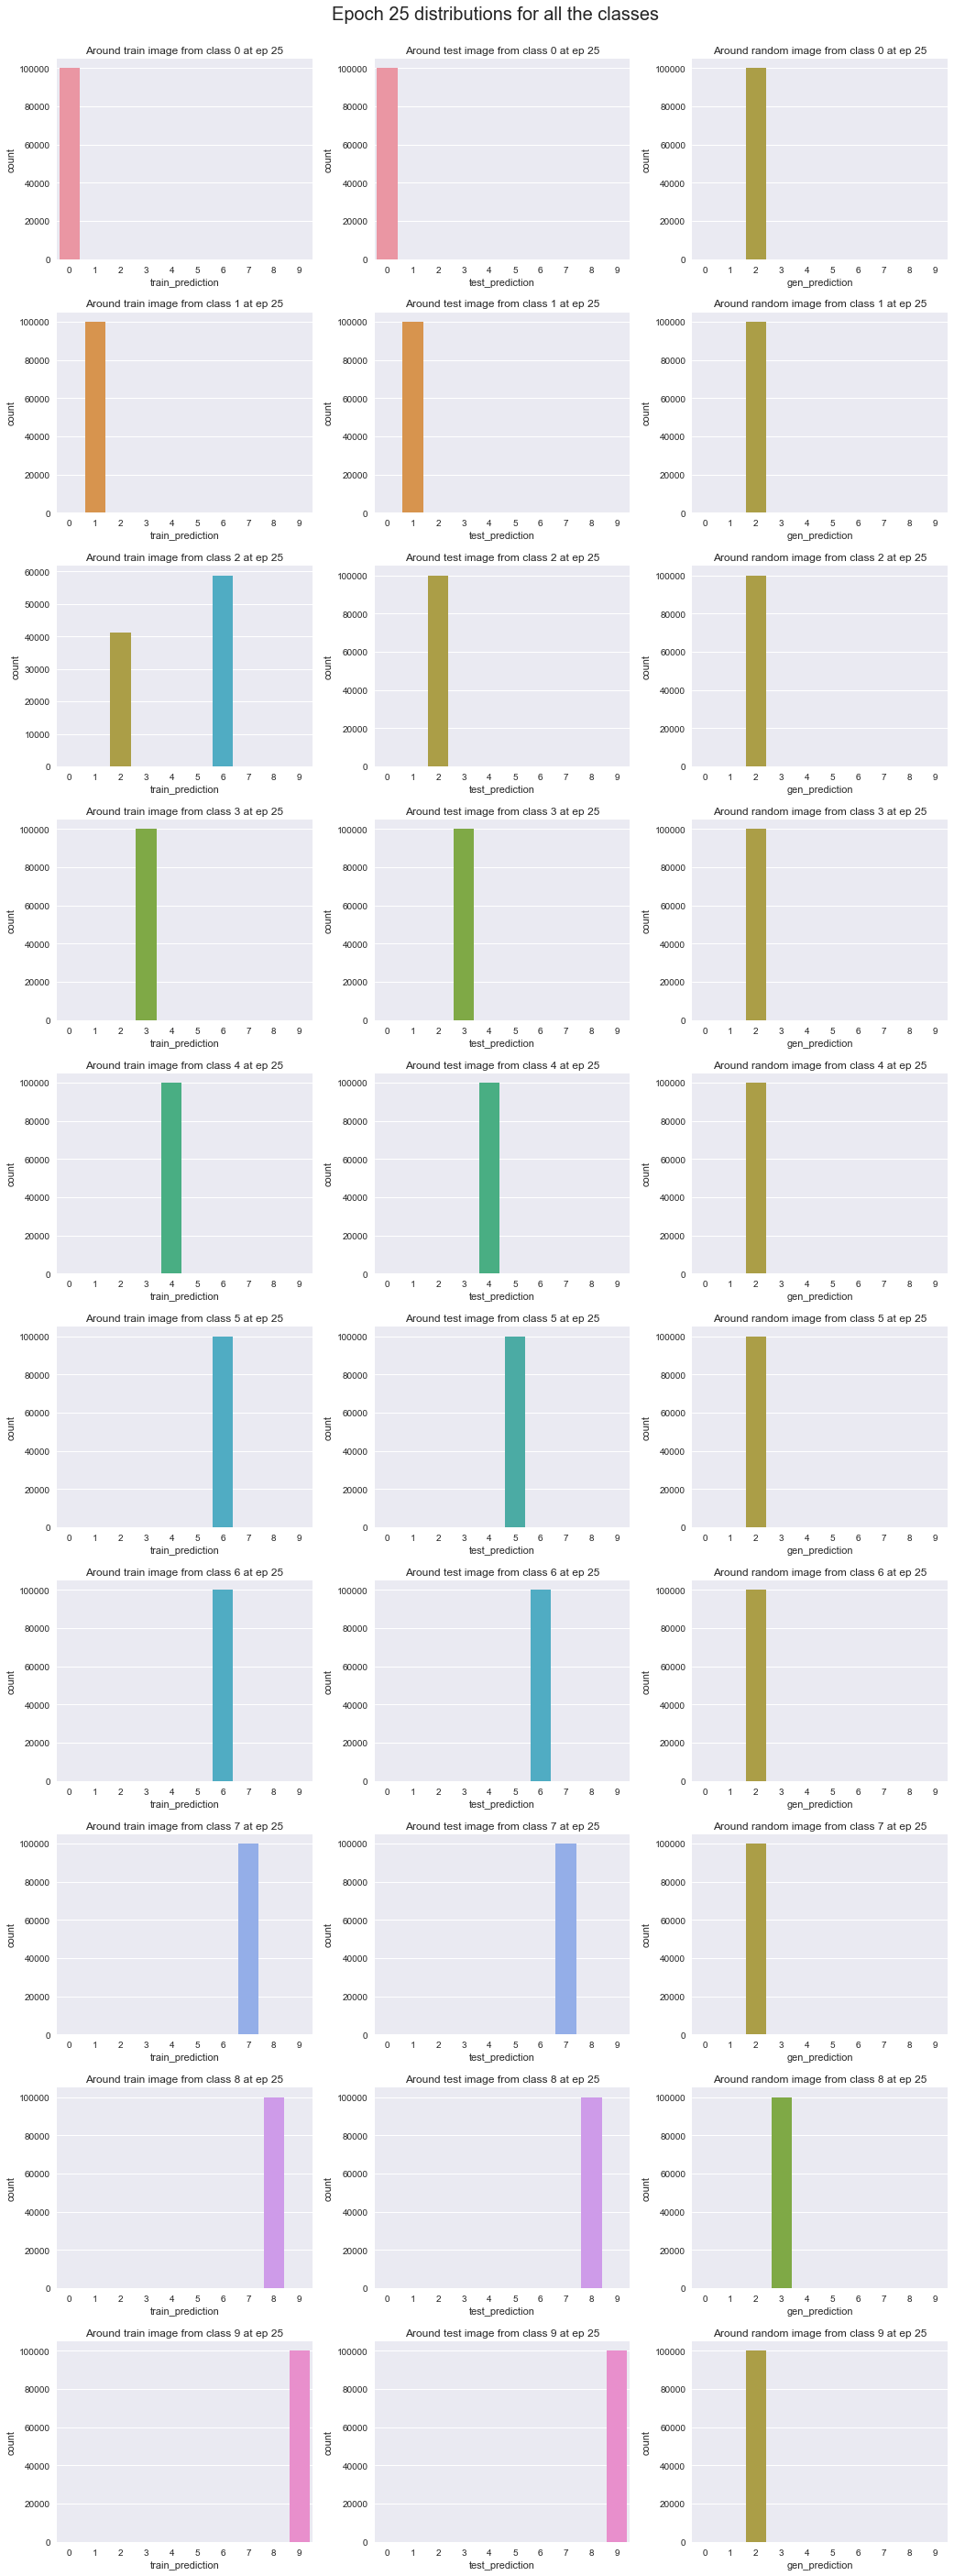

In [31]:
series_model_name = "FFN02-43-10"
model_ep = [5,10,15,20,25]
# model_ep = [25]




perturbation_factor = 0.1
num_sampling = 100000

samples = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    samples[picked_cls] = (extended_train, extended_test, extended_gen)


for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))
    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
#     gen_df = pd.DataFrame()
    f, axarr = plt.subplots(10, 3,  figsize=(15, 40))
    plt.style.use('seaborn')
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"Epoch {ep} distributions for all the classes",fontsize=20)
    for cls in samples:
        with torch.no_grad():
            train_outputs = new_model(samples[cls][0].to(device)).argmax(dim=1)
#             print(train_outputs)
            test_outputs = new_model(samples[cls][1].to(device)).argmax(dim=1)
            gen_outputs = new_model(samples[cls][2].to(device)).argmax(dim=1)
#         train_df[cls] = train_outputs.cpu().numpy().copy()
#         test_df[cls] = test_outputs.cpu().numpy().copy()
#         gen_df[cls] = gen_outputs.cpu().numpy().copy()
#     print(train_df)
        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
        gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
        sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
        axarr[cls][0].set_title(f'Around train image from class {cls} at ep {ep}')
        axarr[cls][1].set_title(f'Around test image from class {cls} at ep {ep}')
        axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')


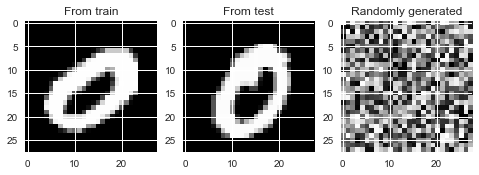

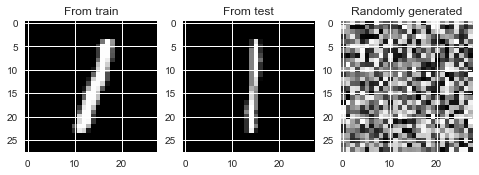

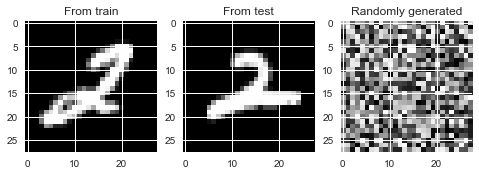

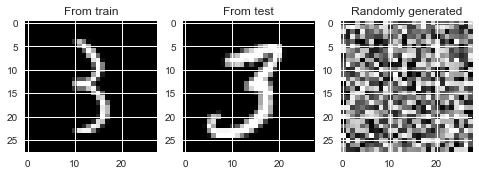

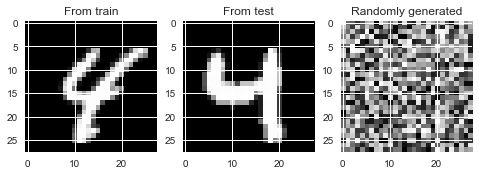

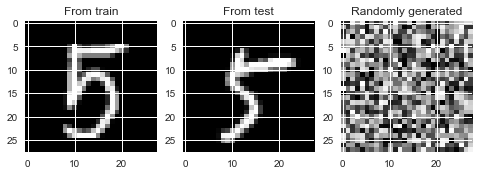

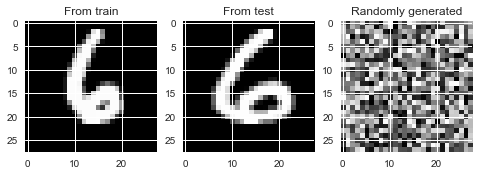

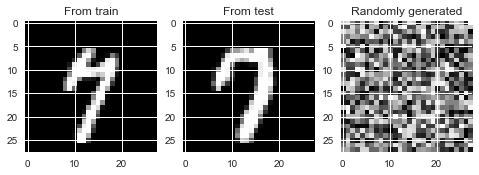

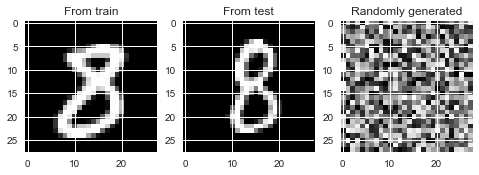

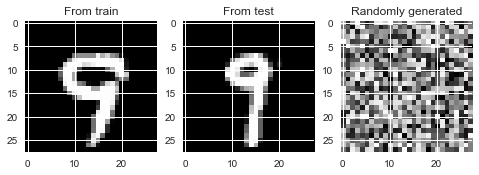

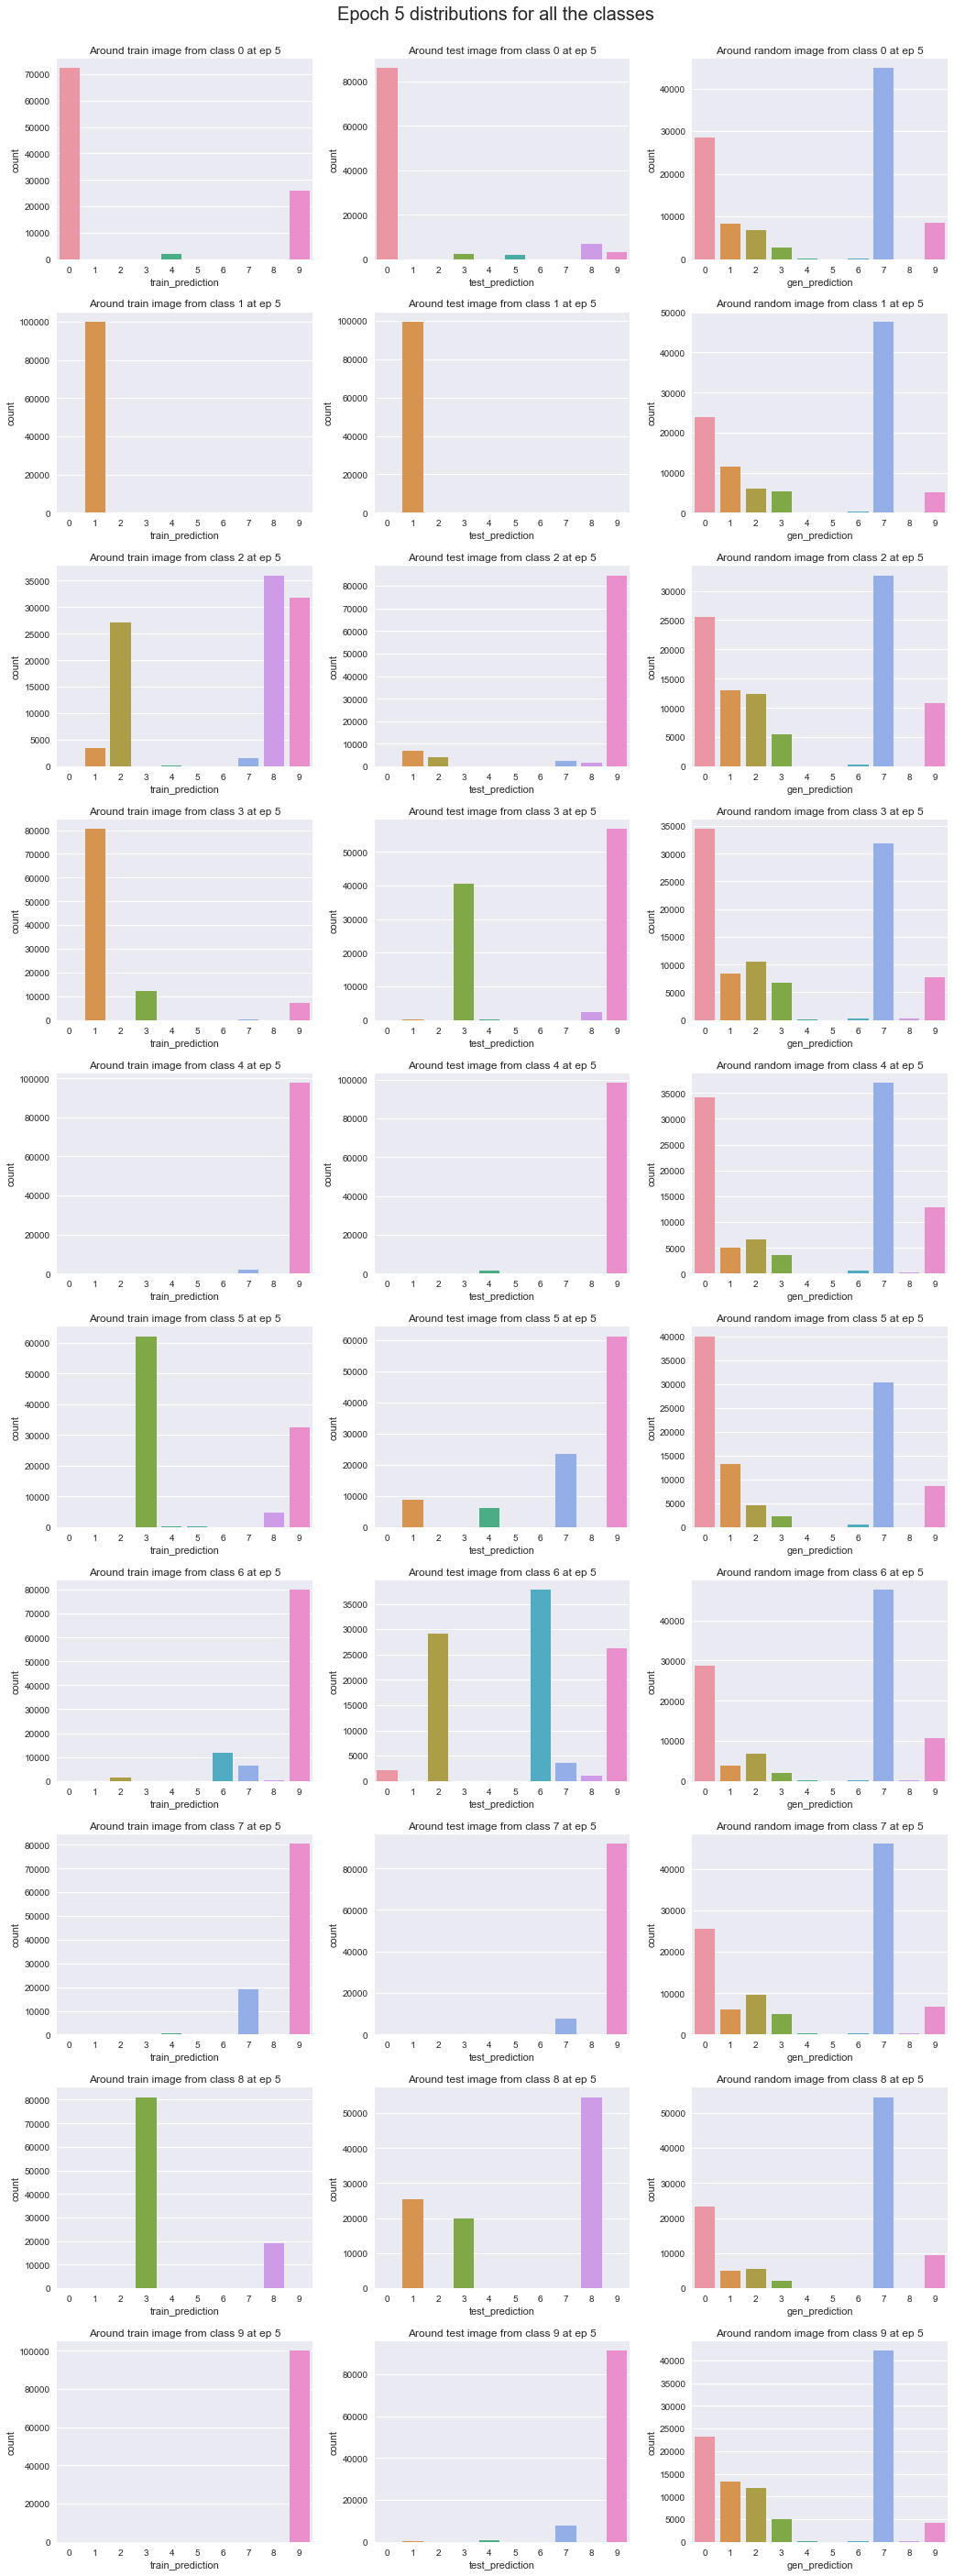

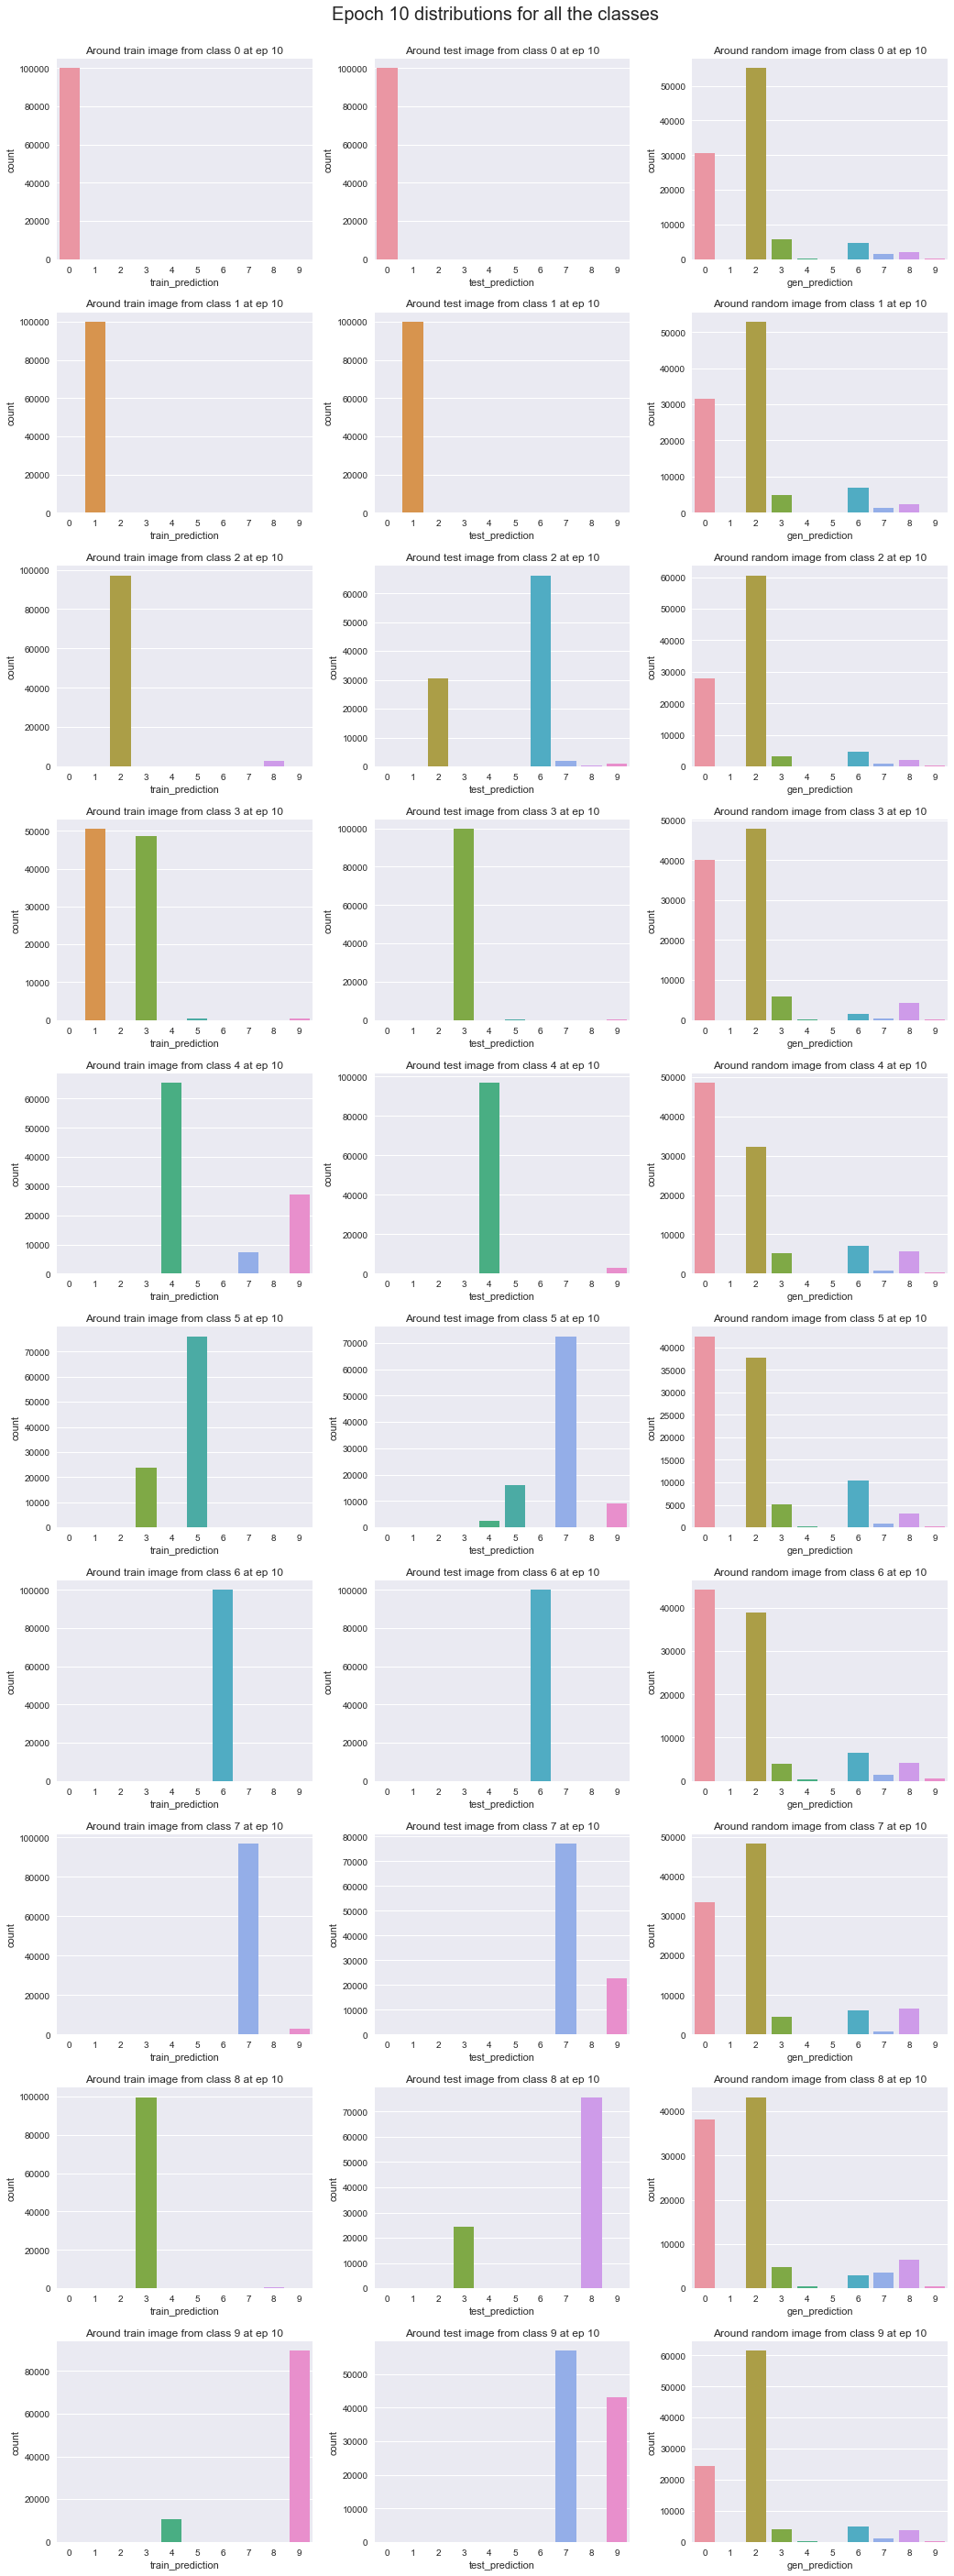

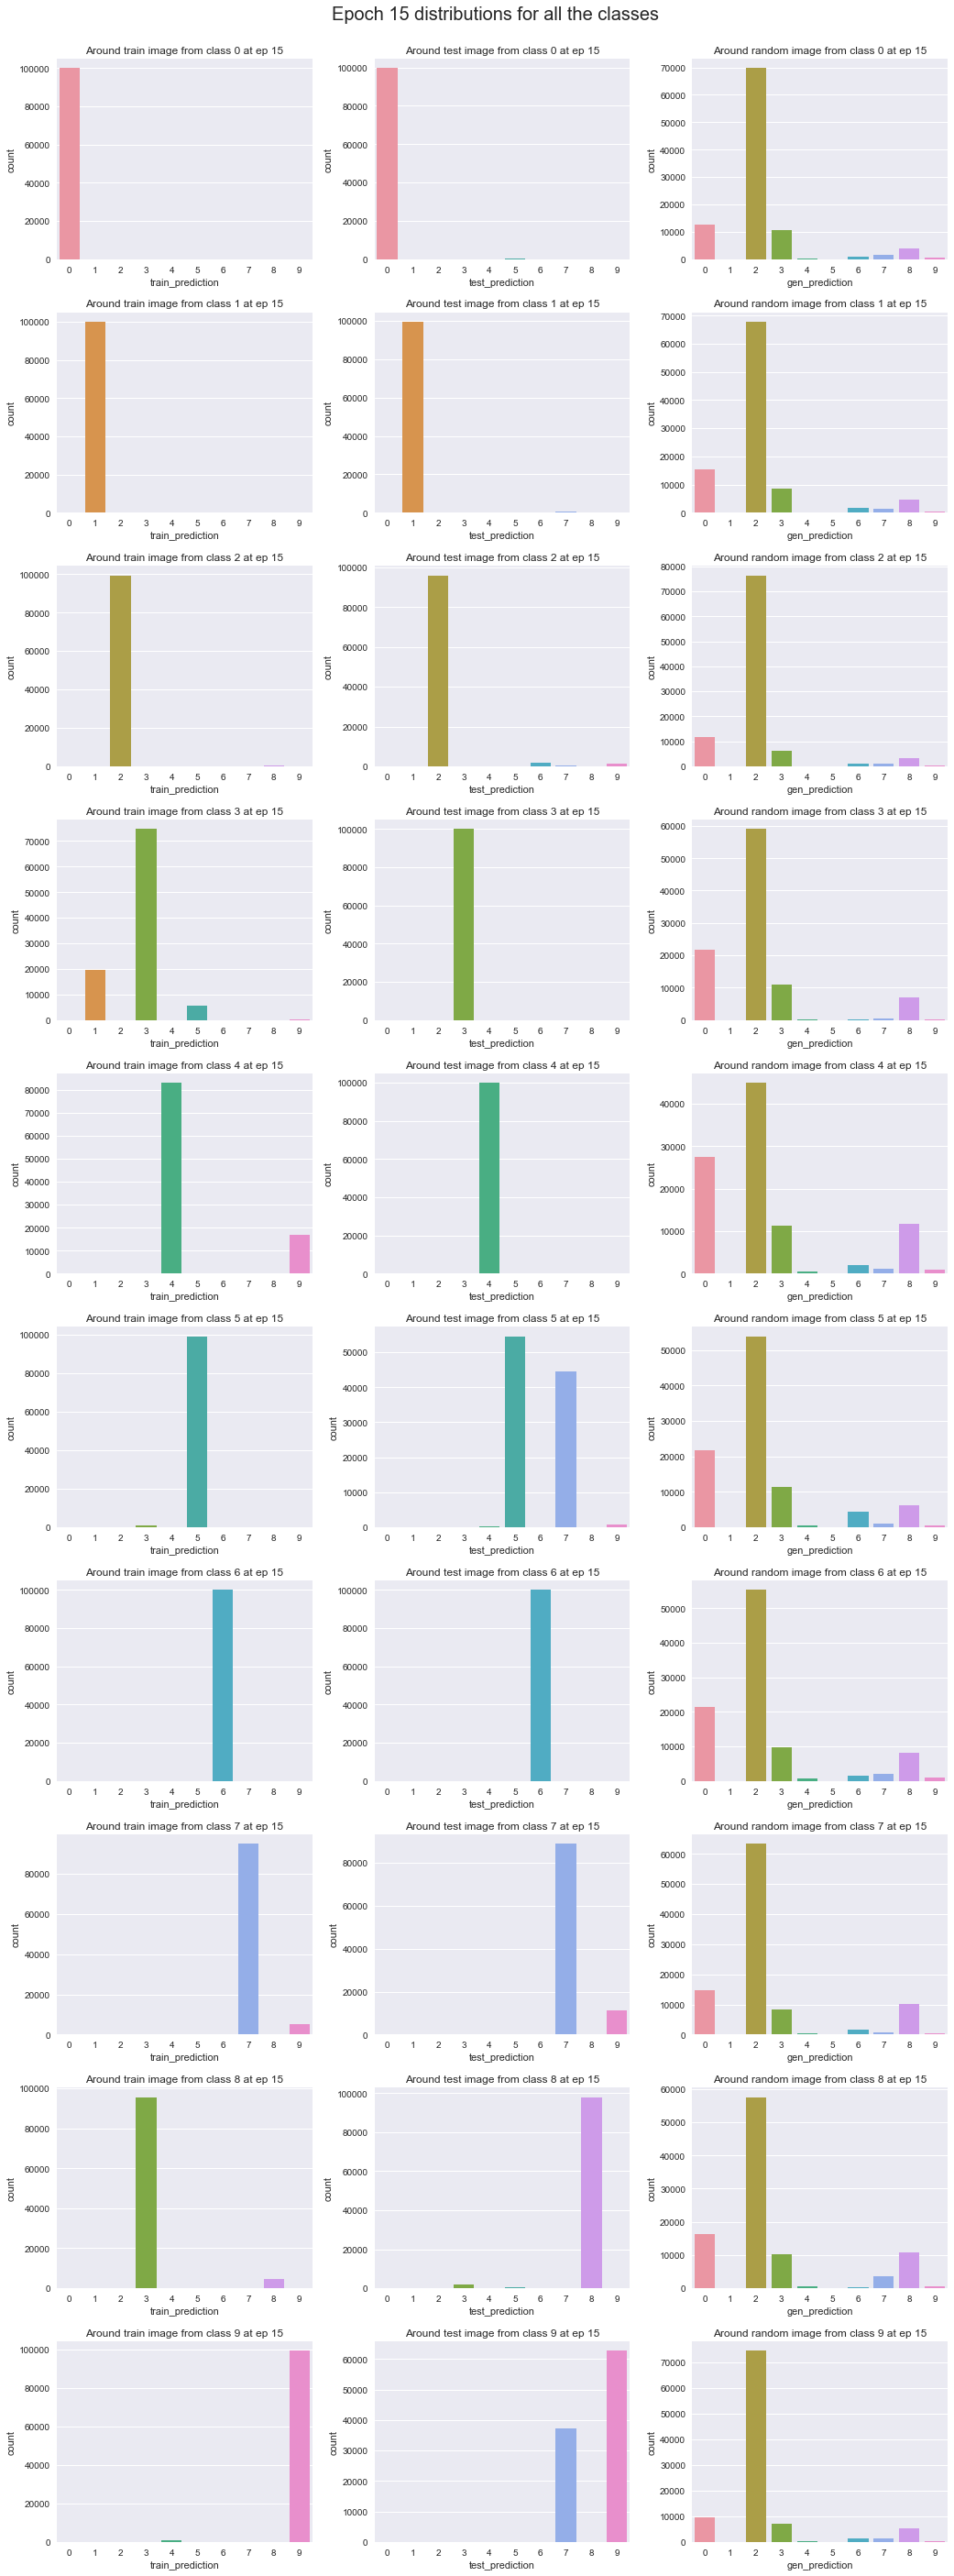

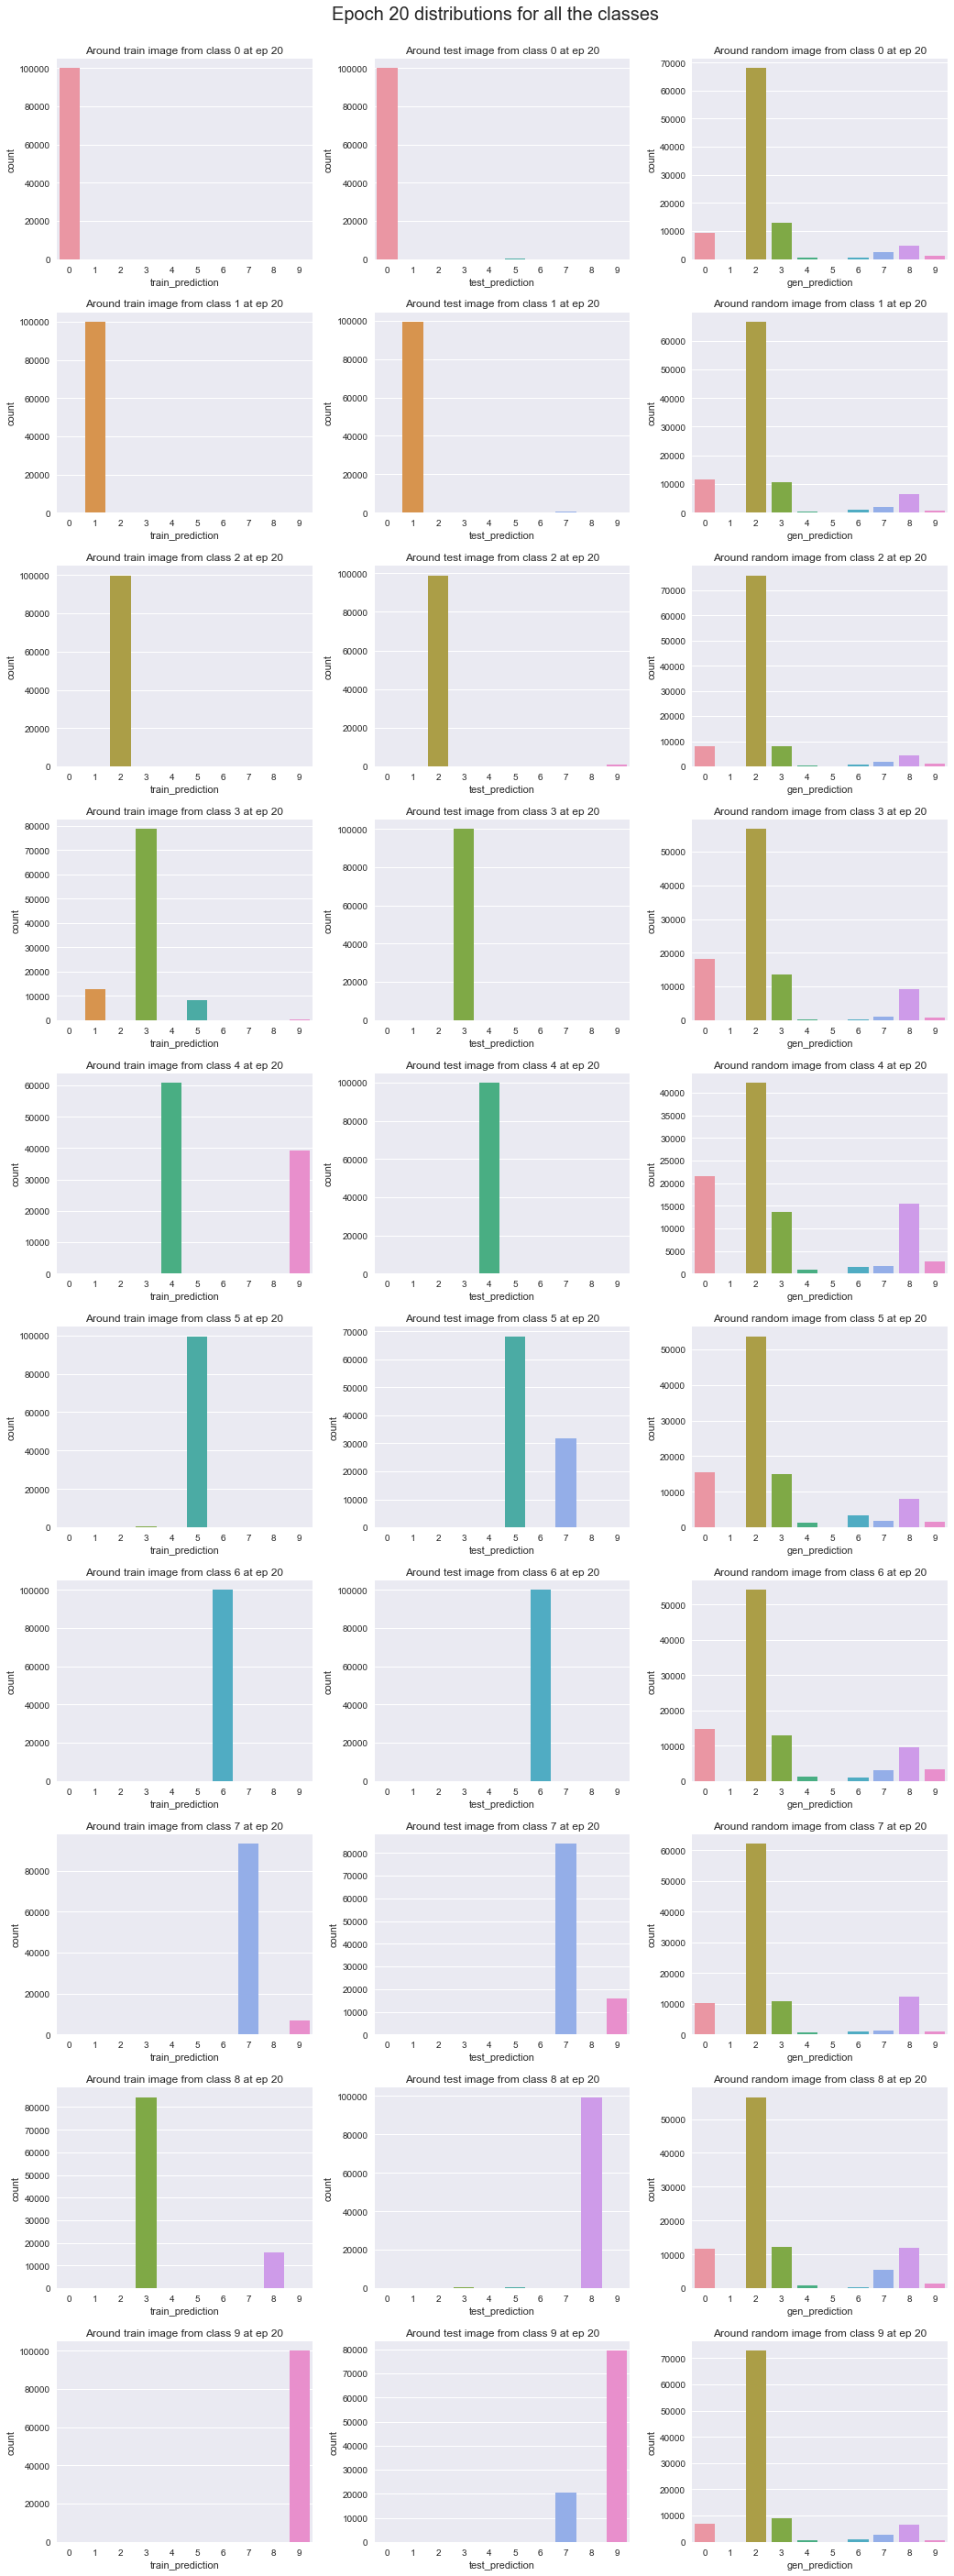

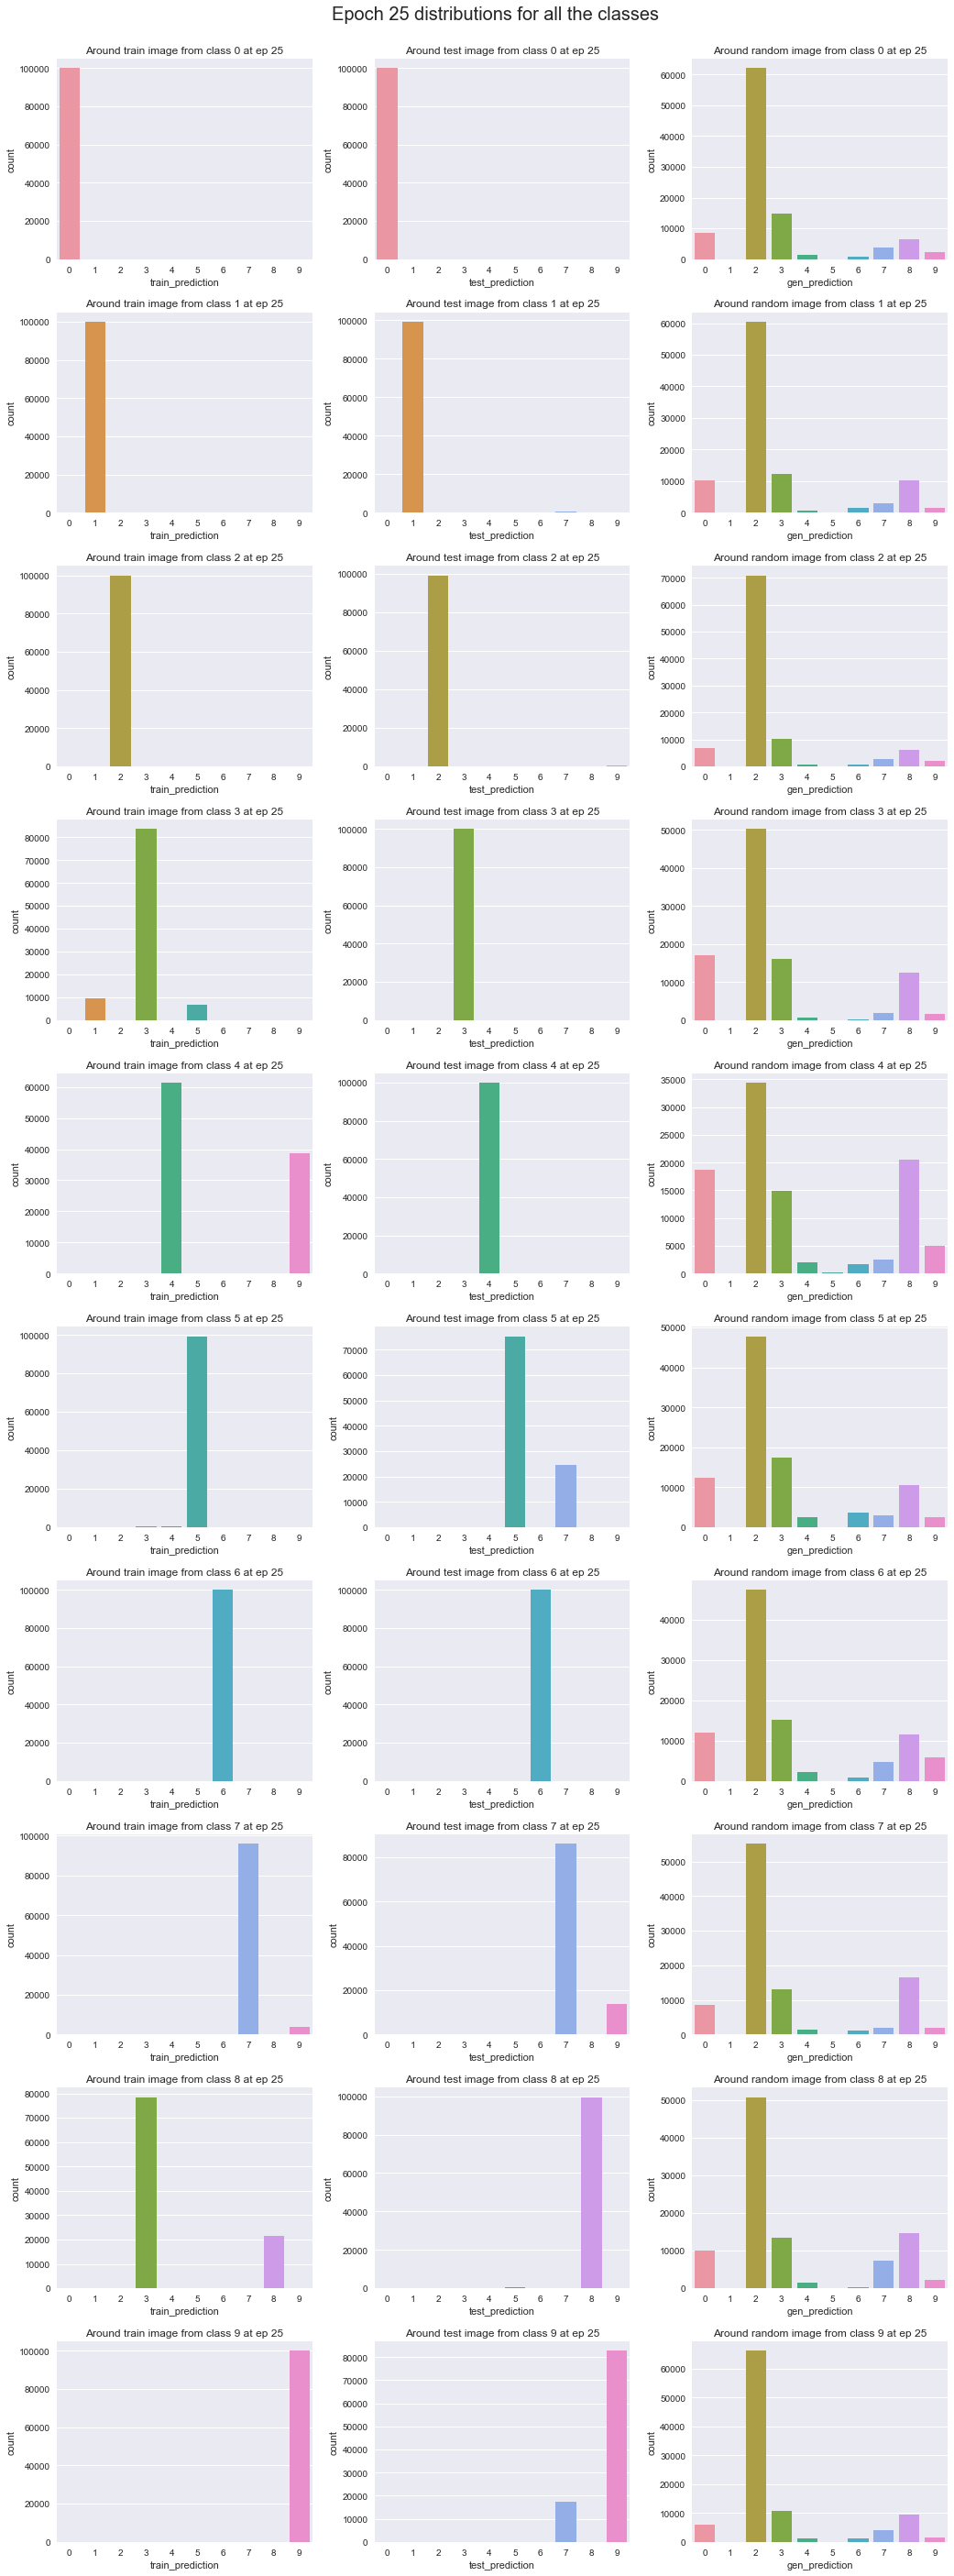

In [33]:
series_model_name = "FFN02-43-10"
model_ep = [5,10,15,20,25]
# model_ep = [25]




perturbation_factor = 1
num_sampling = 100000

samples = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    samples[picked_cls] = (extended_train, extended_test, extended_gen)


for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))
    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
#     gen_df = pd.DataFrame()
    f, axarr = plt.subplots(10, 3,  figsize=(15, 40))
    plt.style.use('seaborn')
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"Epoch {ep} distributions for all the classes",fontsize=20)
    for cls in samples:
        with torch.no_grad():
            train_outputs = new_model(samples[cls][0].to(device)).argmax(dim=1)
#             print(train_outputs)
            test_outputs = new_model(samples[cls][1].to(device)).argmax(dim=1)
            gen_outputs = new_model(samples[cls][2].to(device)).argmax(dim=1)
#         train_df[cls] = train_outputs.cpu().numpy().copy()
#         test_df[cls] = test_outputs.cpu().numpy().copy()
#         gen_df[cls] = gen_outputs.cpu().numpy().copy()
#     print(train_df)
        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
        gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
        sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
        axarr[cls][0].set_title(f'Around train image from class {cls} at ep {ep}')
        axarr[cls][1].set_title(f'Around test image from class {cls} at ep {ep}')
        axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')


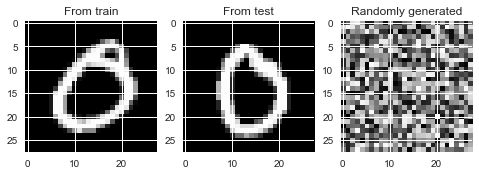

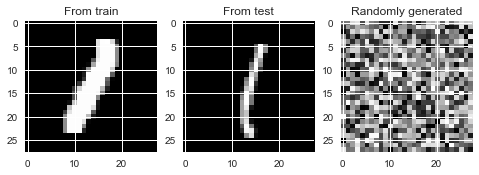

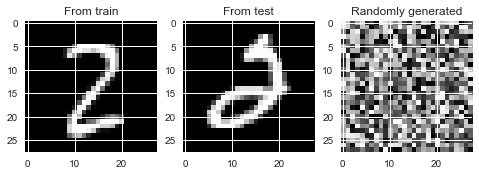

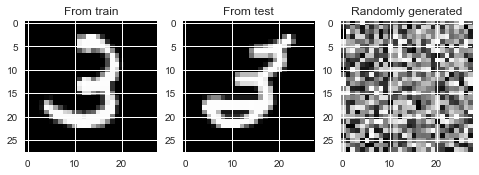

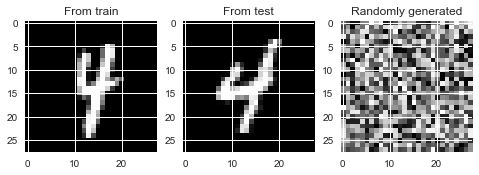

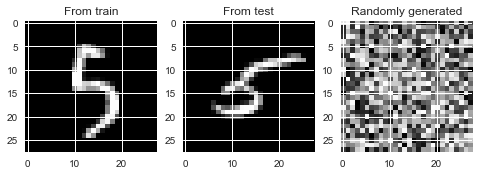

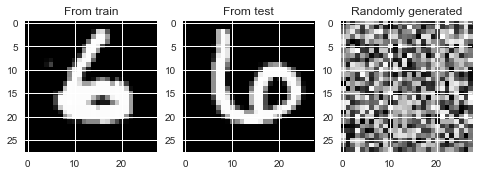

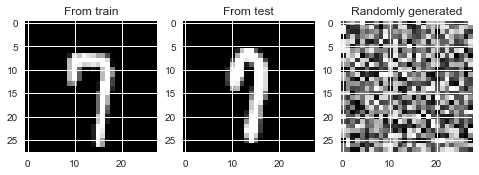

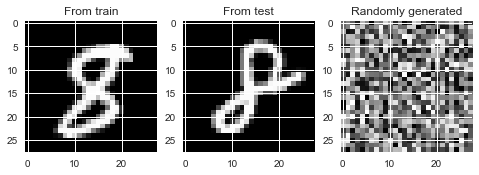

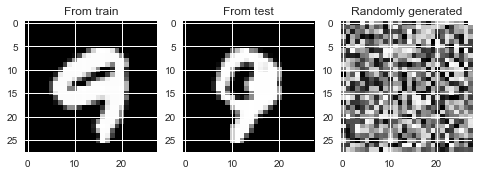

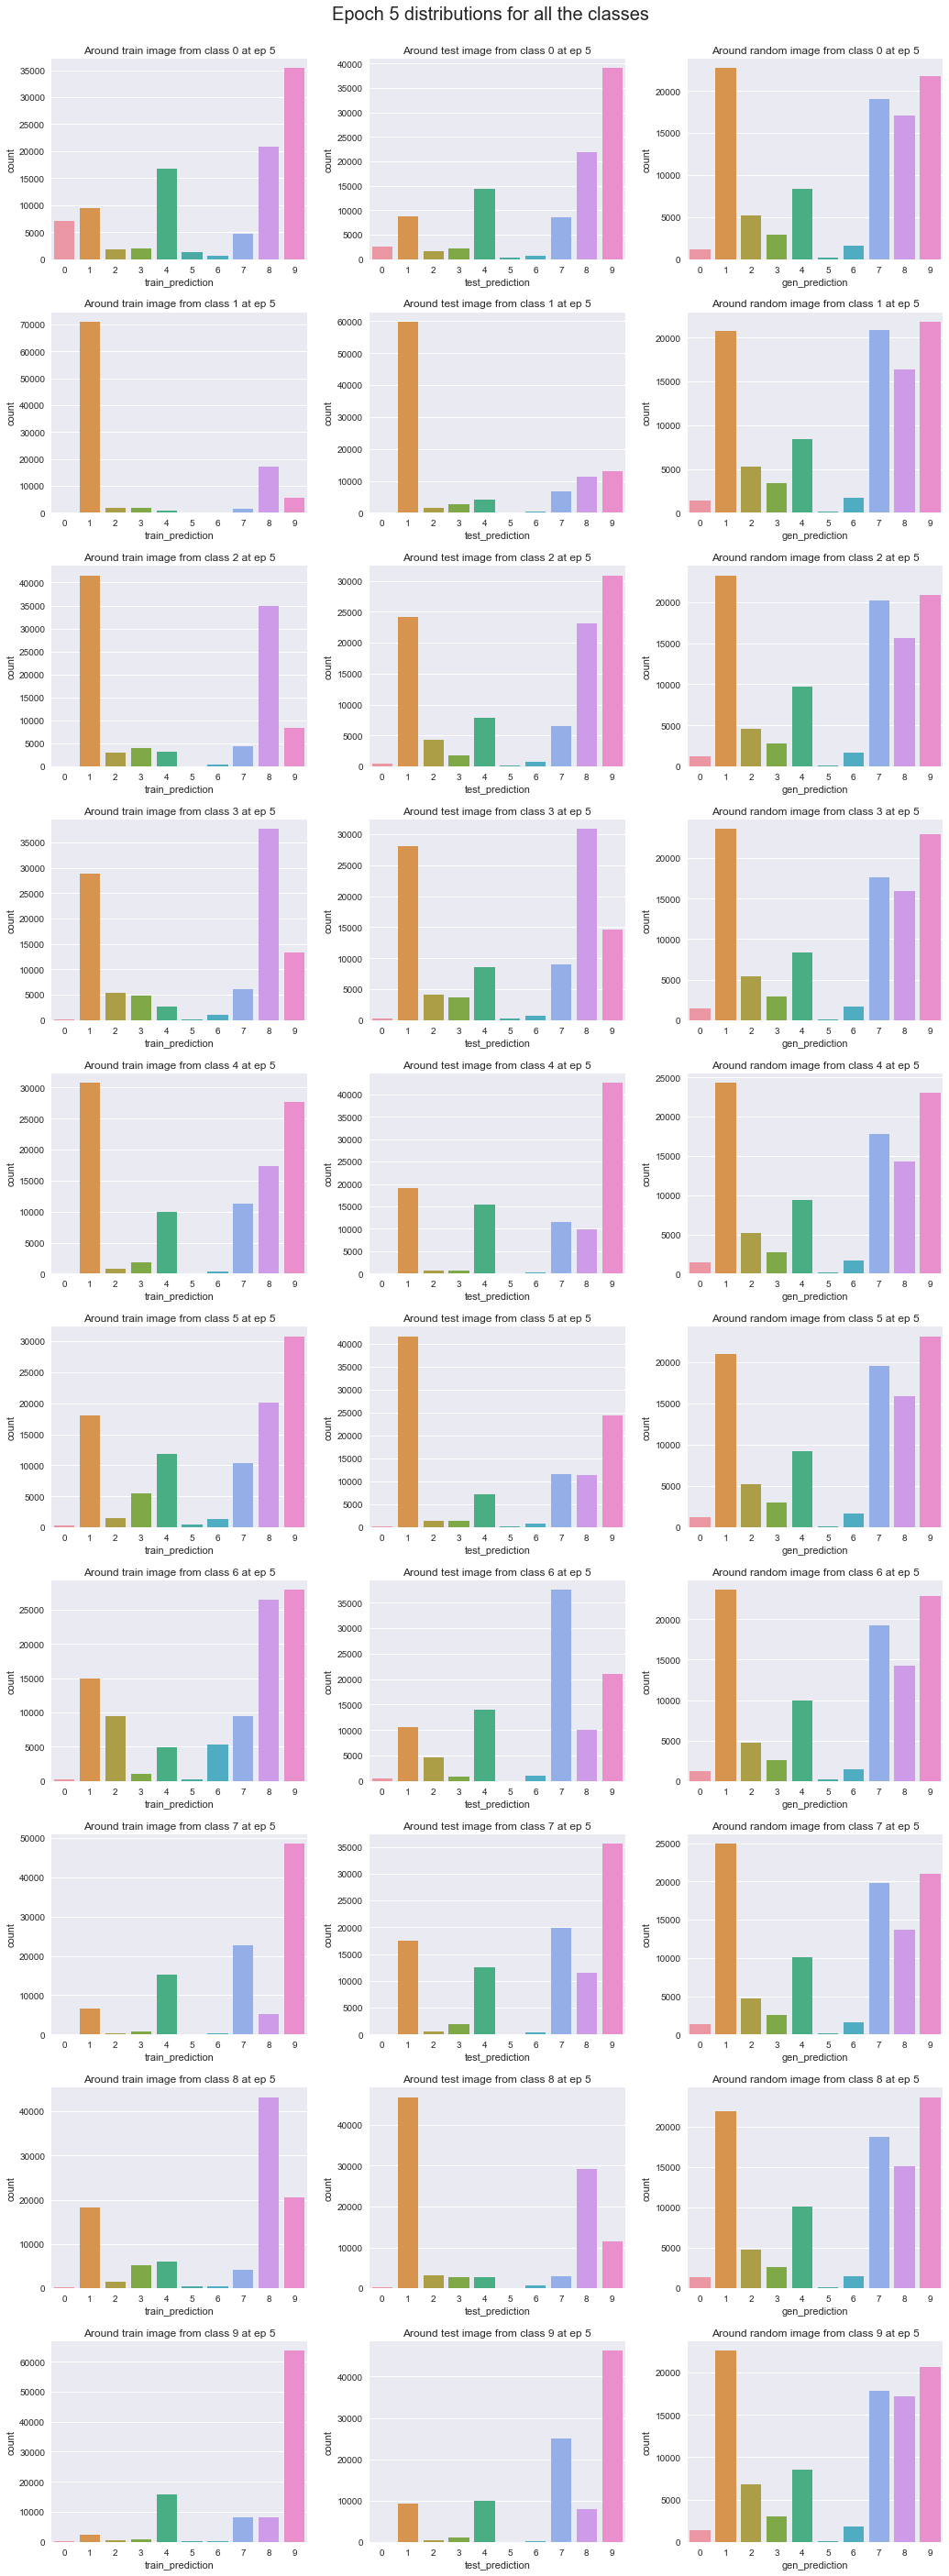

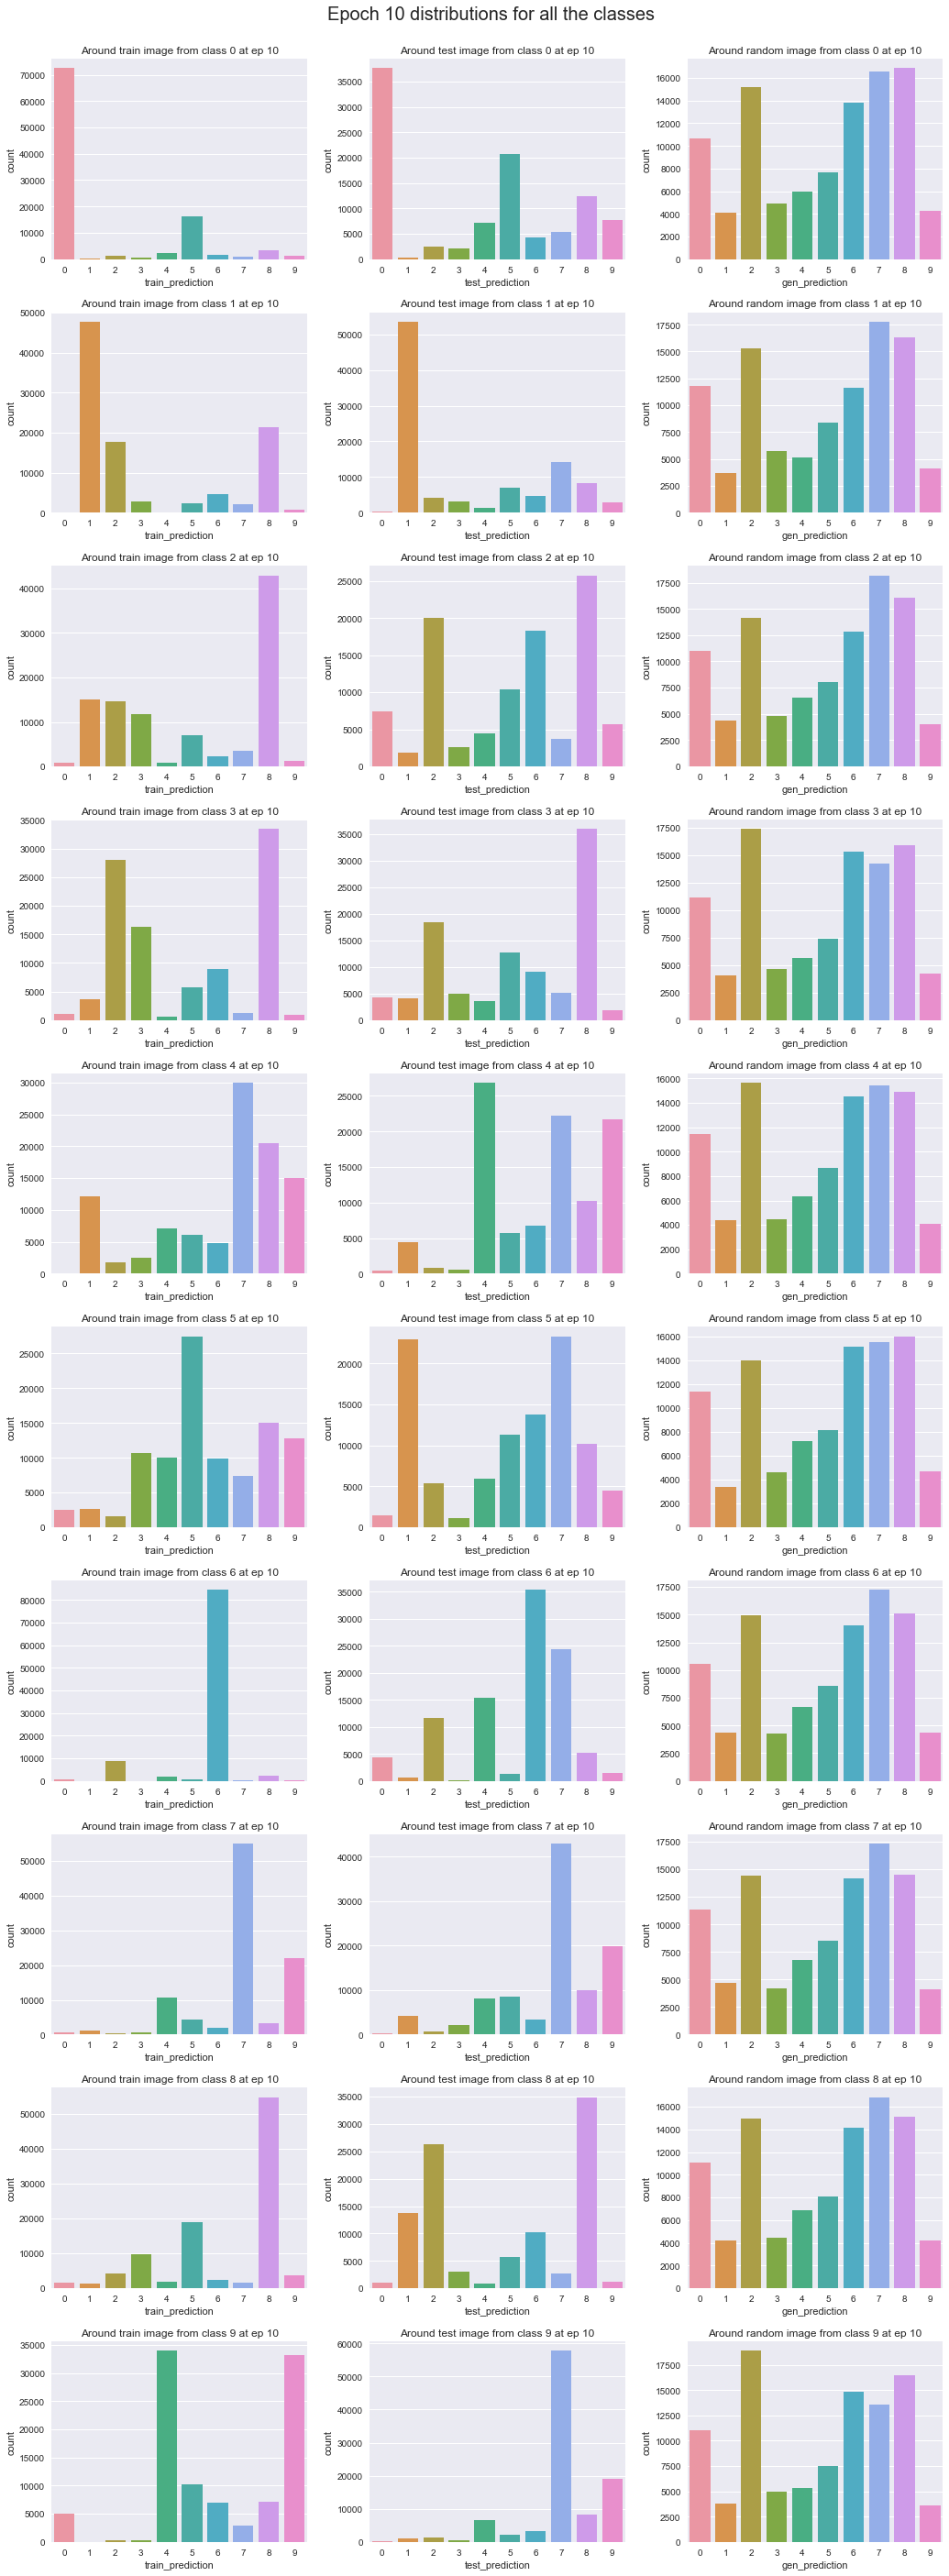

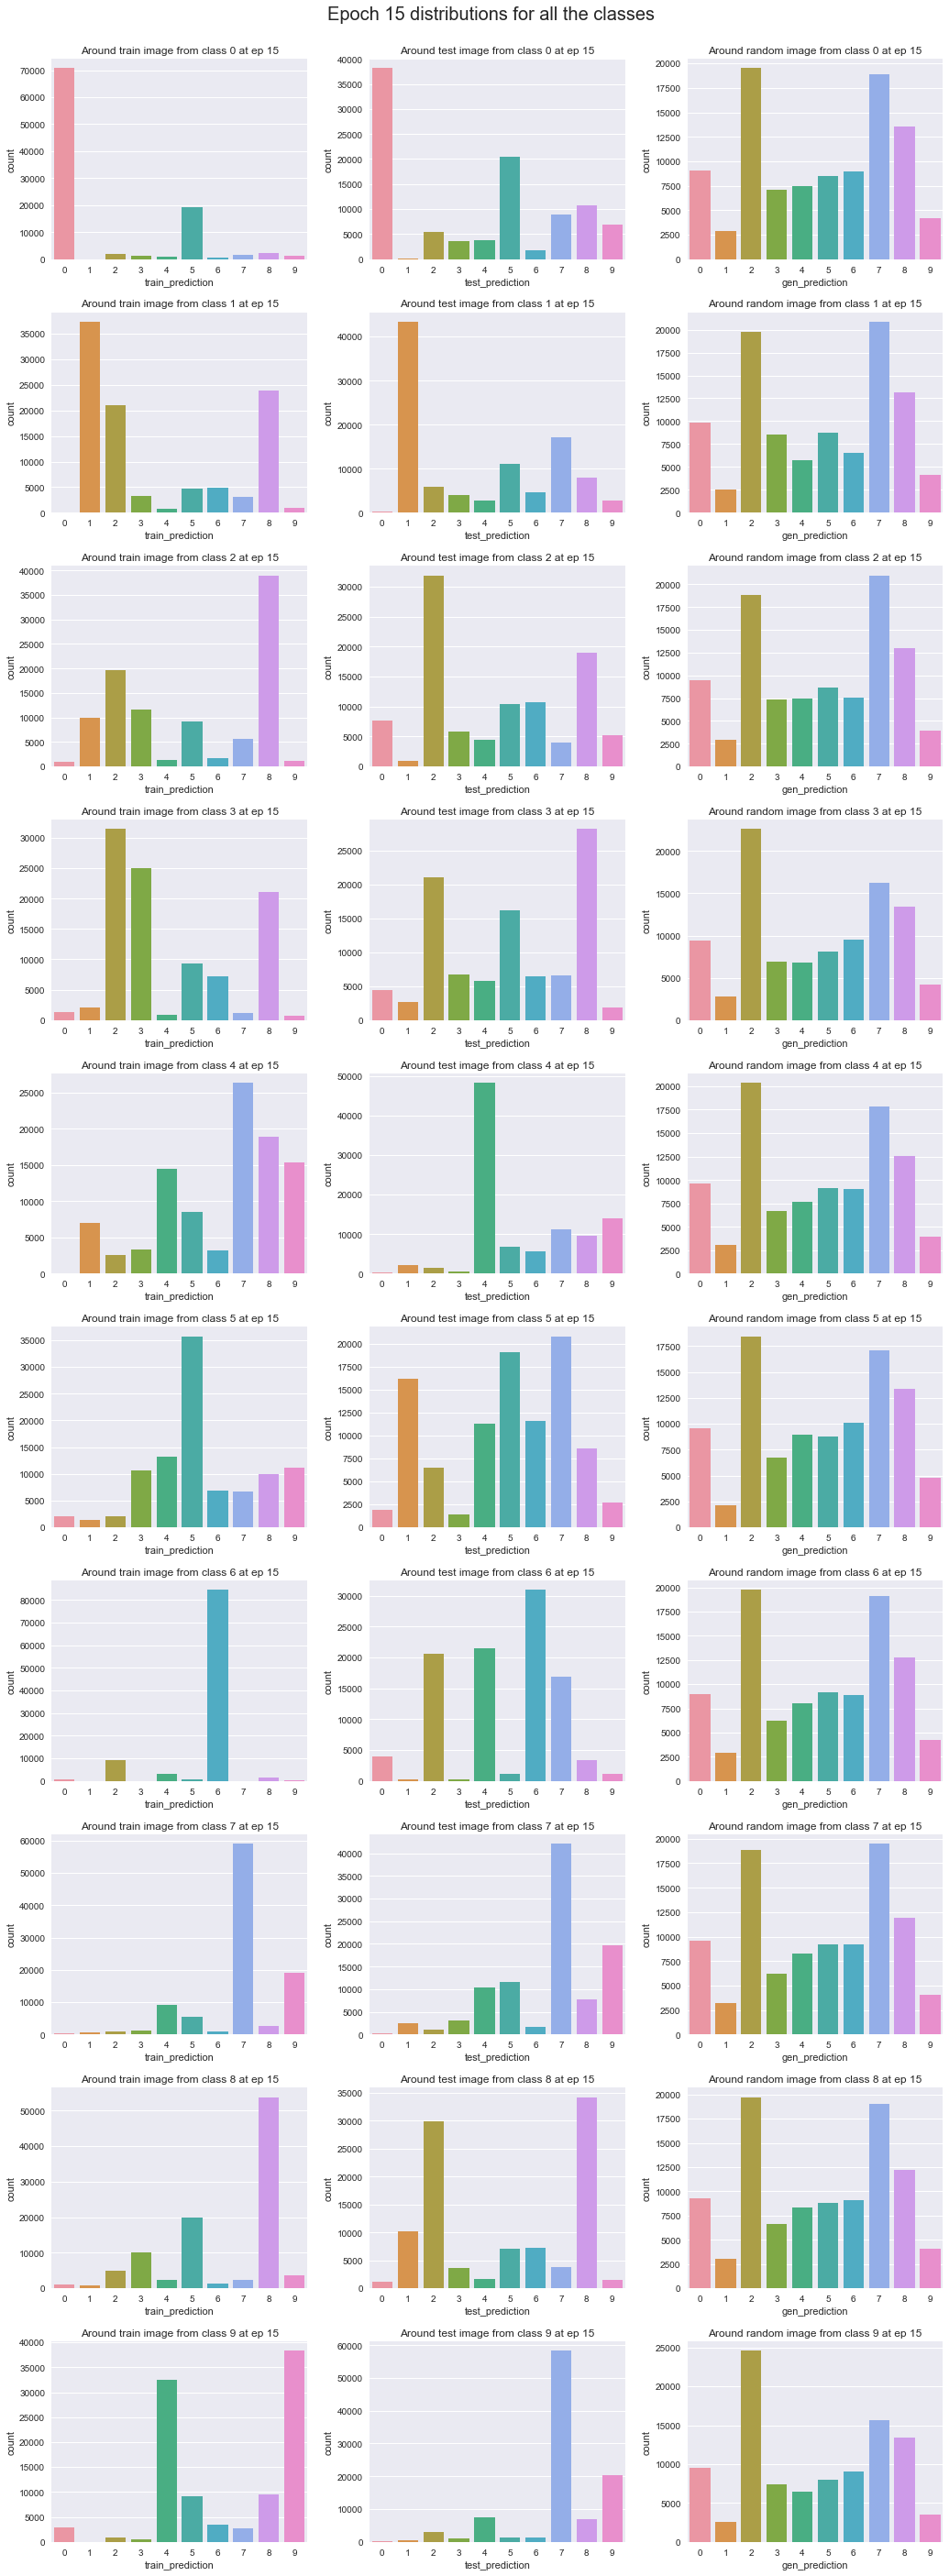

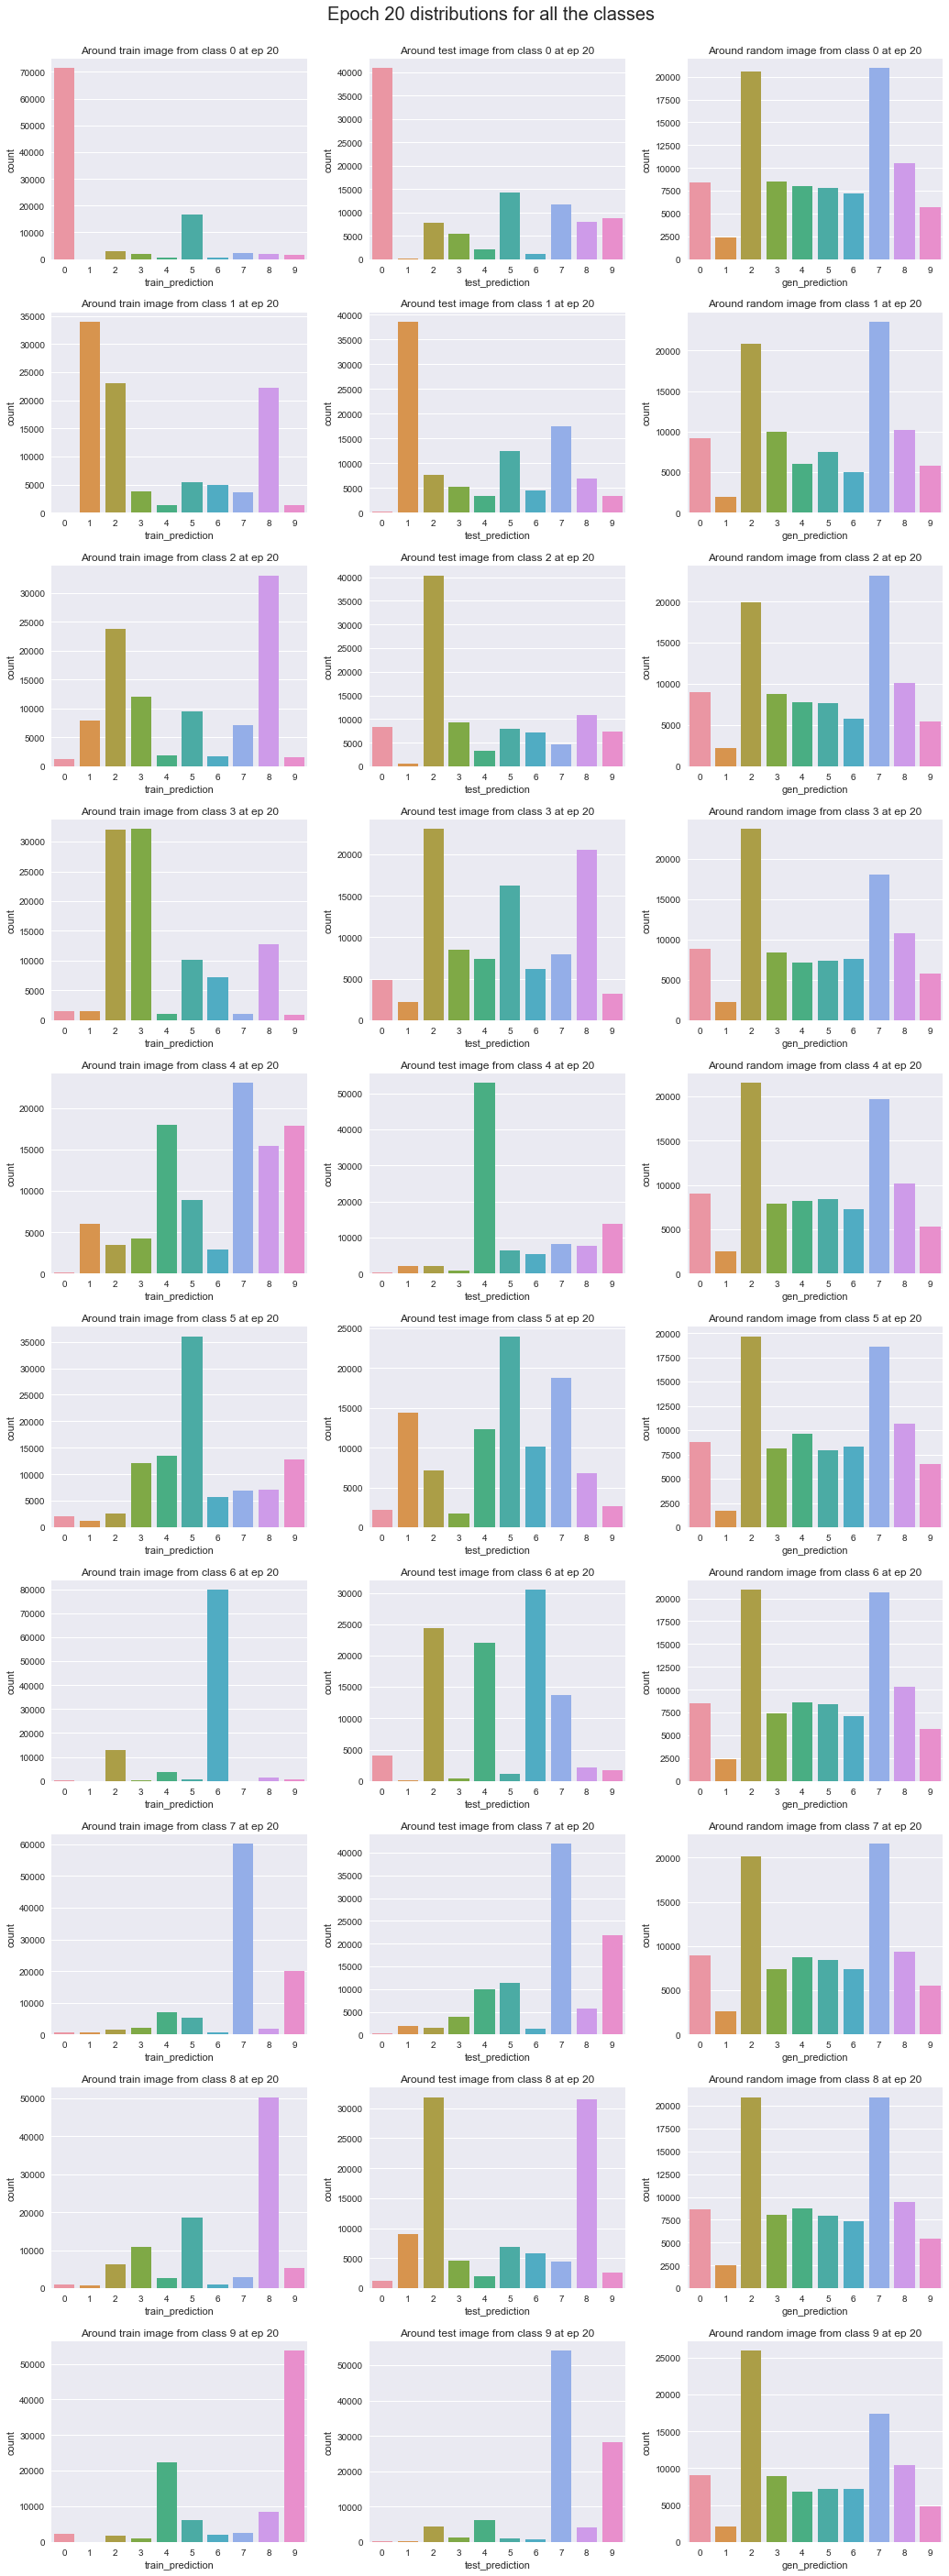

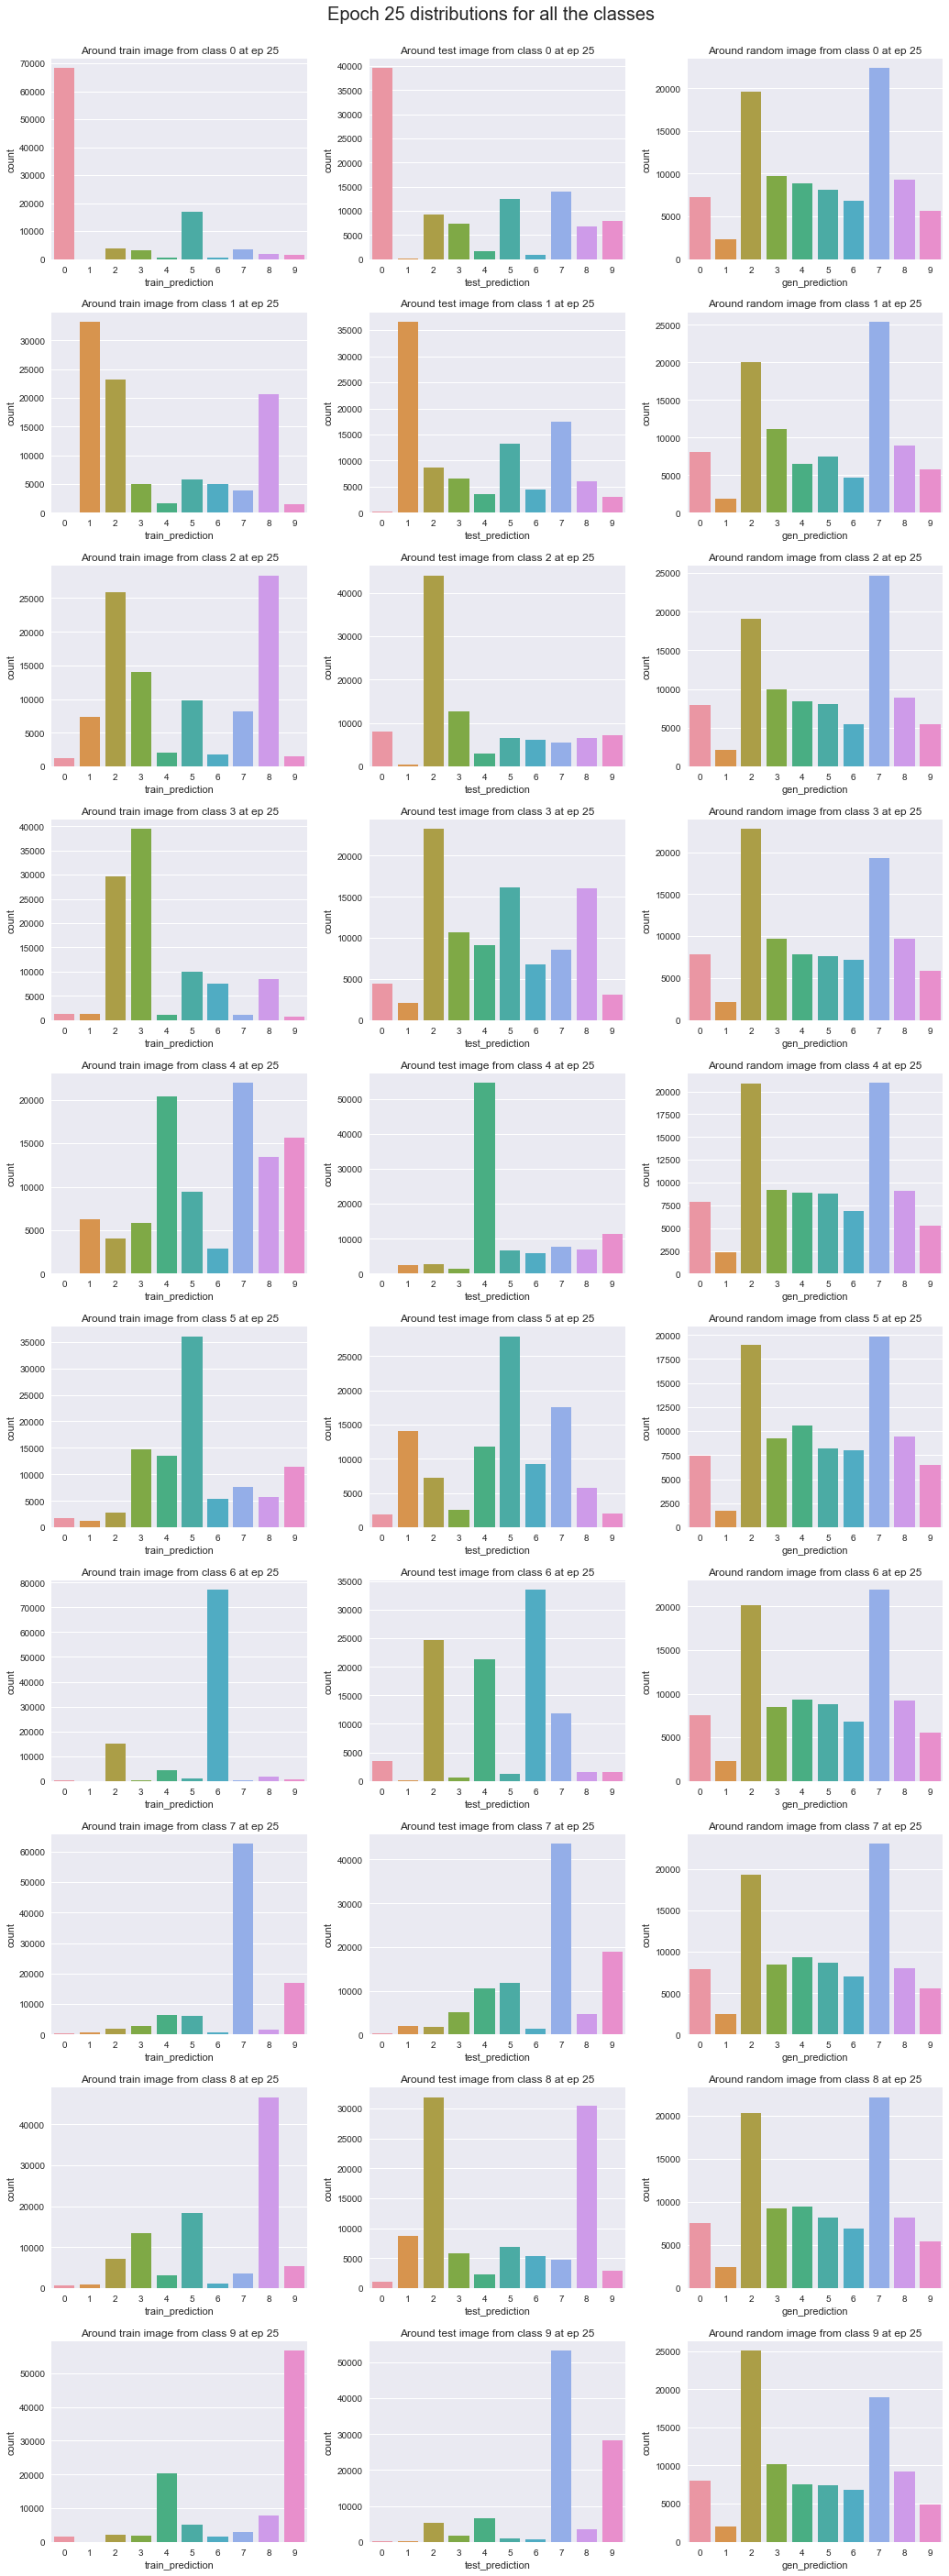

In [32]:
series_model_name = "FFN02-43-10"
model_ep = [5,10,15,20,25]
# model_ep = [25]




perturbation_factor = 5
num_sampling = 100000

samples = {}

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx]
    sub_train_targets = train_target[train_cls_idx]

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx]
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1)
    extended_test = random_test_img.repeat(num_sampling,1,1,1)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise
    extended_test = extended_test + test_noise
    extended_gen = extended_gen + gen_noise
    
    samples[picked_cls] = (extended_train, extended_test, extended_gen)


for ep in model_ep:
    new_model = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    new_model.load_state_dict(torch.load(series_model_name +f"-ep{ep}"))
    
#     train_df = pd.DataFrame()
#     test_df = pd.DataFrame()
#     gen_df = pd.DataFrame()
    f, axarr = plt.subplots(10, 3,  figsize=(15, 40))
    plt.style.use('seaborn')
    f.tight_layout(pad=4)
    f.subplots_adjust(top=0.96)
    plt.suptitle(f"Epoch {ep} distributions for all the classes",fontsize=20)
    for cls in samples:
        with torch.no_grad():
            train_outputs = new_model(samples[cls][0].to(device)).argmax(dim=1)
#             print(train_outputs)
            test_outputs = new_model(samples[cls][1].to(device)).argmax(dim=1)
            gen_outputs = new_model(samples[cls][2].to(device)).argmax(dim=1)
#         train_df[cls] = train_outputs.cpu().numpy().copy()
#         test_df[cls] = test_outputs.cpu().numpy().copy()
#         gen_df[cls] = gen_outputs.cpu().numpy().copy()
#     print(train_df)
        train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
        test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
        gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
        sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[cls][0])
        sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[cls][1])
        sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[cls][2])
        axarr[cls][0].set_title(f'Around train image from class {cls} at ep {ep}')
        axarr[cls][1].set_title(f'Around test image from class {cls} at ep {ep}')
        axarr[cls][2].set_title(f'Around random image from class {cls} at ep {ep}')


### Only trained and untrained

C:\Users\xxjtr\AppData\Local\Temp\ipykernel_23048\3892796156.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 3, figsize=(10, 5))


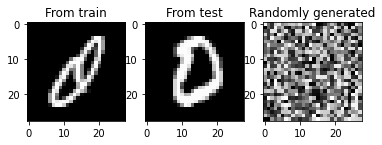

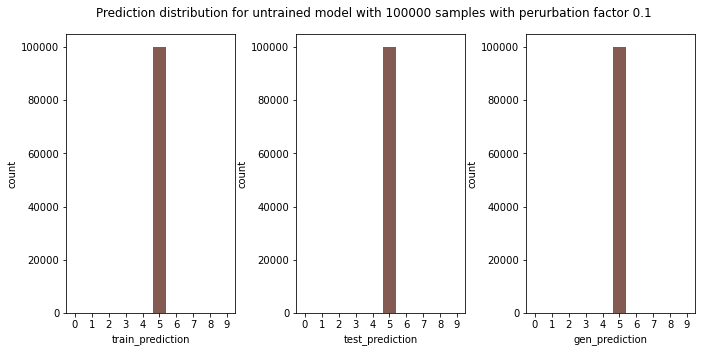

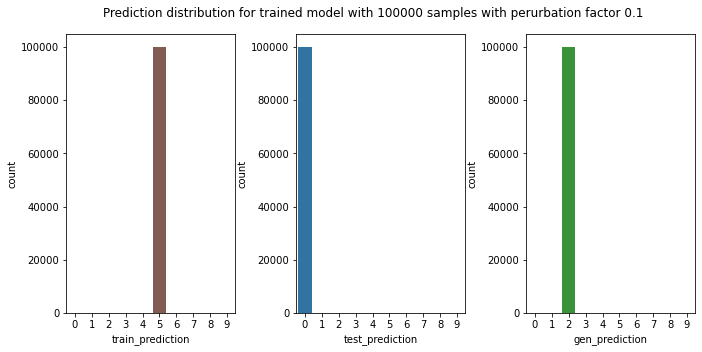

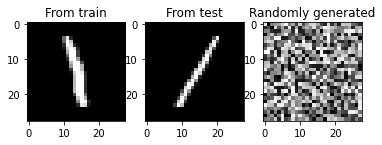

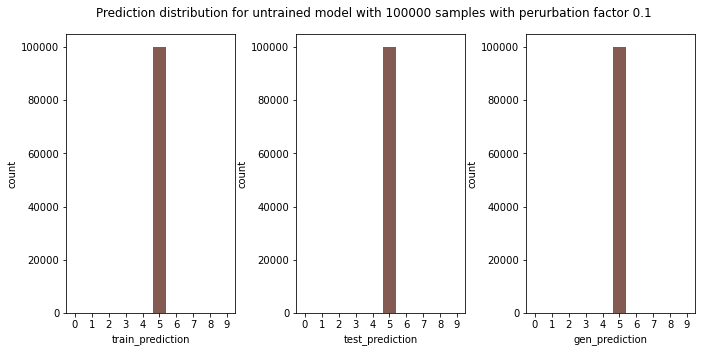

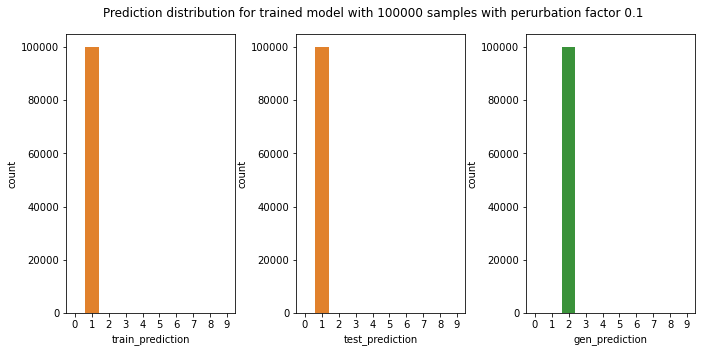

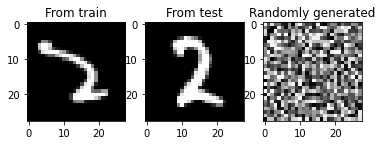

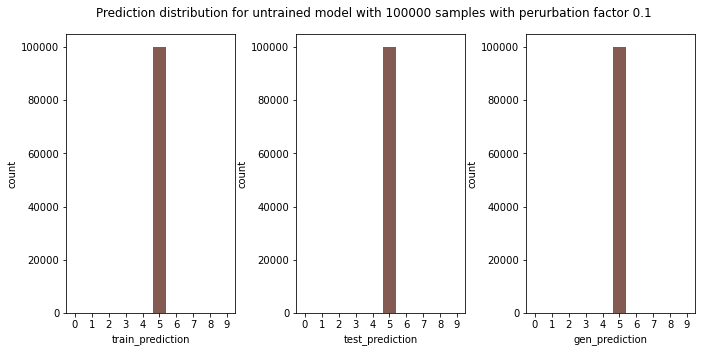

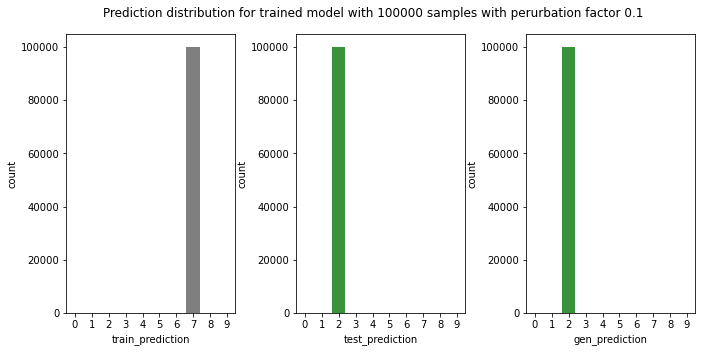

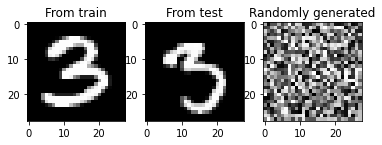

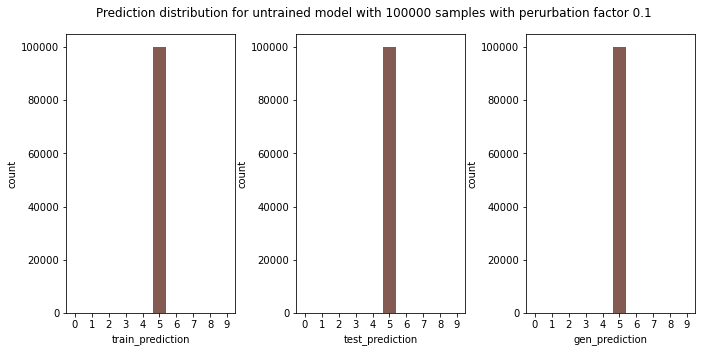

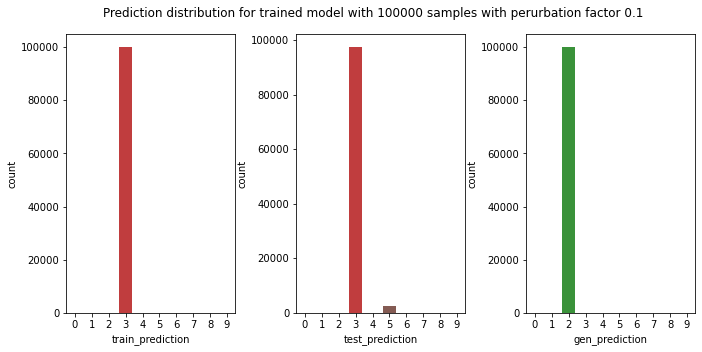

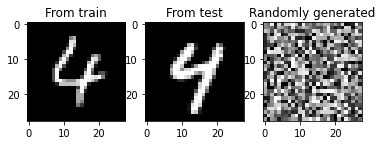

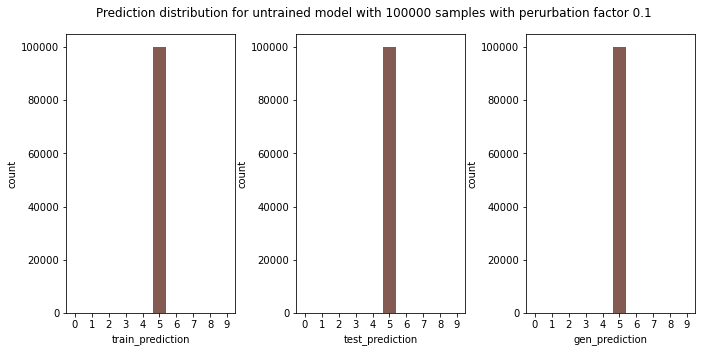

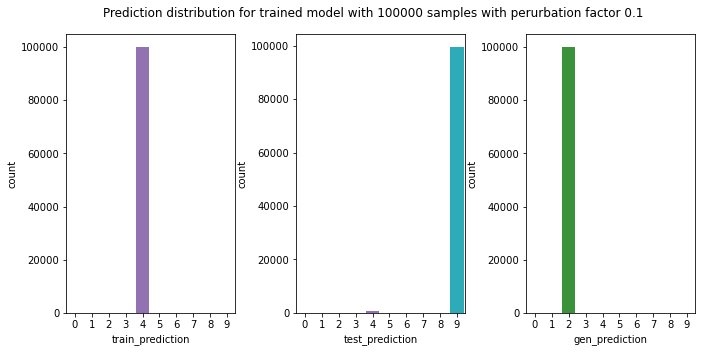

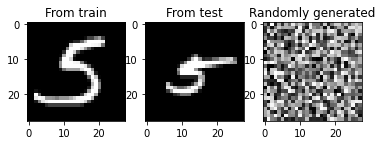

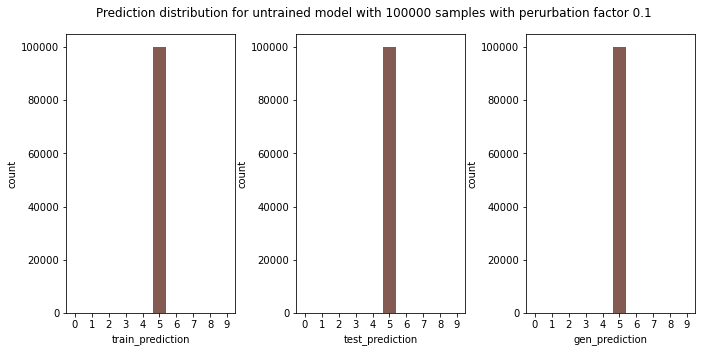

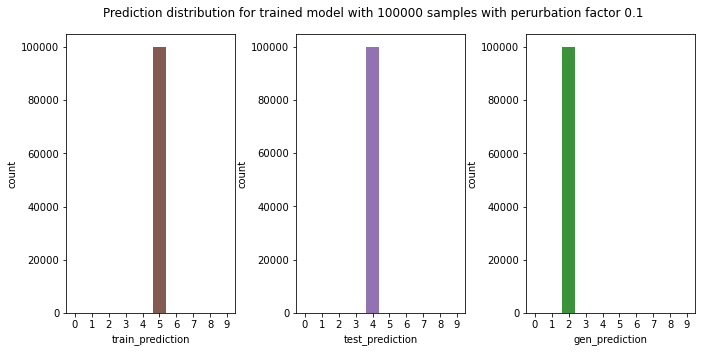

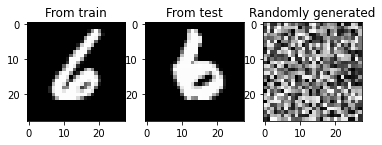

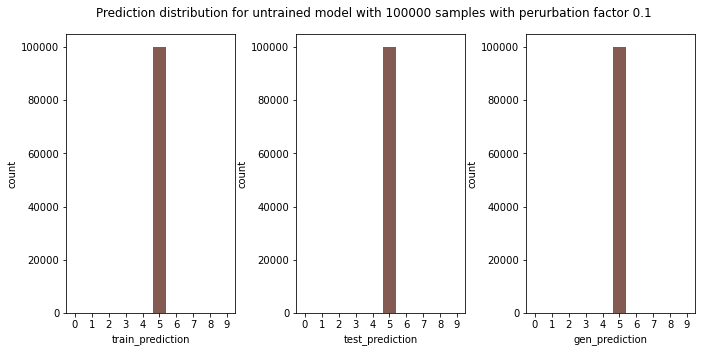

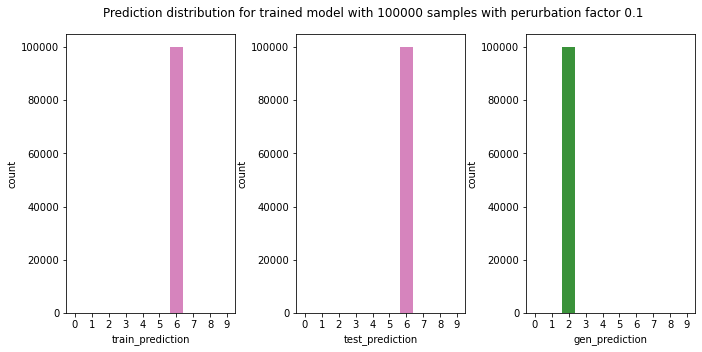

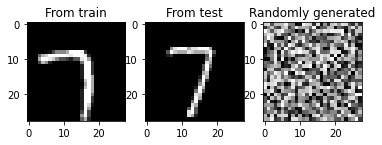

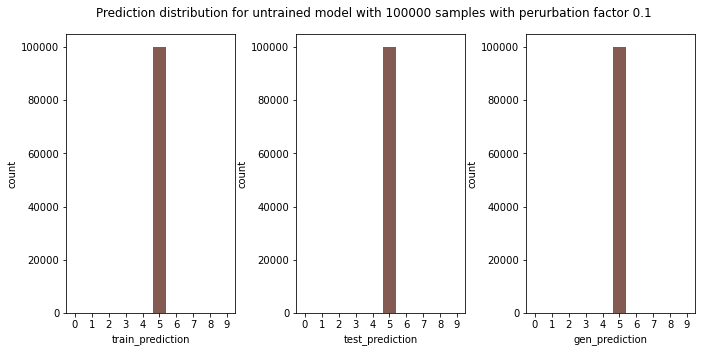

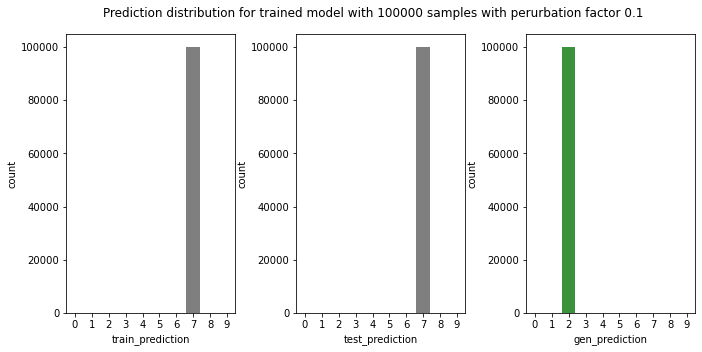

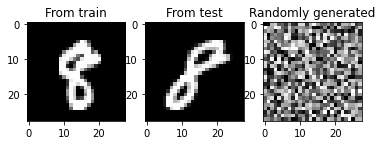

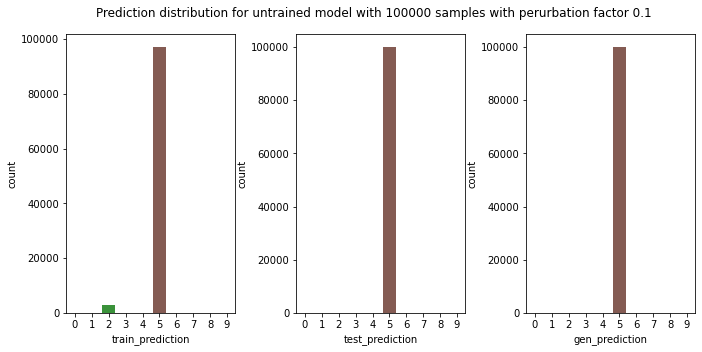

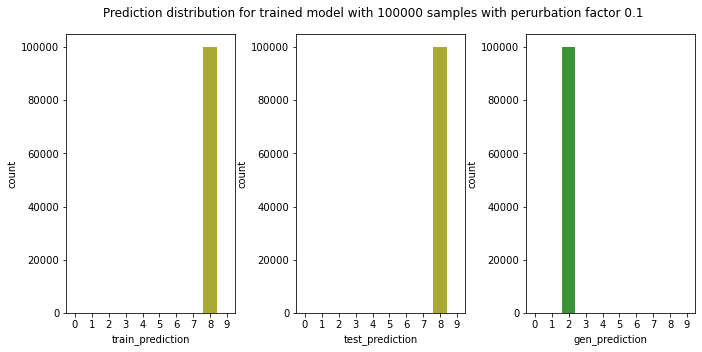

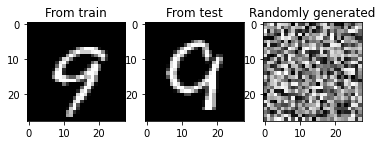

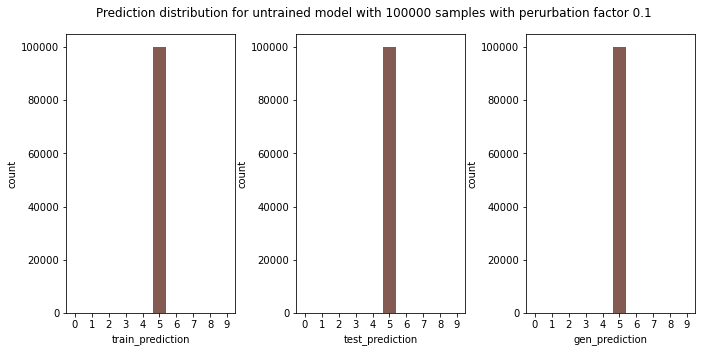

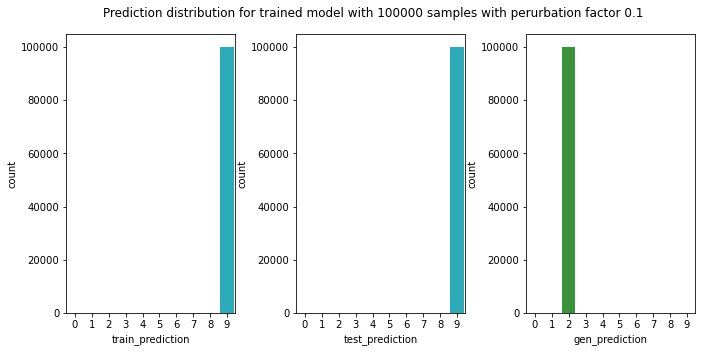

In [11]:
# picked_cls = 1
perturbation_factor = 0.1
num_sampling = 100000
for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1).to(device)
    extended_test = random_test_img.repeat(num_sampling,1,1,1).to(device)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1).to(device)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise.to(device)
    extended_test = extended_test + test_noise.to(device)
    extended_gen = extended_gen + gen_noise.to(device)


    # print("untrained:")
    with torch.no_grad():
        train_outputs = untrained_model(extended_train).argmax(dim=1)
        test_outputs = untrained_model(extended_test).argmax(dim=1)
        gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for untrained model with {num_sampling} samples with perurbation factor {perturbation_factor}")

    # print("trained:")
    with torch.no_grad():
        train_outputs = model(extended_train).argmax(dim=1)
        test_outputs = model(extended_test).argmax(dim=1)
        gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for trained model with {num_sampling} samples with perurbation factor {perturbation_factor}")





C:\Users\xxjtr\AppData\Local\Temp\ipykernel_23048\3892796156.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axarr = plt.subplots(1, 3, figsize=(10, 5))


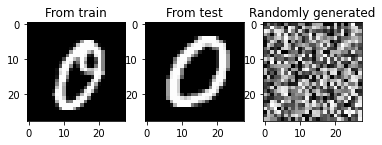

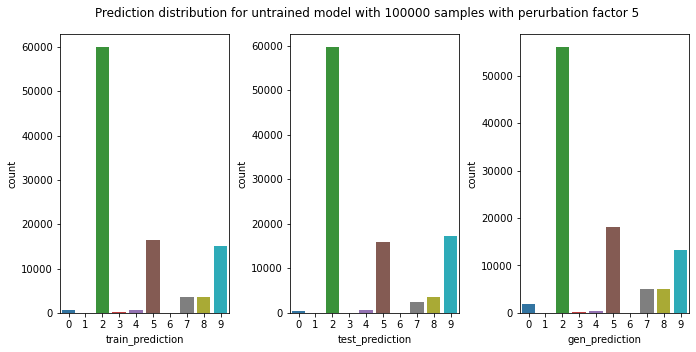

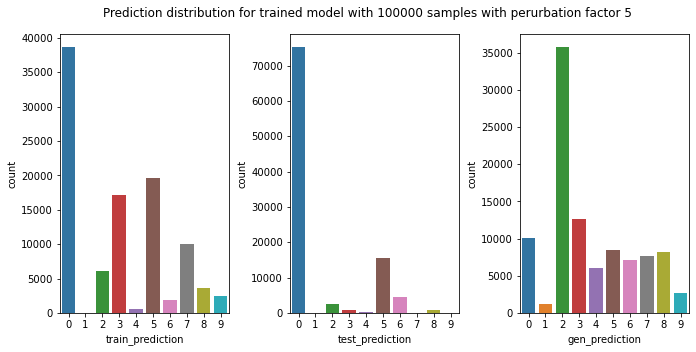

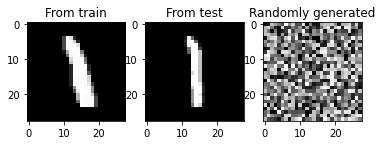

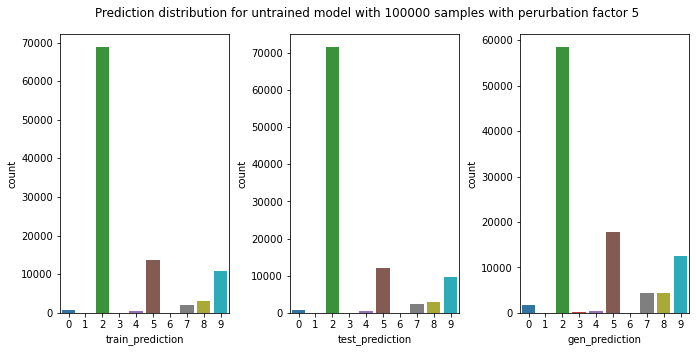

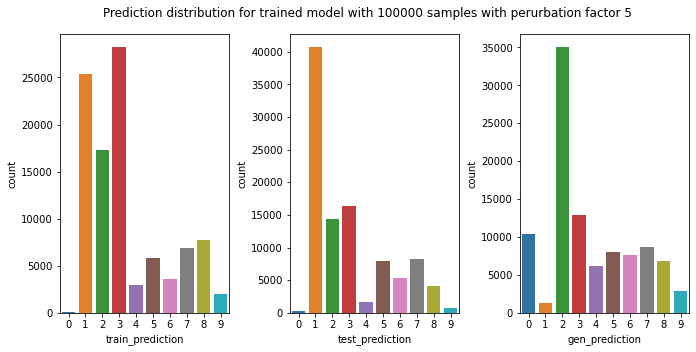

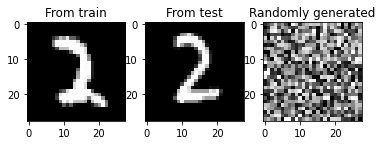

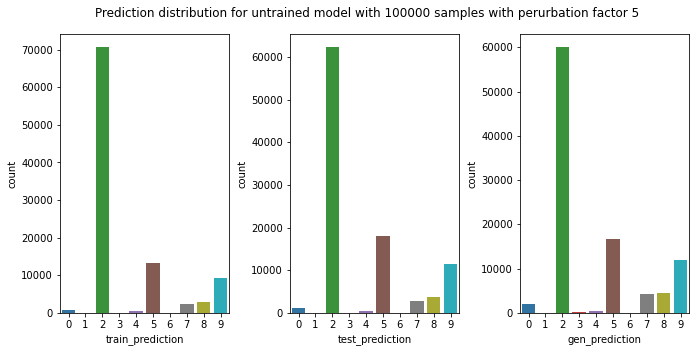

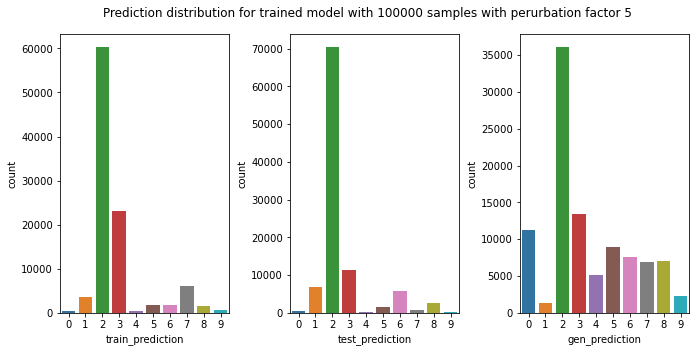

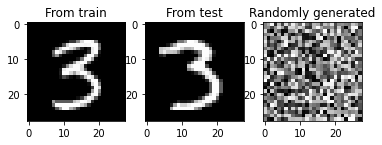

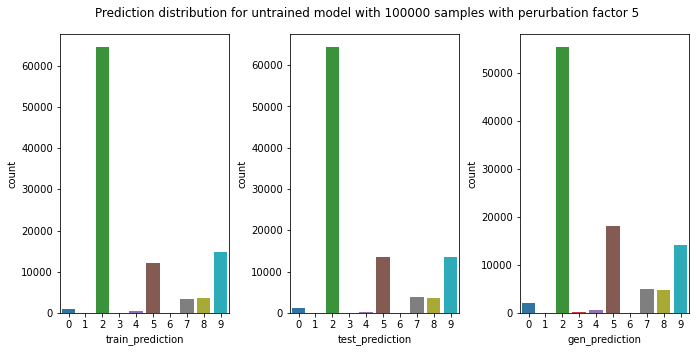

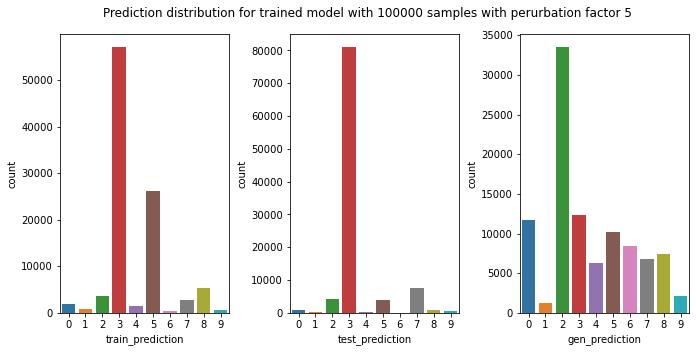

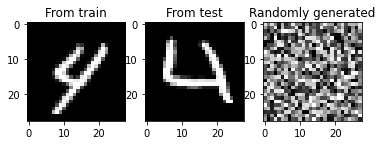

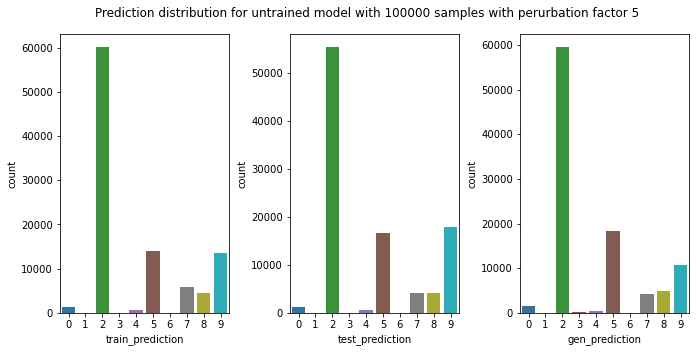

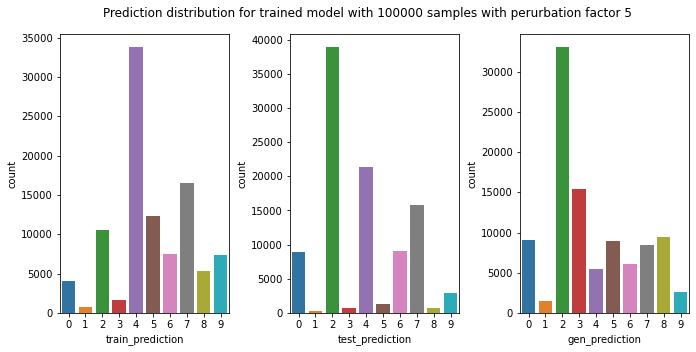

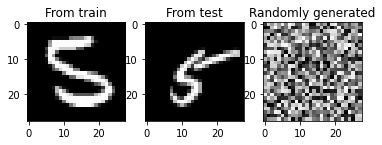

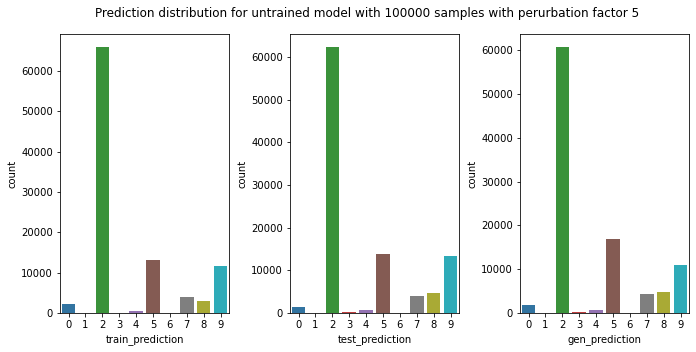

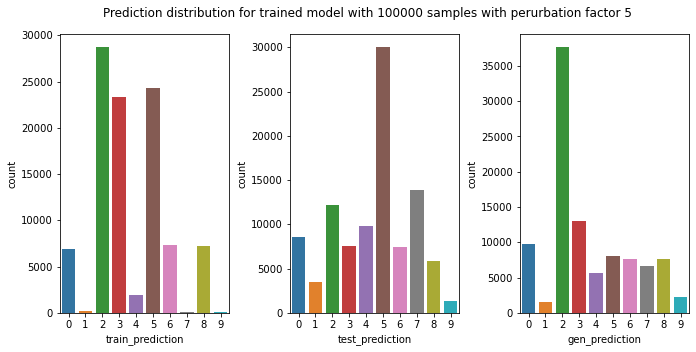

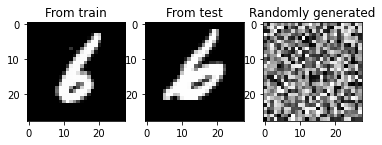

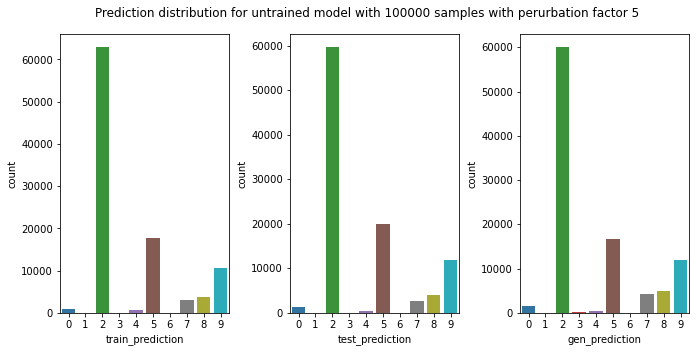

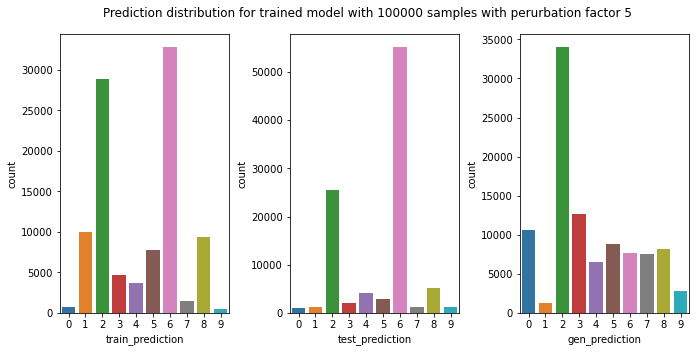

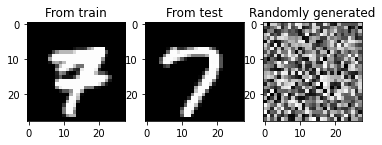

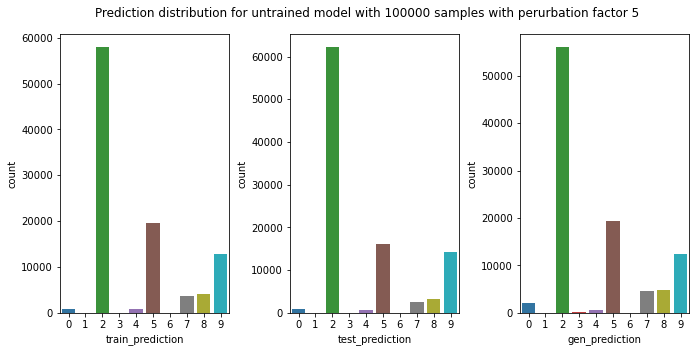

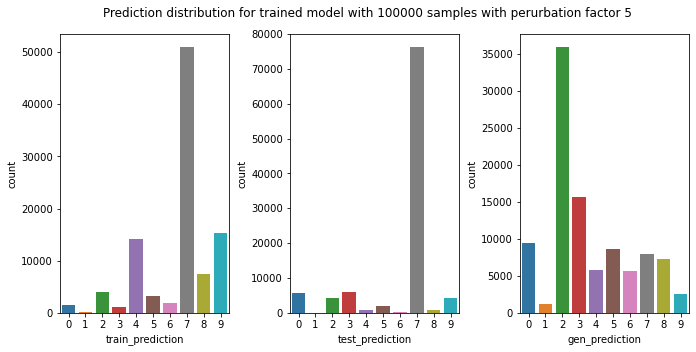

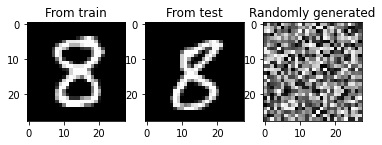

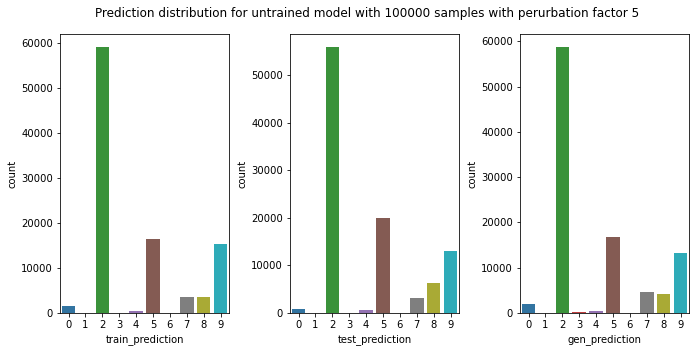

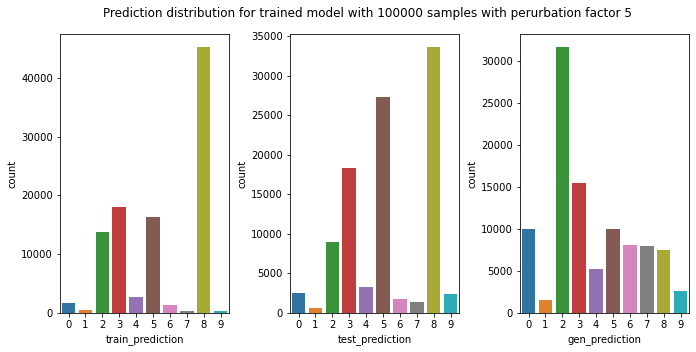

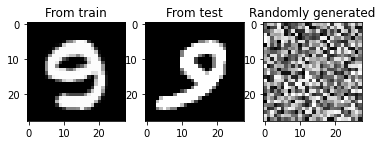

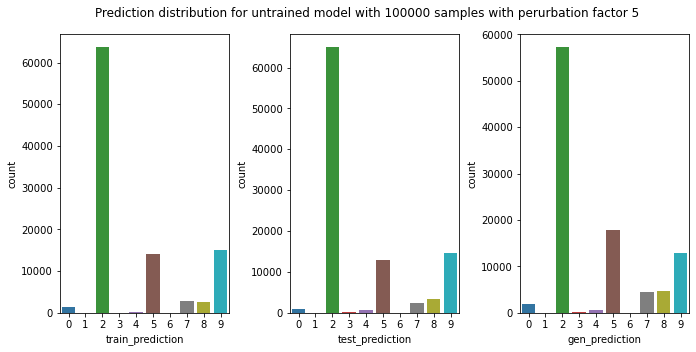

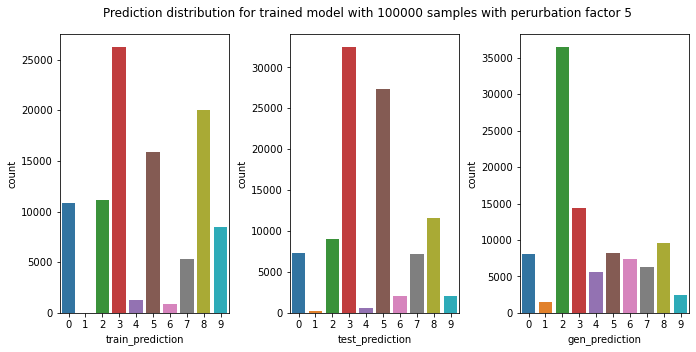

In [12]:
# picked_cls = 1
perturbation_factor = 5
num_sampling = 100000

for picked_cls in range(10):
    train_cls_idx = train_target==picked_cls    

    sub_train_dataset = train_data[train_cls_idx].to(device)
    sub_train_targets = train_target[train_cls_idx].to(device)

    test_cls_idx = test_target==picked_cls

    sub_test_dataset = test_data[test_cls_idx].to(device)
    sub_test_targets = test_target[test_cls_idx].to(device)


    random_train_idx = random.randint(0, len(sub_train_targets)-1)
    random_test_idx = random.randint(0, len(sub_test_targets)-1)


    random_train_img = sub_train_dataset[random_train_idx]
    random_test_img = sub_test_dataset[random_test_idx]
    random_gen_img = torch.rand(1, 28, 28)


    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(random_train_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[0].title.set_text('From train')
    axarr[1].imshow(random_test_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[1].title.set_text('From test')
    axarr[2].imshow(random_gen_img.cpu().detach().numpy().reshape(28, 28), cmap="gray")
    axarr[2].title.set_text('Randomly generated')
    # plt.title(f"Train, test, random generate")


    

    extended_train = random_train_img.repeat(num_sampling,1,1,1).to(device)
    extended_test = random_test_img.repeat(num_sampling,1,1,1).to(device)
    extended_gen = random_gen_img.repeat(num_sampling,1,1,1).to(device)


    # with torch.no_grad():
    #     train_outputs = model(extended_train).argmax(dim=1)
    #     test_outputs = model(extended_test).argmax(dim=1)
    #     gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print("untrained:")
    # with torch.no_grad():
    #     train_outputs = untrained_model(extended_train).argmax(dim=1)
    #     test_outputs = untrained_model(extended_test).argmax(dim=1)
    #     gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    # print('================================================before^======================================')
    train_noise = torch.normal(0, 1, size=extended_train.shape) * perturbation_factor
    test_noise = torch.normal(0, 1, size=extended_test.shape) * perturbation_factor
    gen_noise = torch.normal(0, 1, size=extended_gen.shape) * perturbation_factor

    extended_train = extended_train + train_noise.to(device)
    extended_test = extended_test + test_noise.to(device)
    extended_gen = extended_gen + gen_noise.to(device)


    # print("untrained:")
    with torch.no_grad():
        train_outputs = untrained_model(extended_train).argmax(dim=1)
        test_outputs = untrained_model(extended_test).argmax(dim=1)
        gen_outputs = untrained_model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for untrained model with {num_sampling} samples with perurbation factor {perturbation_factor}")

    # print("trained:")
    with torch.no_grad():
        train_outputs = model(extended_train).argmax(dim=1)
        test_outputs = model(extended_test).argmax(dim=1)
        gen_outputs = model(extended_gen).argmax(dim=1)
    #     print(train_outputs)
    #     print(test_outputs)
    #     print(gen_outputs)
    draw_distribution(train_outputs, test_outputs, gen_outputs, f"Prediction distribution for trained model with {num_sampling} samples with perurbation factor {perturbation_factor}")





Text(0.5, 0.98, 'trained model with 100 different randomly generated images')

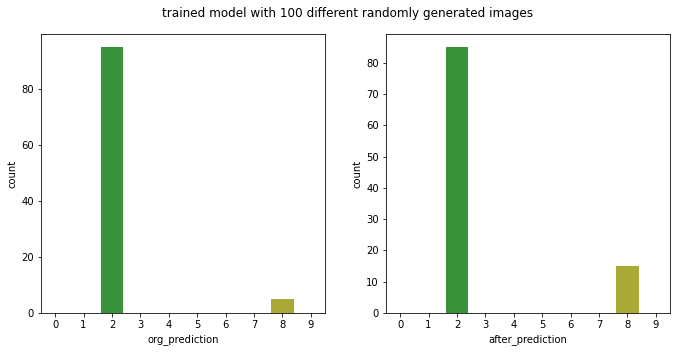

In [47]:
#trained model with different randomly generated images

last = None
num_sample = 100
t = torch.randint(0, 100, (num_sample,1))
t = t.repeat(1,28*28)
t = t.reshape(num_sample,1,28,28).to(device)


rimgs_org = torch.rand(num_sample, 1, 28, 28).to(device)
rimgs = (rimgs_org*t).to(device)


with torch.no_grad():
    org_outputs = model(rimgs_org).argmax(dim=1)
    after_outputs = model(rimgs).argmax(dim=1)
    
org_df = pd.DataFrame(org_outputs.cpu().numpy(), columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs.cpu().numpy(), columns = ['after_prediction'])

f, axarr = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout(pad=3) 
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[1])
# plt.suptitle(title)
plt.suptitle(f"trained model with {num_sample} different randomly generated images")

#     print(o, "\n", o.argmax(dim=1))

# for _ in range(100):
#     t = random.randint(0,100)
#     print(t)
#     rimg = torch.rand(1, 28, 28)*t
# #     print(last == rimg)
#     rimg_extend = rimg[None, :].to(device)
#     with torch.no_grad():
#         o = model(rimg_extend)
#         print(o, "\n", o.argmax(dim=1))
#     last = rimg

Text(0.5, 0.98, 'untrained model with 100 different randomly generated images')

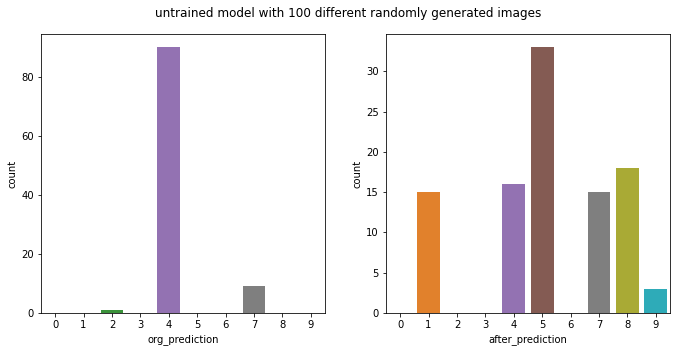

In [48]:
#new untrained model with different randomly generated images


new_untrained = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
num_sample = 100
t = torch.randint(0, 100, (num_sample,1))
t = t.repeat(1,28*28)
t = t.reshape(num_sample,1,28,28).to(device)


rimgs_org = torch.rand(num_sample, 1, 28, 28).to(device)
rimgs = (rimgs_org*t).to(device)


with torch.no_grad():
    org_outputs = new_untrained(rimgs_org).argmax(dim=1)
    after_outputs = new_untrained(rimgs).argmax(dim=1)
    
org_df = pd.DataFrame(org_outputs.cpu().numpy(), columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs.cpu().numpy(), columns = ['after_prediction'])

f, axarr = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout(pad=3) 
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[1])
# plt.suptitle(title)
plt.suptitle(f"untrained model with {num_sample} different randomly generated images")


# last = None
# for _ in range(100):
# #     t=1
#     t = random.randint(0,100)
#     print(t)
#     rimg = torch.rand(1, 28, 28)*t
# #     print(last == rimg)
#     rimg_extend = rimg[None, :].to(device)
#     with torch.no_grad():
#         o = new_untrained(rimg_extend)
#         print(o, "\n", o.argmax(dim=1))
#     last = rimg

84


Text(0.5, 0.98, ' 100 different untrained models with same randomly generated image')

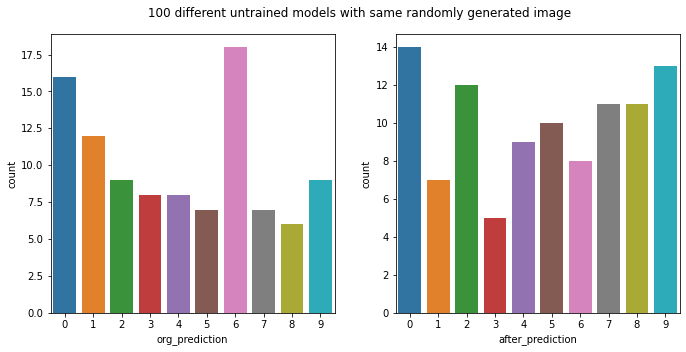

In [51]:
# try same random image but different untrained models

num_sample = 100
t = random.randint(0,100)
print(t)
rimg_org = torch.rand(1,1, 28, 28).to(device)
rimg = rimg_org*t
org_outputs = []
after_outputs = []
for _ in range(num_sample):
    new_untrained = FeedforwardNeuralNetModel(28*28, 128, 10).to(device)
    
    with torch.no_grad():
        org_o = new_untrained(rimg_org).argmax(dim=1)
        after_o = new_untrained(rimg).argmax(dim=1)
        
    org_outputs.append(org_o.item())
    after_outputs.append(after_o.item())
#         print(o, "\n", o.argmax(dim=1).item())
#     last = rimg
org_df = pd.DataFrame(org_outputs, columns = ['org_prediction'])
after_df = pd.DataFrame(after_outputs, columns = ['after_prediction'])

f, axarr = plt.subplots(1, 2, figsize=(10, 5))
f.tight_layout(pad=3) 
sns.countplot(data=org_df, x="org_prediction", order=list(range(10)), ax=axarr[0])
sns.countplot(data=after_df, x="after_prediction", order=list(range(10)), ax=axarr[1])
# plt.suptitle(title)
plt.suptitle(f" {num_sample} different untrained models with same randomly generated image")

In [52]:
# draw_distribution(train_outputs, test_outputs, gen_outputs, "title")
# train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
# test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
# gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
# f, axarr = plt.subplots(1, 3, figsize=(10, 5))
# f.tight_layout(pad=3) 
# sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[0])
# sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[1])
# sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[2])
# print(train_df)

In [49]:
for data, target in test_loader:
    print(data.size())
    print(target.size())
    

torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [18]:
a = [1,2,4,3]
a.sort().revers
print(a)

AttributeError: 'NoneType' object has no attribute 'revers'

In [53]:
# x =torch.randint(0, 100, (10,1))
# print(x)
# b = x.repeat(1,25)
# print(b, b.shape)

# d = b.reshape(10,1,5,5)
# print(d, d.shape)

In [12]:
print(model)

FeedforwardNeuralNetModel(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


C:\Users\xxjtr\AppData\Local\Temp\ipykernel_17580\2600702943.py:6: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  f.tight_layout(pad=10)


<AxesSubplot:xlabel='gen_prediction', ylabel='count'>

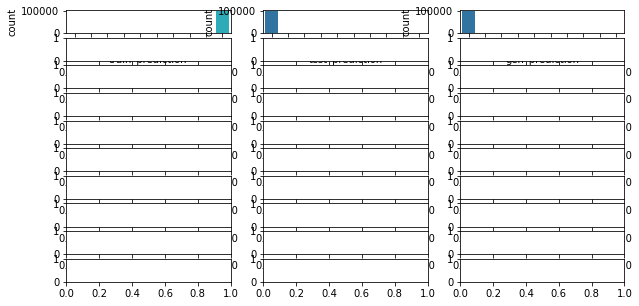

In [15]:
train_df = pd.DataFrame(train_outputs.cpu().numpy(), columns = ['train_prediction'])
test_df = pd.DataFrame(test_outputs.cpu().numpy(), columns = ['test_prediction'])
gen_df = pd.DataFrame(gen_outputs.cpu().numpy(), columns = ['gen_prediction'])
f, axarr = plt.subplots(10, 3, figsize=(10, 5))
# print(axarr[])
f.tight_layout(pad=10) 
sns.countplot(data=train_df, x="train_prediction", order=list(range(10)), ax=axarr[0][0])
sns.countplot(data=test_df, x="test_prediction", order=list(range(10)), ax=axarr[0][1])
sns.countplot(data=gen_df, x="gen_prediction", order=list(range(10)), ax=axarr[0][2])
# plt.suptitle(title)

In [19]:
"sfsd"+f"{a}"

'sfsd[1, 2, 3, 4]'